In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.8,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True, "lines.linewidth": 3},
)

results_path = Path.cwd().resolve().parent / "benchmarks/results/"
mcts_path = Path.cwd().resolve().parent / "tgnnexplainer/xgraph/saved_mcts_results"

os.makedirs("plots/navs", exist_ok=True)
os.makedirs("plots/threshold_cmp", exist_ok=True)
os.makedirs("plots/case-study", exist_ok=True)
os.makedirs("plots/fidelity-rollout", exist_ok=True)
os.makedirs("tables", exist_ok=True)

plot_only_og = True
explainers = ["xtg", "attn", "pbone", "pg", "xtg-d", "xtg-og"]
labels = {
    "xtg": "MLPNavigator",
    "attn": "ATTN",
    "pbone": "PBONE",
    "pg": "PG",
    "xtg-d": "DotProductNavigator",
    "xtg-non": "PGNavigator (NO NAV)",
    "xtg-og": "PGNavigator",
}
dataset_to_index = {
    "simulate_v1": "Synthetic V1",
    "simulate_v2": "Synthetic V2",
    "wikipedia": "Wikipedia",
    "reddit": "Reddit",
}
navs = ['xtg', 'xtg-og', 'xtg-d']
markers = {"xtg-og": "s", "attn": "o", "pbone": "^", "pg": "X", "xtg-d": "P", "xtg": "X"}

In [3]:
## Their data
df_tgat_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.891,
        "PBONE": 0.027,
        "PG": 1.354,
        "PGNavigator": 1.836,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.564,
        "PBONE": -2.227,
        "PG": 0.692,
        "PGNavigator": 1.477,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.658,
        "PBONE": 0.167,
        "PG": 0.804,
        "PGNavigator": 1.518,
    },
    ("Reddit", "AUFSC"): {
        "ATTN": -0.654,
        "PBONE": -2.492,
        "PG": -0.369,
        "PGNavigator": 1.076,
    },
    ("Simulate V1", "Best FID"): {
        "ATTN": 0.555,
        "PBONE": 0.044,
        "PG": 0.476,
        "PGNavigator": 0.780,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": 0.390,
        "PBONE": -2.882,
        "PG": -0.081,
        "PGNavigator": 0.666,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.605,
        "PBONE": 0.096,
        "PG": 1.329,
        "PGNavigator": 1.630,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": 0.291,
        "PBONE": -4.771,
        "PG": -0.926,
        "PGNavigator": 1.331,
    },
}

df_tgn_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.479,
        "PBONE": 0.296,
        "PG": 0.464,
        "PGNavigator": 0.866,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.073,
        "PBONE": -0.601,
        "PG": -0.231,
        "PGNavigator": 0.590,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.575,
        "PBONE": 0.340,
        "PG": 0.679,
        "PGNavigator": 1.362,
    },
    ("Reddit", "AUFSC"): {"ATTN": 0.289, "PBONE": -0.256, "PG": 0.020, "PGNavigator": 1.113},
    ("Simulate V1", "Best FID"): {
        "ATTN": 2.178,
        "PBONE": 0.001,
        "PG": 2.006,
        "PGNavigator": 2.708,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": 1.624,
        "PBONE": -3.311,
        "PG": 0.626,
        "PGNavigator": 2.281,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.988,
        "PBONE": 0.320,
        "PG": 1.012,
        "PGNavigator": 4.356,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": -0.634,
        "PBONE": -5.413,
        "PG": -1.338,
        "PGNavigator": 3.224,
    },
}

df_tgat_theirs = pd.DataFrame.from_dict(df_tgat_theirs, orient="columns")
df_tgn_theirs = pd.DataFrame.from_dict(df_tgn_theirs, orient="columns")

# tgat_best_fid, tgat_aufsc = df_tgat_theirs.iloc[:, df_tgat_theirs.columns.get_level_values(1) == "Best FID"], df_tgat_theirs.iloc[:, df_tgat_theirs.columns.get_level_values(1) == "AUFSC"]
# # normalize
# tgat_best_fid = (tgat_best_fid - tgat_best_fid.min().min())/ (tgat_best_fid.max().max() - tgat_best_fid.min().min())
# tgat_aufsc = (tgat_aufsc - tgat_aufsc.min().min())/ (tgat_aufsc.max().max() - tgat_aufsc.min().min())

# relative_diffs_tgat_bf = {}
# # NOTE THE DIFFERENT COLUMN NAMES
# for col in tgat_best_fid.columns:
#     two_largest = tgat_best_fid[col].nlargest(2)
#     x2, x1 = two_largest.values
#     relative_diffs_tgat_bf[col] = (x2 - x1) / abs(x1)

# relative_diffs_tgat_aufsc = {}
# for col in tgat_aufsc.columns:
#     two_largest = tgat_aufsc[col].nlargest(2)
#     x2, x1 = two_largest.values
#     relative_diffs_tgat_aufsc[col] = (x2 - x1) / abs(x1)
    
# # zip the two dicts together and make a dataframe out of them
# zip_dict = {}
# for key1, key2 in zip(relative_diffs_tgat_bf, relative_diffs_tgat_aufsc):
#     zip_dict[key1] = relative_diffs_tgat_bf[key1]
#     zip_dict[key2]= relative_diffs_tgat_aufsc[key2]
# relative_diff_df_tgat = pd.DataFrame.from_dict(zip_dict, orient="index", columns=["TGAT"]).T
# relative_diff_df_tgat

# # now for tgn
# tgn_best_fid, tgn_aufsc = df_tgn_theirs.iloc[:, df_tgn_theirs.columns.get_level_values(1) == "Best FID"], df_tgn_theirs.iloc[:, df_tgn_theirs.columns.get_level_values(1) == "AUFSC"]
# # normalize
# tgn_best_fid = (tgn_best_fid - tgn_best_fid.min().min())/ (tgn_best_fid.max().max() - tgn_best_fid.min().min())
# tgn_aufsc = (tgn_aufsc - tgn_aufsc.min().min())/ (tgn_aufsc.max().max() - tgn_aufsc.min().min())

# relative_diffs_tgn_bf = {}
# for col in tgn_best_fid.columns:
#     two_largest = tgn_best_fid[col].nlargest(2)
#     x2, x1 = two_largest.values
#     relative_diffs_tgn_bf[col] = (x2 - x1) / abs(x1)
# relative_diffs_tgn_aufsc = {}
# for col in tgn_aufsc.columns:
#     two_largest = tgn_aufsc[col].nlargest(2)
#     x2, x1 = two_largest.values
#     relative_diffs_tgn_aufsc[col] = (x2 - x1) / abs(x1)
    
# # zip the two dicts together and make a dataframe out of them
# zip_dict = {}
# for key1, key2 in zip(relative_diffs_tgn_bf, relative_diffs_tgn_aufsc):
#     zip_dict[key1] = relative_diffs_tgn_bf[key1]
#     zip_dict[key2]= relative_diffs_tgn_aufsc[key2]
# relative_diff_df_tgn = pd.DataFrame.from_dict(zip_dict, orient="index", columns=["TGN"]).T

# relative_diff_df = pd.concat([relative_diff_df_tgat, relative_diff_df_tgn])
# relative_diff_df

In [4]:
# UTILITIES
def read_tabs_plot(files, name, plot_only_og=False):
    tabs = {k: pd.read_csv(v).groupby("sparsity").mean() for k, v in files.items()}
    best_fids = {k: tab["fid_inv_best"].max() for k, tab in tabs.items()}
    aufsc = {k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tabs.items()}
    print("Best Fid:", best_fids)
    print("AUFSC:", aufsc)
    for k, tab in tabs.items():
        if k not in ["xtg-og", "attn", "pbone", "pg"] and plot_only_og:
            continue
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k], marker=markers[k])
    plt.xlabel("Sparsity")
    plt.ylabel("Fidelity")
    plt.legend()
    plt.savefig(f"plots/{name}.png")
    plt.show()
    return tabs, best_fids, aufsc


def plot_navigators(tabs, name):
    for k, tab in tabs.items():
        if k in navs:
            plt.plot(tab.index, tab["fid_inv_best"], label=labels[k], marker=markers[k])
    plt.legend()
    plt.savefig(f"plots/navs/{name}_navs.png")
    plt.show()

## TGAT
### Wikipedia

Best Fid: {'xtg': 1.3948060590028764, 'attn': 0.8725247031450272, 'pbone': 1.2588138431310654, 'pg': 0.7149991992115975, 'xtg-d': 1.2527445781230926, 'xtg-og': 1.5133539831638336}
AUFSC: {'xtg': 0.881114971932955, 'attn': 0.5947575537126977, 'pbone': 0.862180685121566, 'pg': -0.41110718597285456, 'xtg-d': 0.5978107269029133, 'xtg-og': 1.1426431754780932}


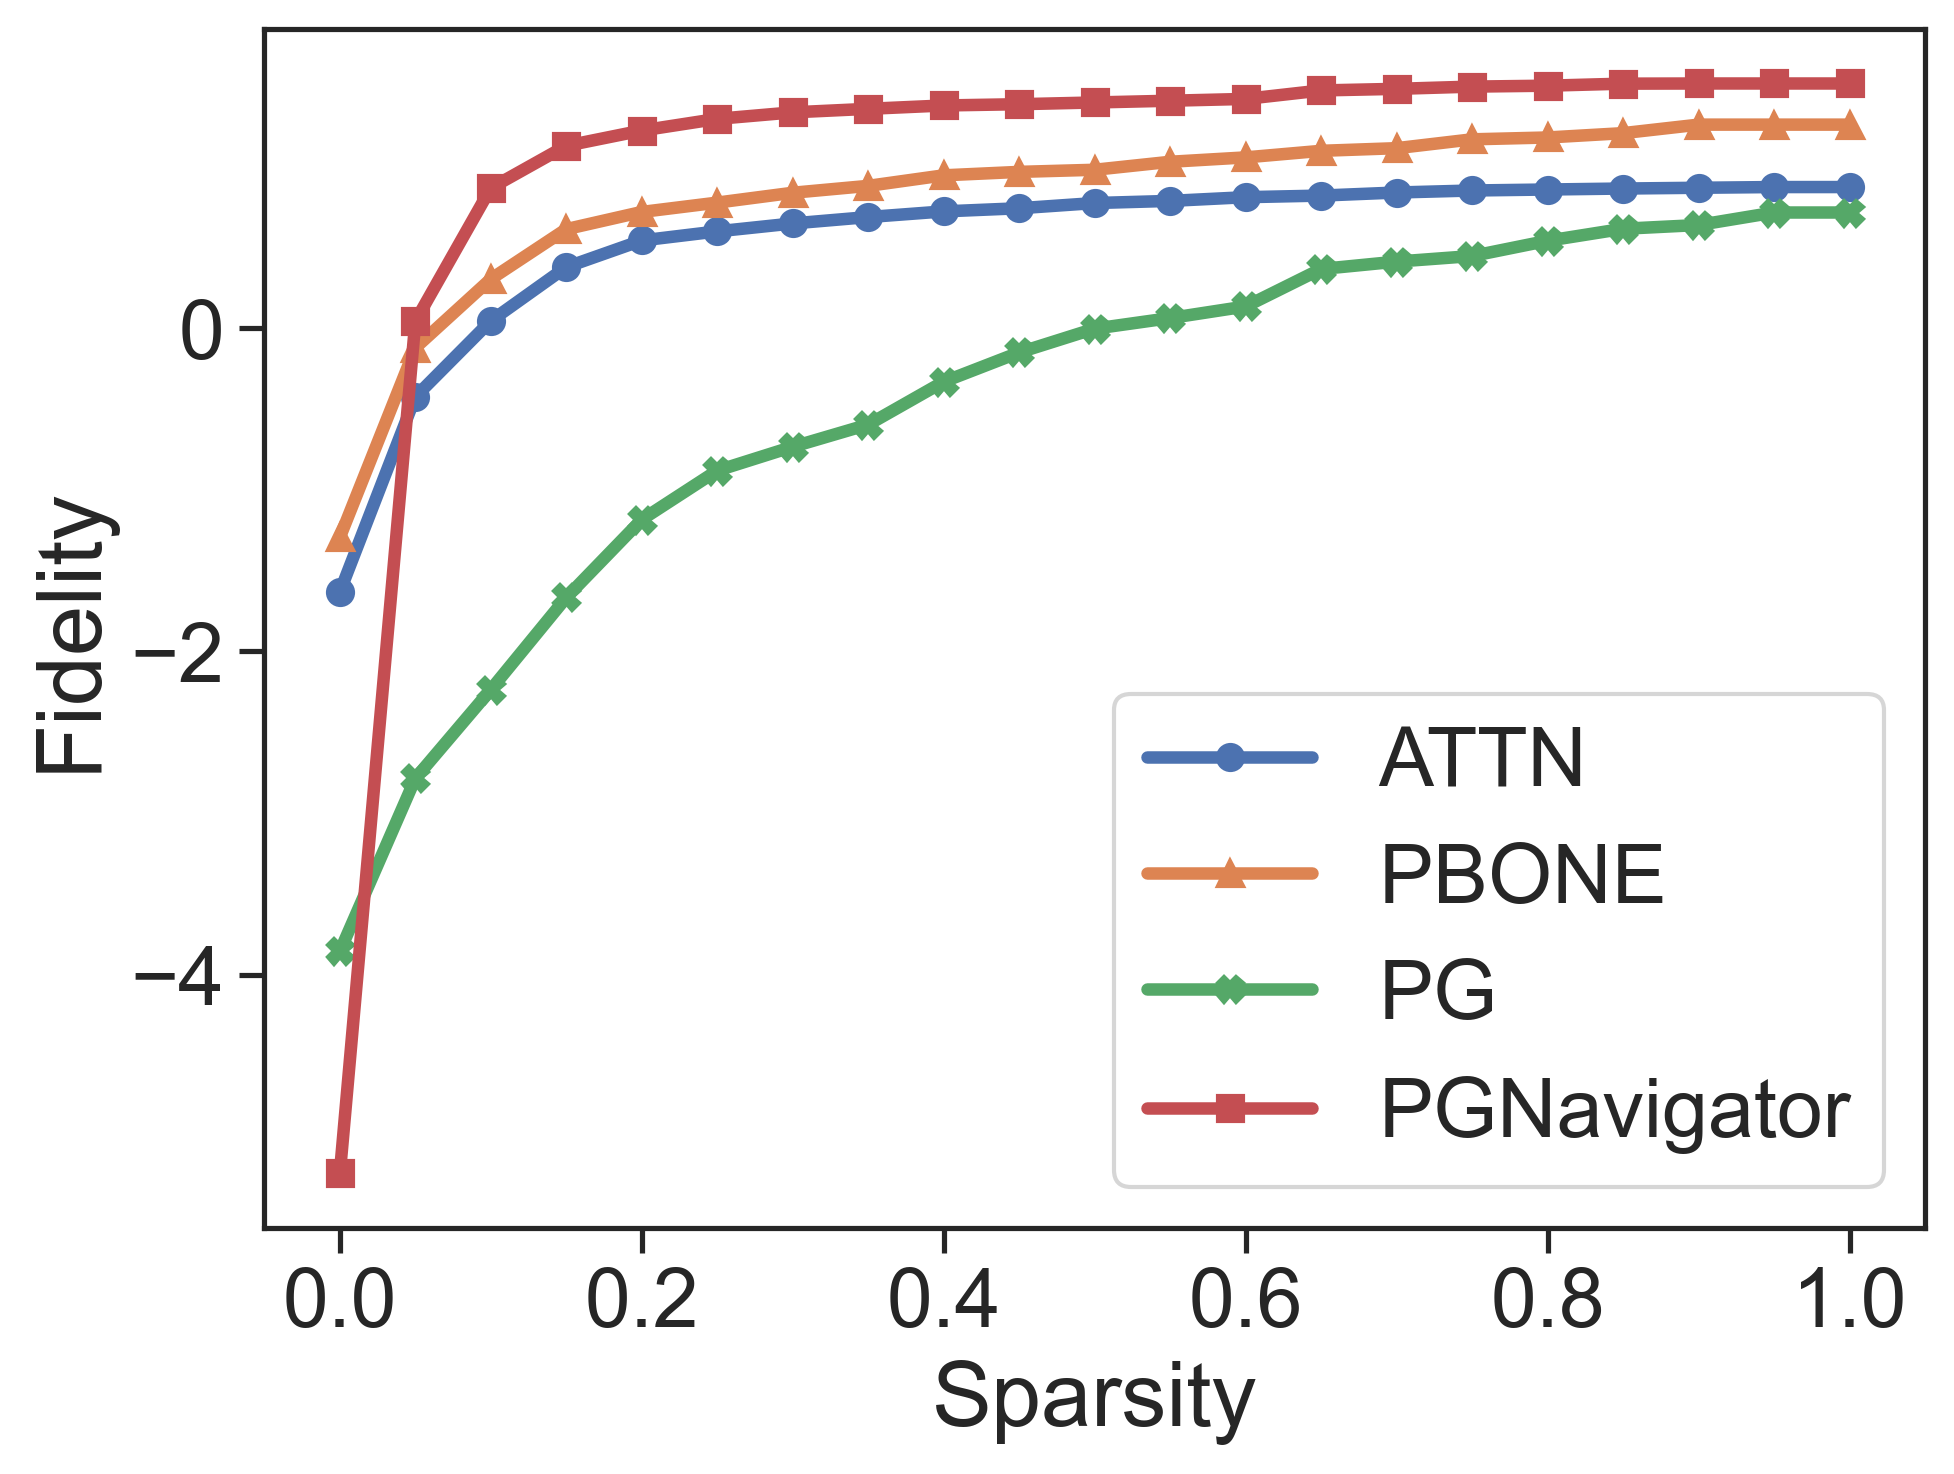

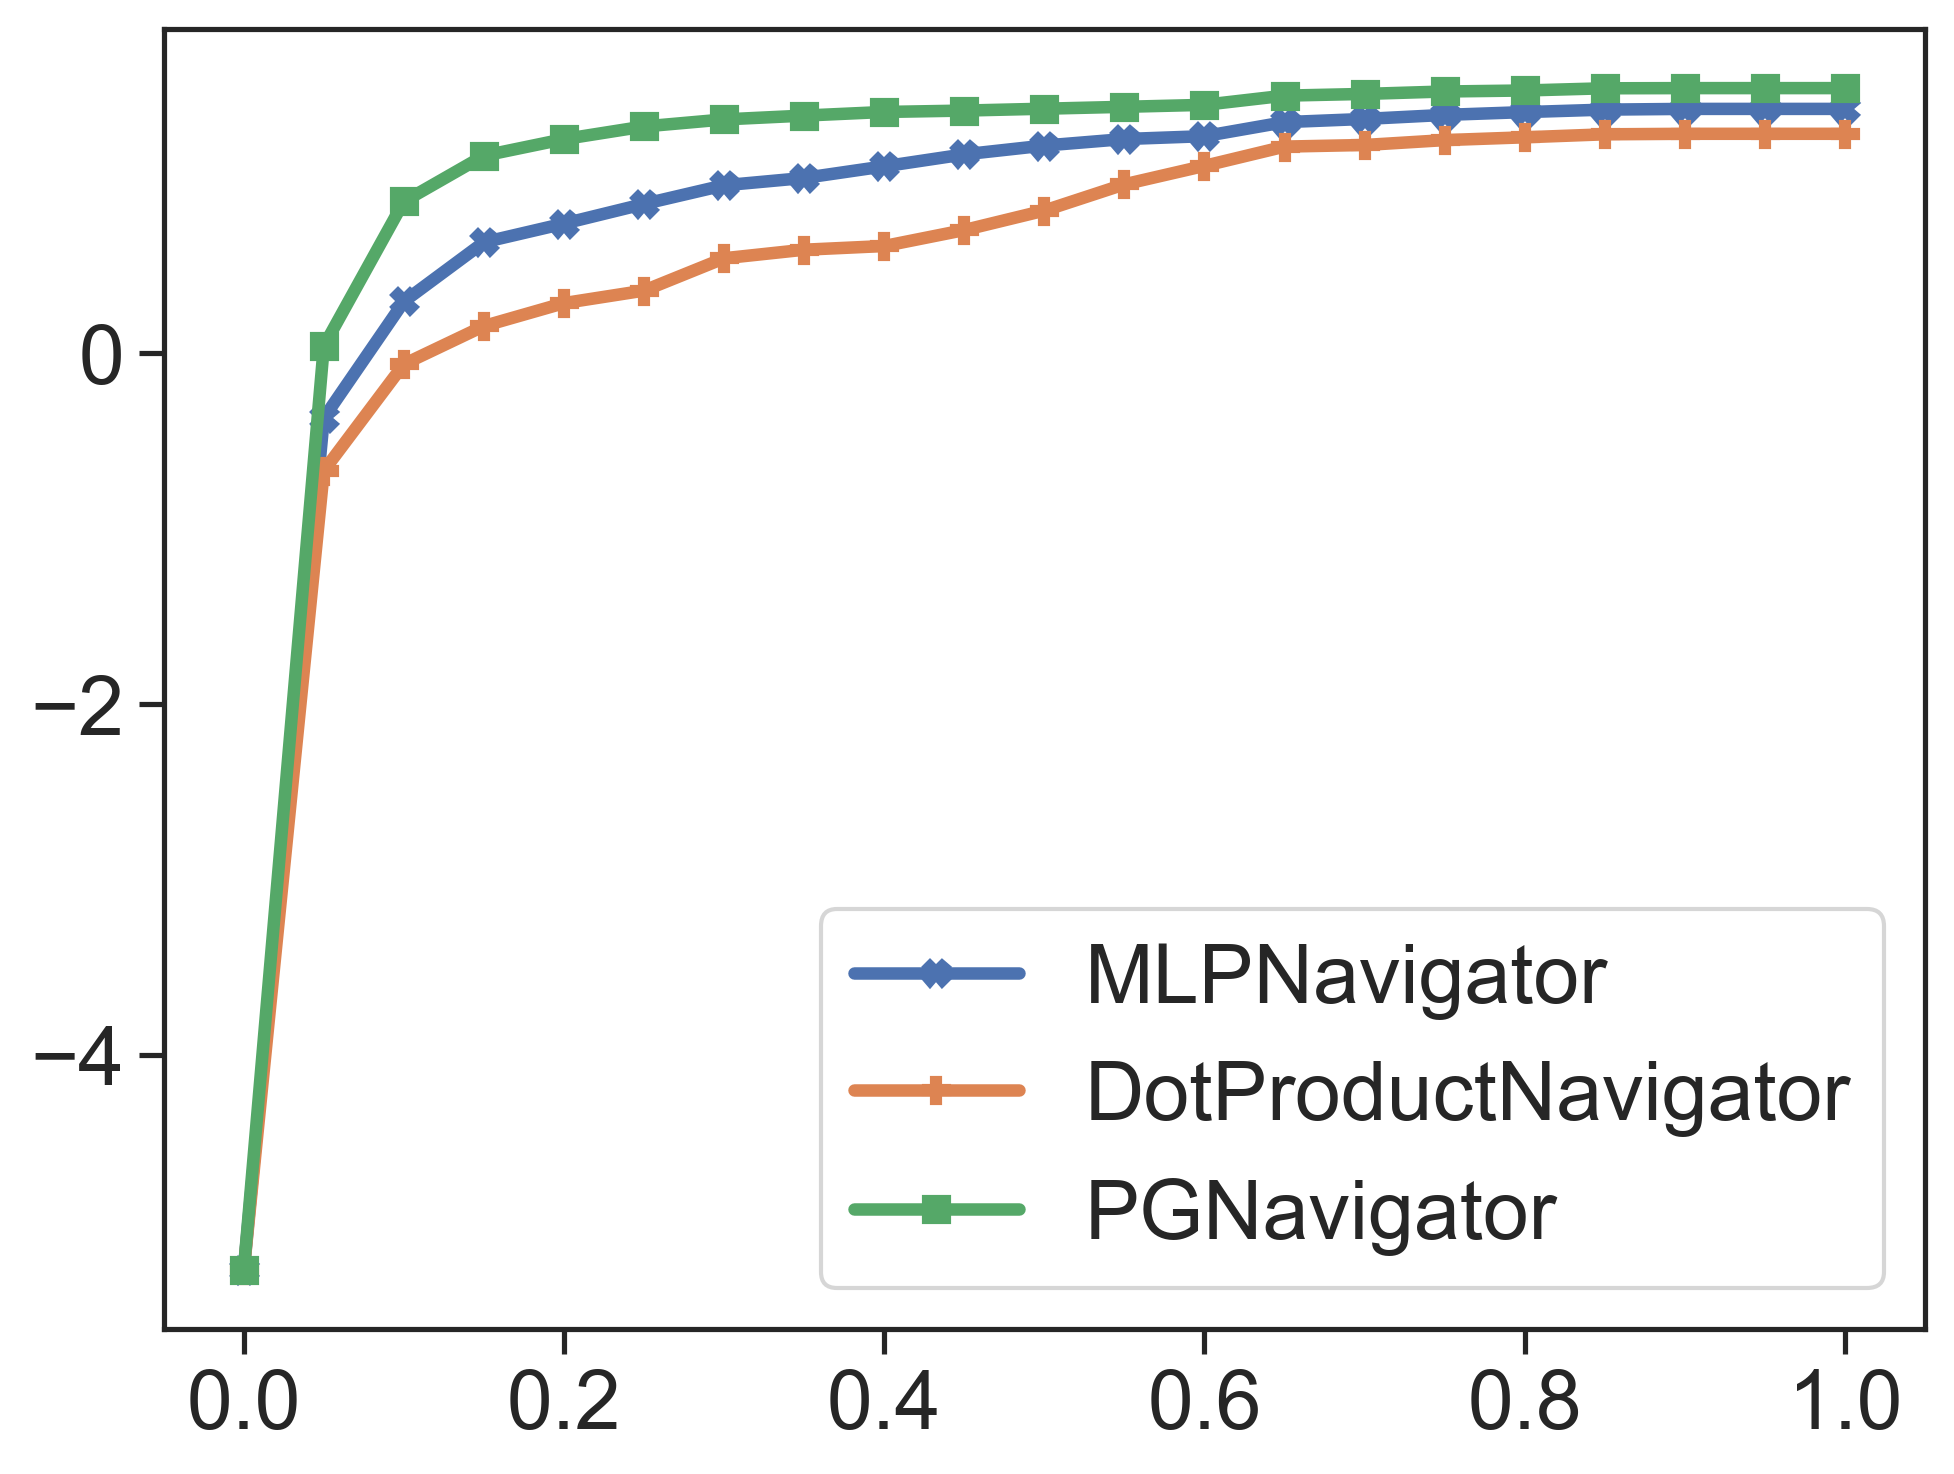

In [221]:
tgat_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_mlp_true_pg_positive_th20.csv",
            "tgat_wikipedia_attn_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgat_wikipedia_pbone_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgat_wikipedia_pg_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_dot_true_pg_positive_th20.csv",
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_pg_true_pg_positive_th20.csv",
        ],
    )
}


tgat_wikipedia_tabs, tgat_wikipedia_best_fids, tgat_wikipedia_aufsc = read_tabs_plot(tgat_wikipedia_files, "tgat_wikipedia", plot_only_og)
plot_navigators(tgat_wikipedia_tabs, "tgat_wikipedia")

## Reddit

Best Fid: {'xtg': 1.1622504767030477, 'attn': 0.47500729106366635, 'pbone': 1.2258510687202215, 'pg': 0.4785703634470701, 'xtg-d': 1.2233345153182744, 'xtg-og': 1.1554385360330344}
AUFSC: {'xtg': 0.36793317848630247, 'attn': -0.9084230695534498, 'pbone': 0.8738694724105299, 'pg': -0.8214949438832699, 'xtg-d': 0.5960841231141238, 'xtg-og': 0.4440228421706707}


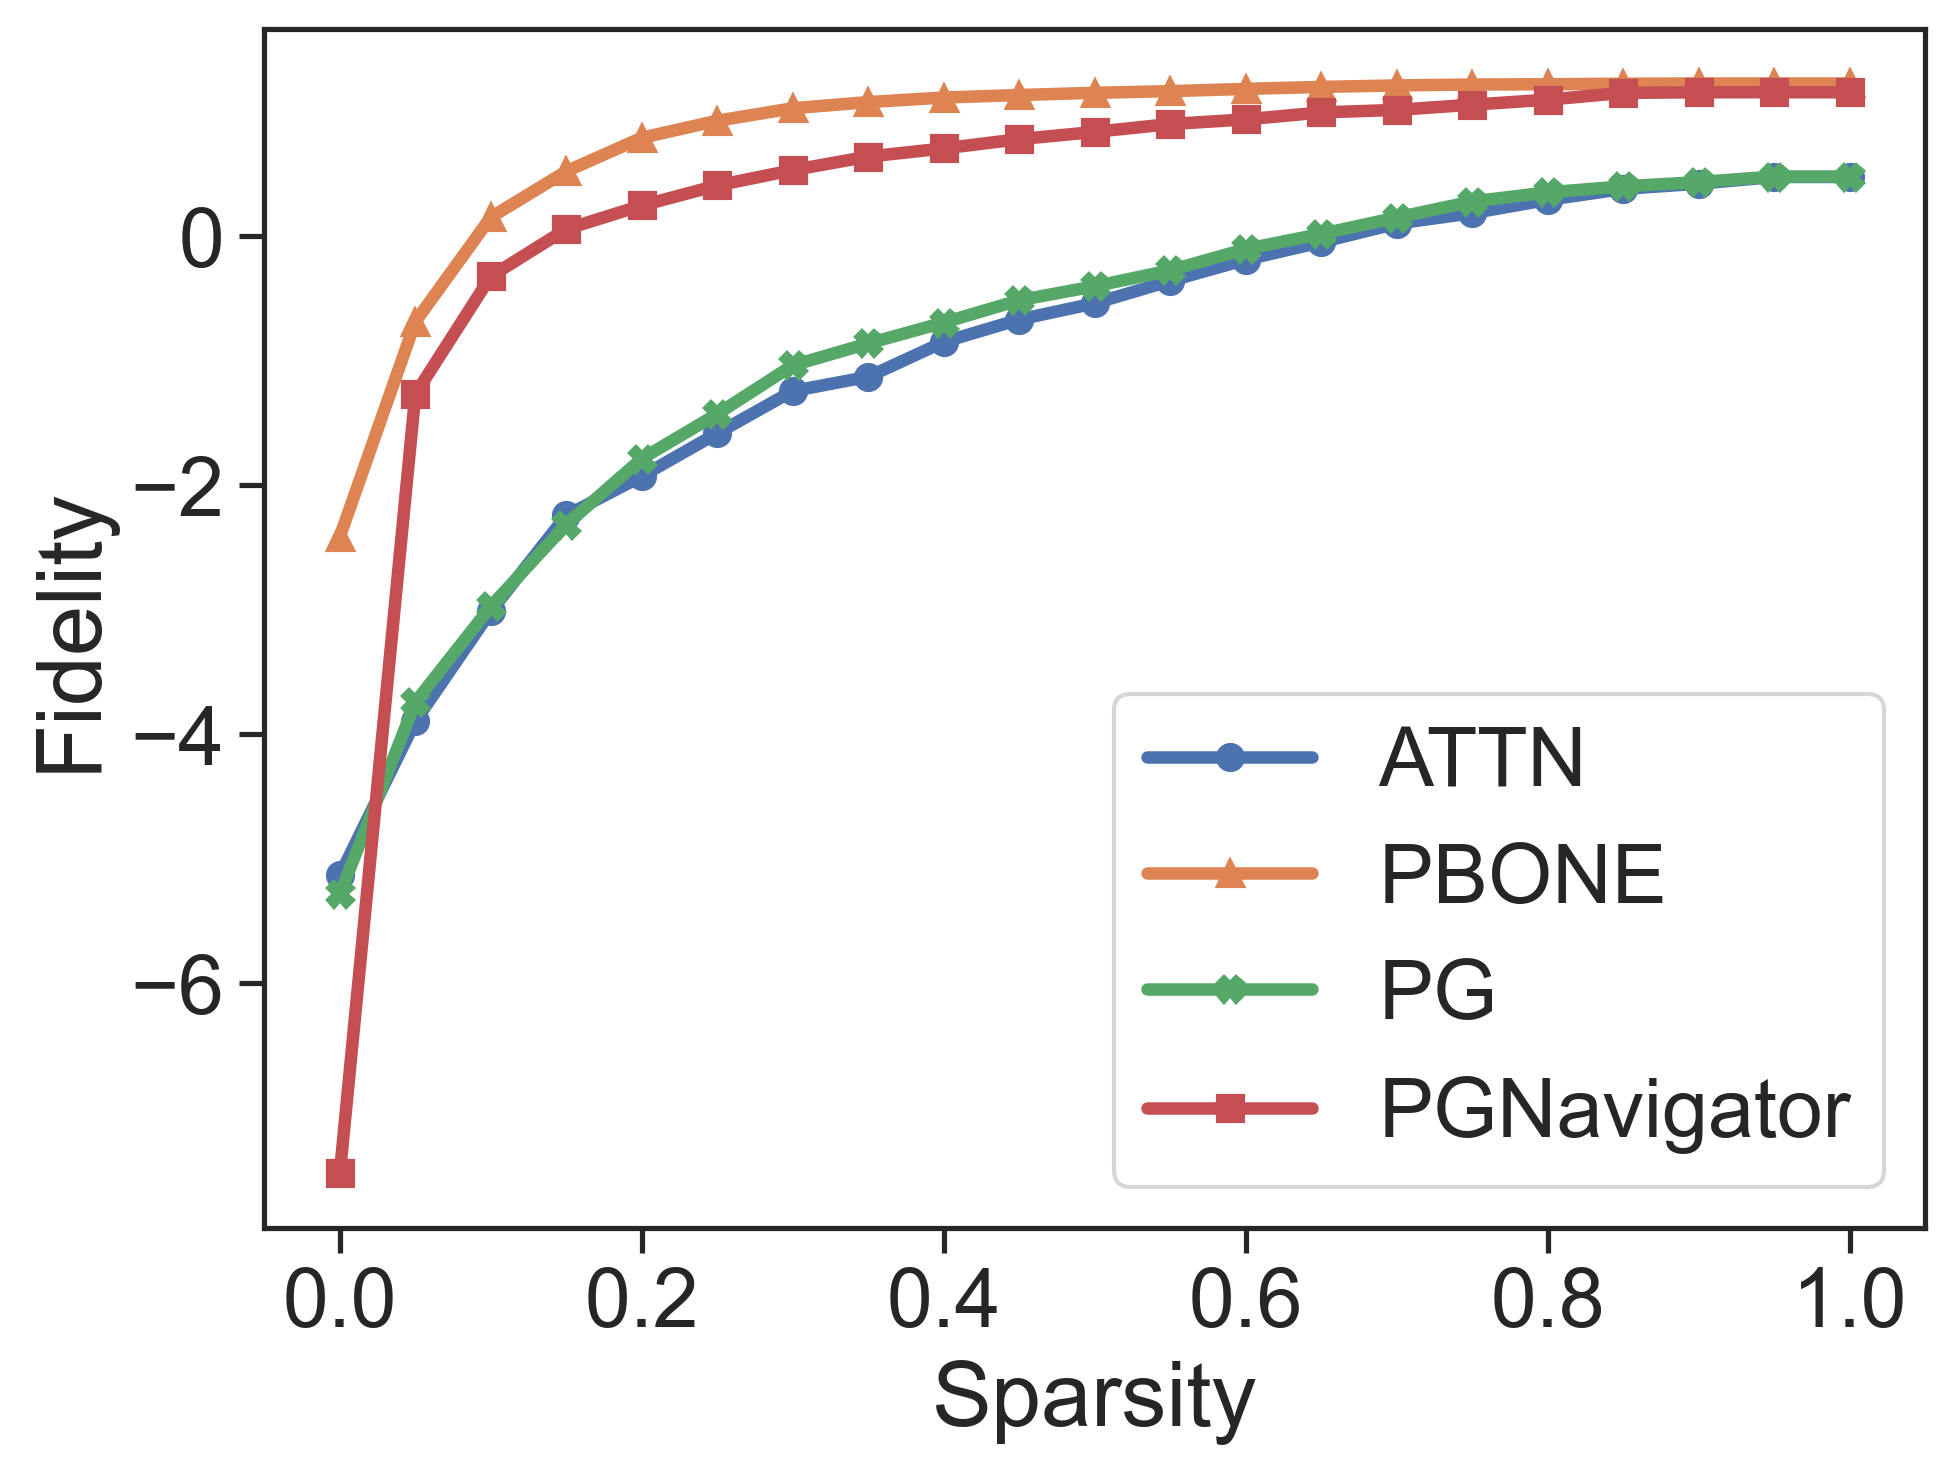

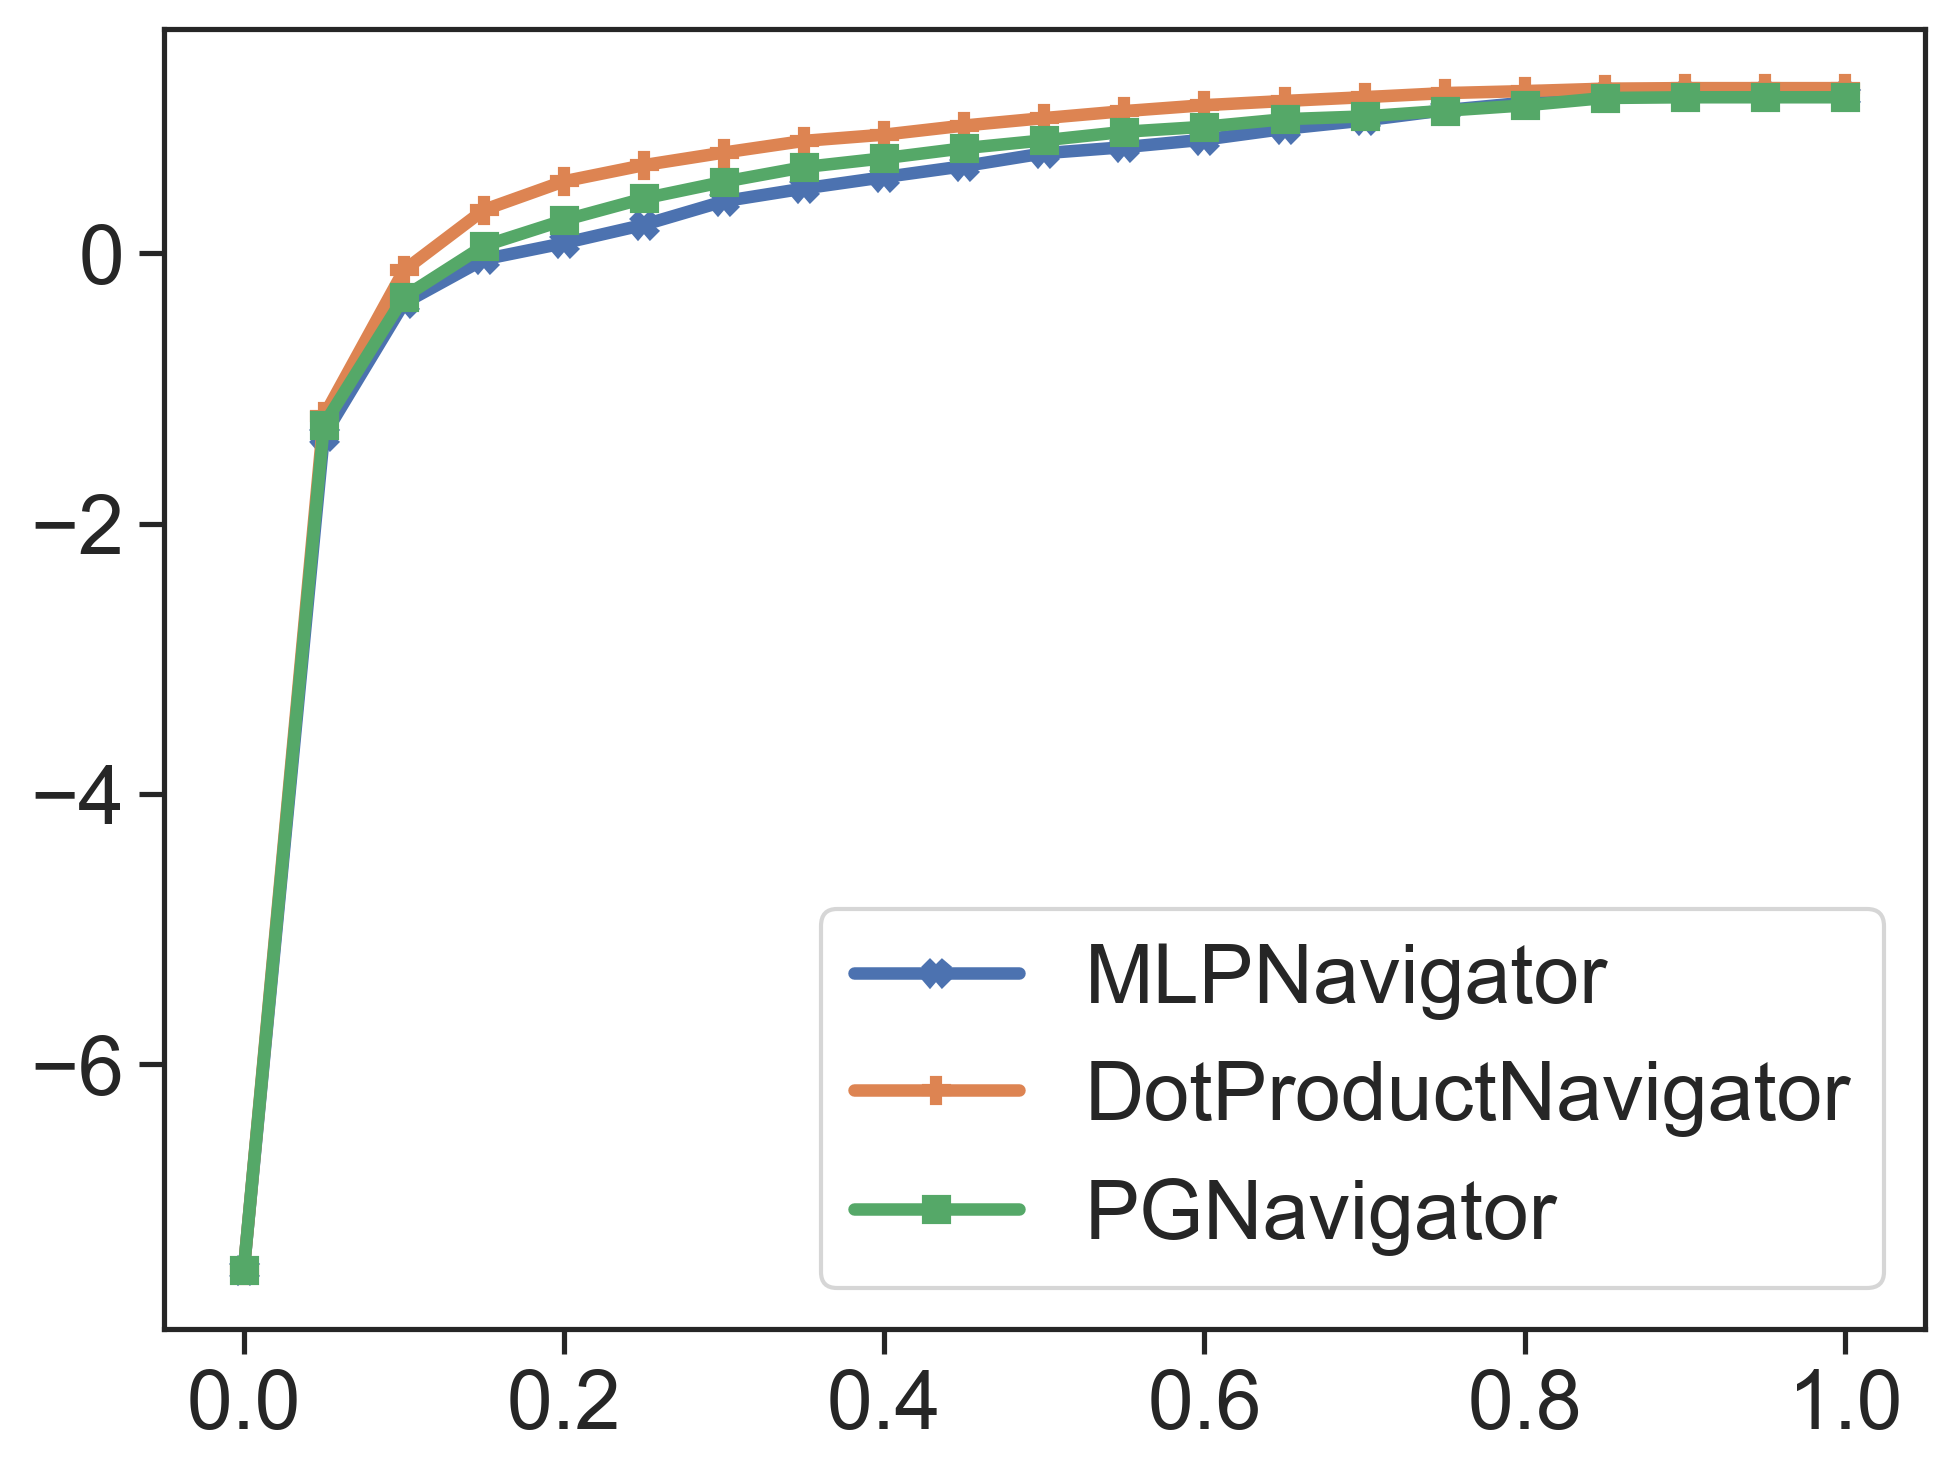

In [222]:
tgat_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_mlp_true_pg_positive_th20.csv",
            "tgat_reddit_attn_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgat_reddit_pbone_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgat_reddit_pg_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_dot_true_pg_positive_th20.csv",
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_pg_true_pg_positive_th20.csv",
        ],
    )
}

tgat_reddit_tabs, tgat_reddit_best_fids, tgat_reddit_aufsc = read_tabs_plot(tgat_reddit_files, "tgat_reddit", plot_only_og)
plot_navigators(tgat_reddit_tabs, "tgat_reddit")

## Simulate V1

Best Fid: {'xtg': 1.1817334110245985, 'attn': 0.5297345367132449, 'pbone': 0.9399075312357322, 'pg': 0.619684517675755, 'xtg-d': 0.9874230894972297, 'xtg-og': 1.1551832115533305}
AUFSC: {'xtg': 0.7768883111722328, 'attn': 0.08210299855792051, 'pbone': 0.5372941589896001, 'pg': -0.32199718804628236, 'xtg-d': 0.46933882975695185, 'xtg-og': 0.8424836973057074}


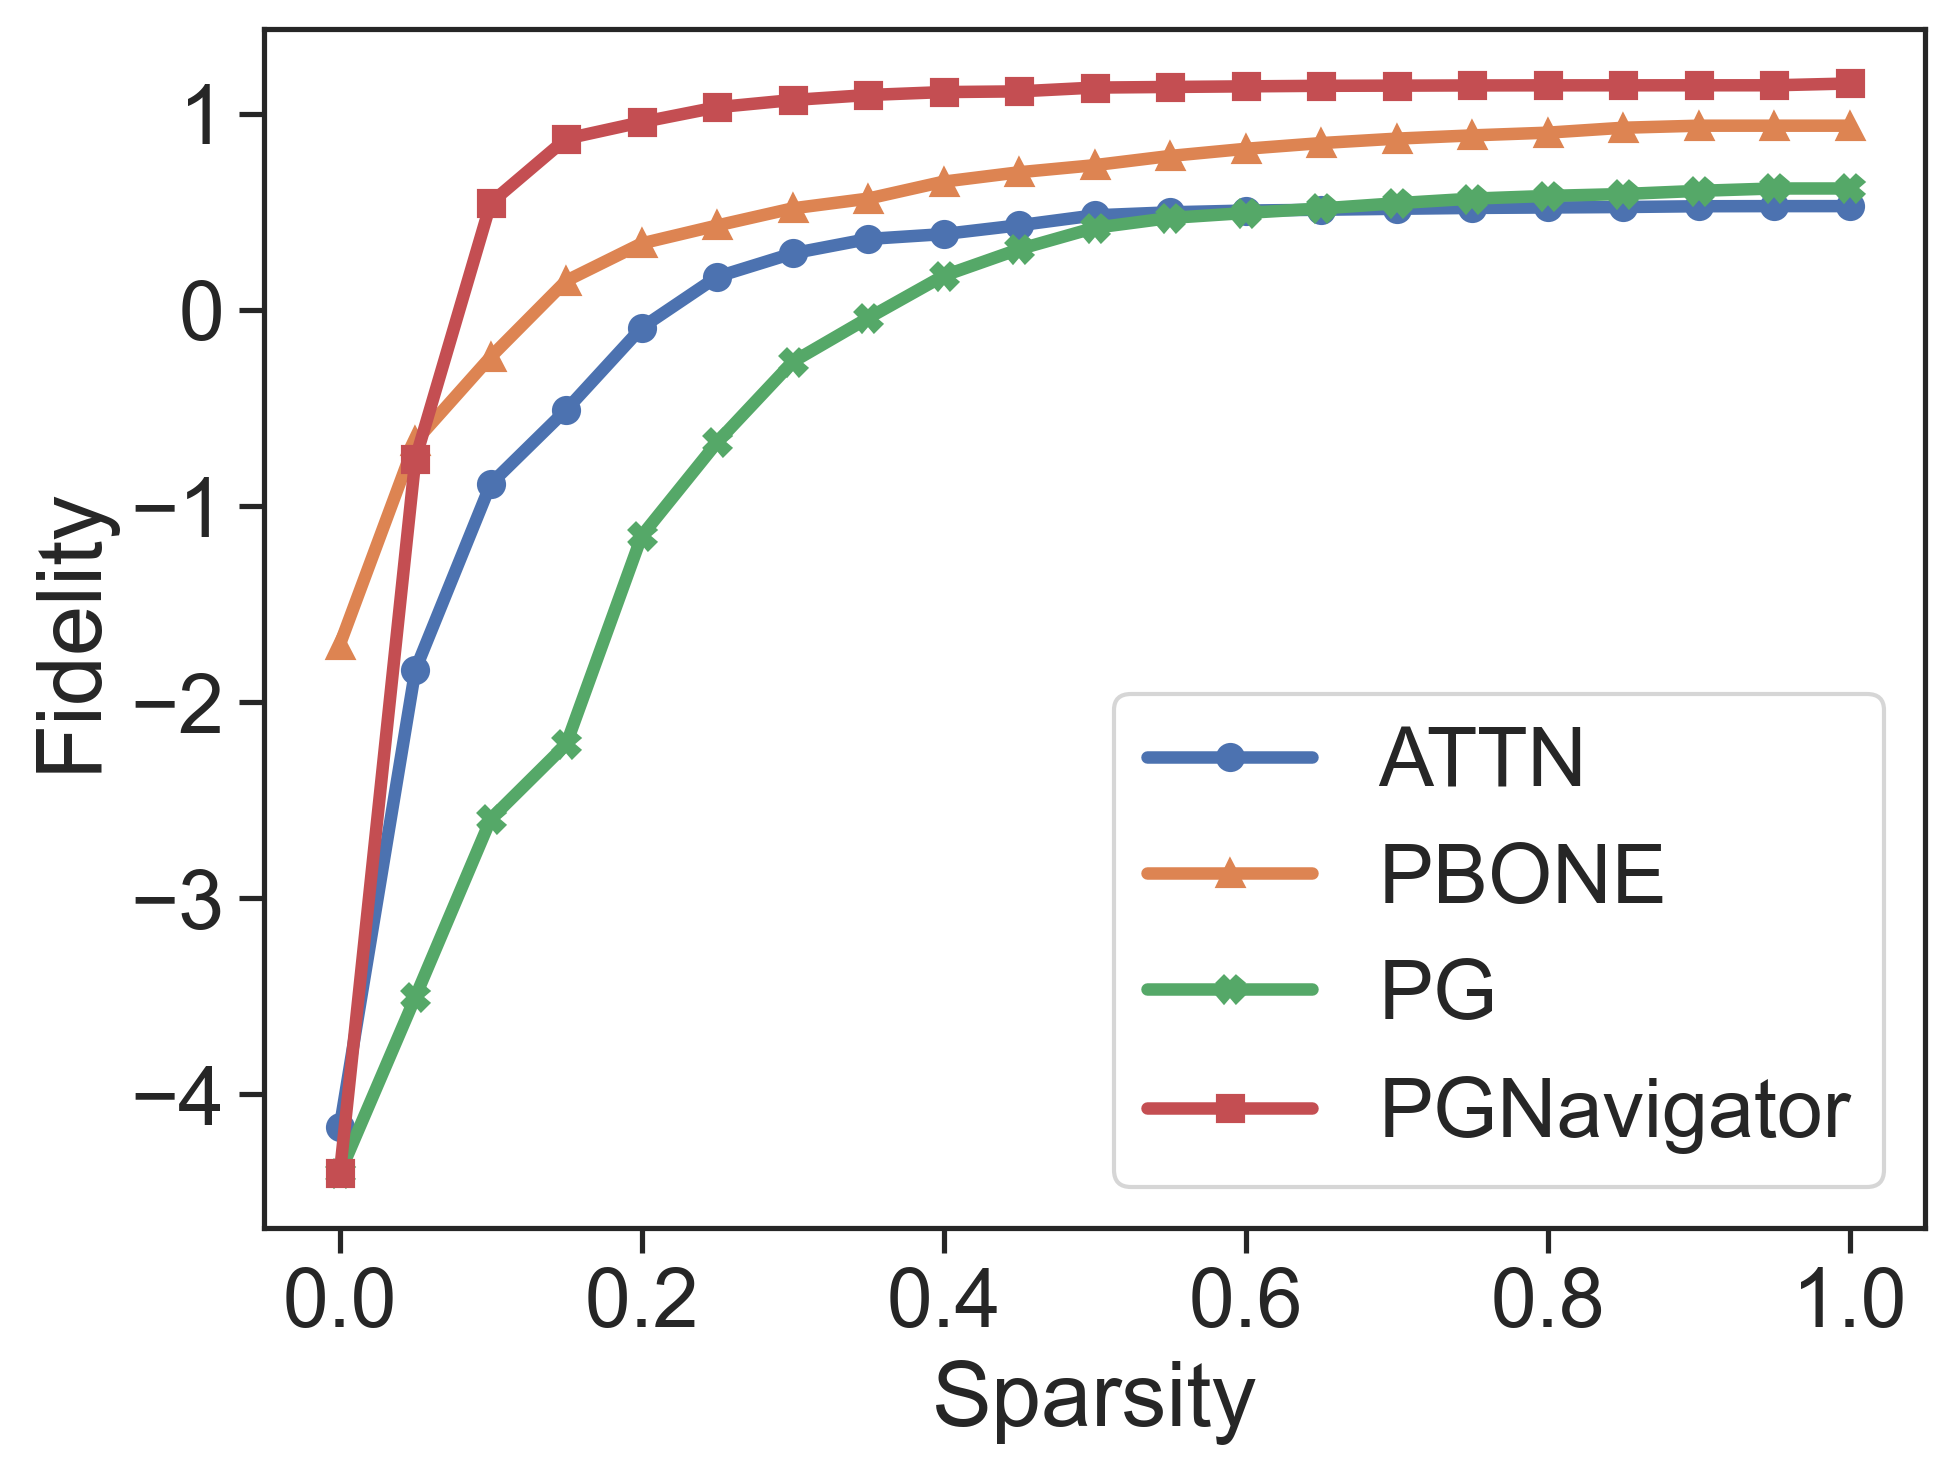

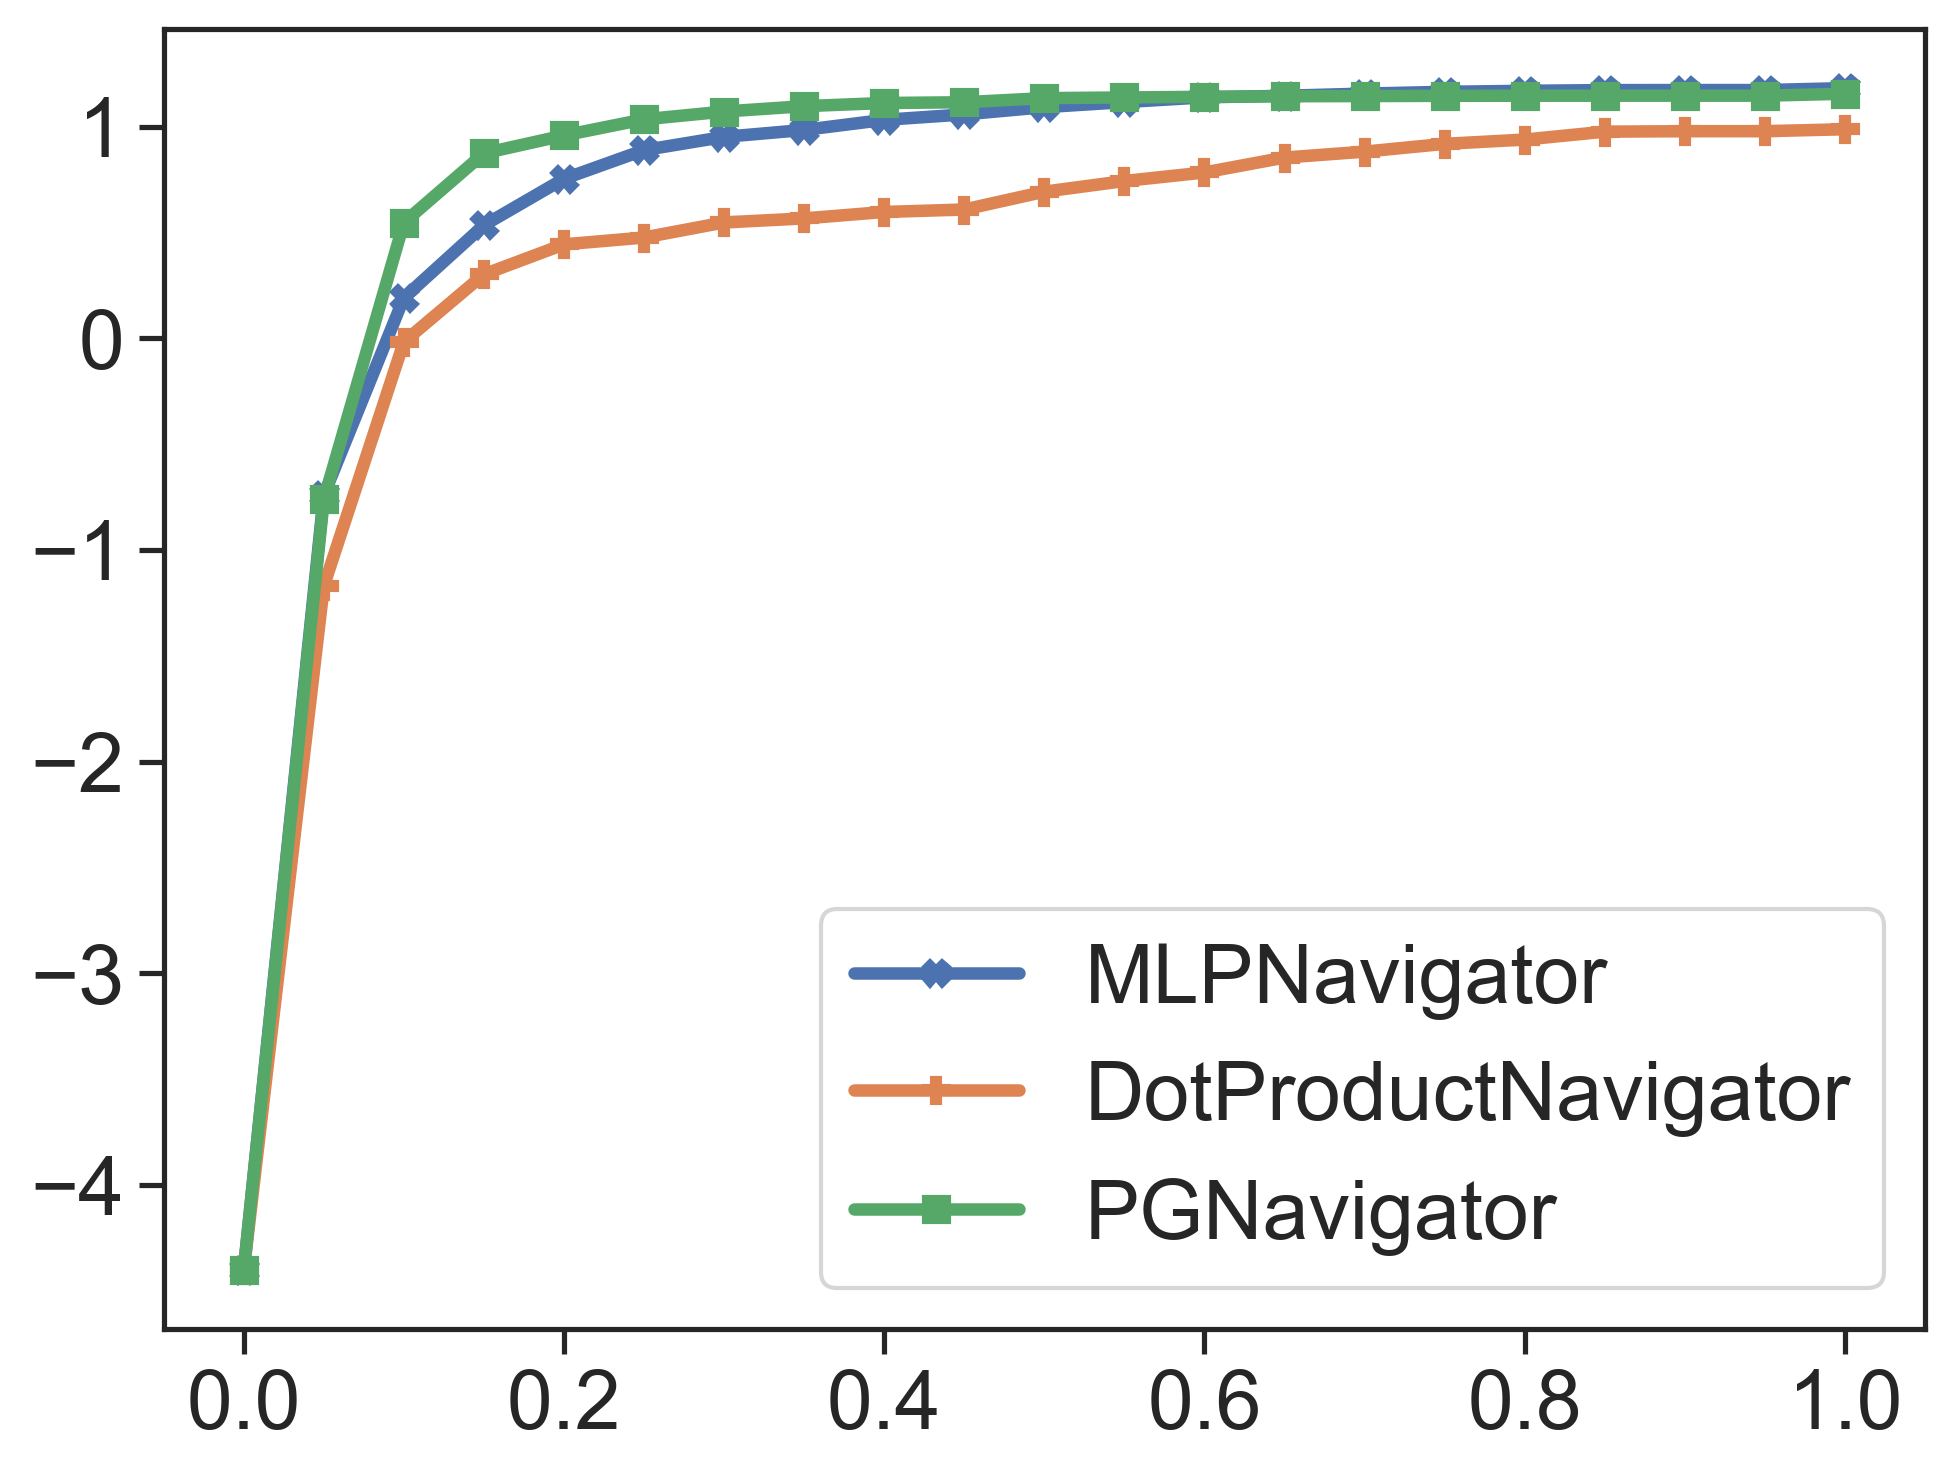

In [223]:
tgat_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_mlp_true_pg_positive_th20.csv",
            "tgat_simulate_v1_attn_explainer_tg_3_to_15902_eval_th20.csv",
            "tgat_simulate_v1_pbone_explainer_tg_3_to_15902_eval_th20.csv",
            "tgat_simulate_v1_pg_explainer_tg_3_to_15902_eval_th20.csv",
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_dot_true_pg_positive_th20.csv",
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgat_simulate_v1_tabs, tgat_simulate_v1_best_fids, tgat_simulate_v1_aufsc = read_tabs_plot(tgat_simulate_v1_files, "tgat_simulate_v1", plot_only_og)
plot_navigators(tgat_simulate_v1_tabs, "tgat_simulate_v1")

## Simulate V2

Best Fid: {'xtg': 0.7947402311598554, 'attn': 0.04089362656368927, 'pbone': 0.6585348863519874, 'pg': 0.7181881679331555, 'xtg-d': 0.7834118121102744, 'xtg-og': 0.7887831419414165}
AUFSC: {'xtg': 0.6050593150250029, 'attn': -0.11503232771202046, 'pbone': 0.3468187830173502, 'pg': 0.21022044354867114, 'xtg-d': 0.7127872711978853, 'xtg-og': 0.7195822088029601}


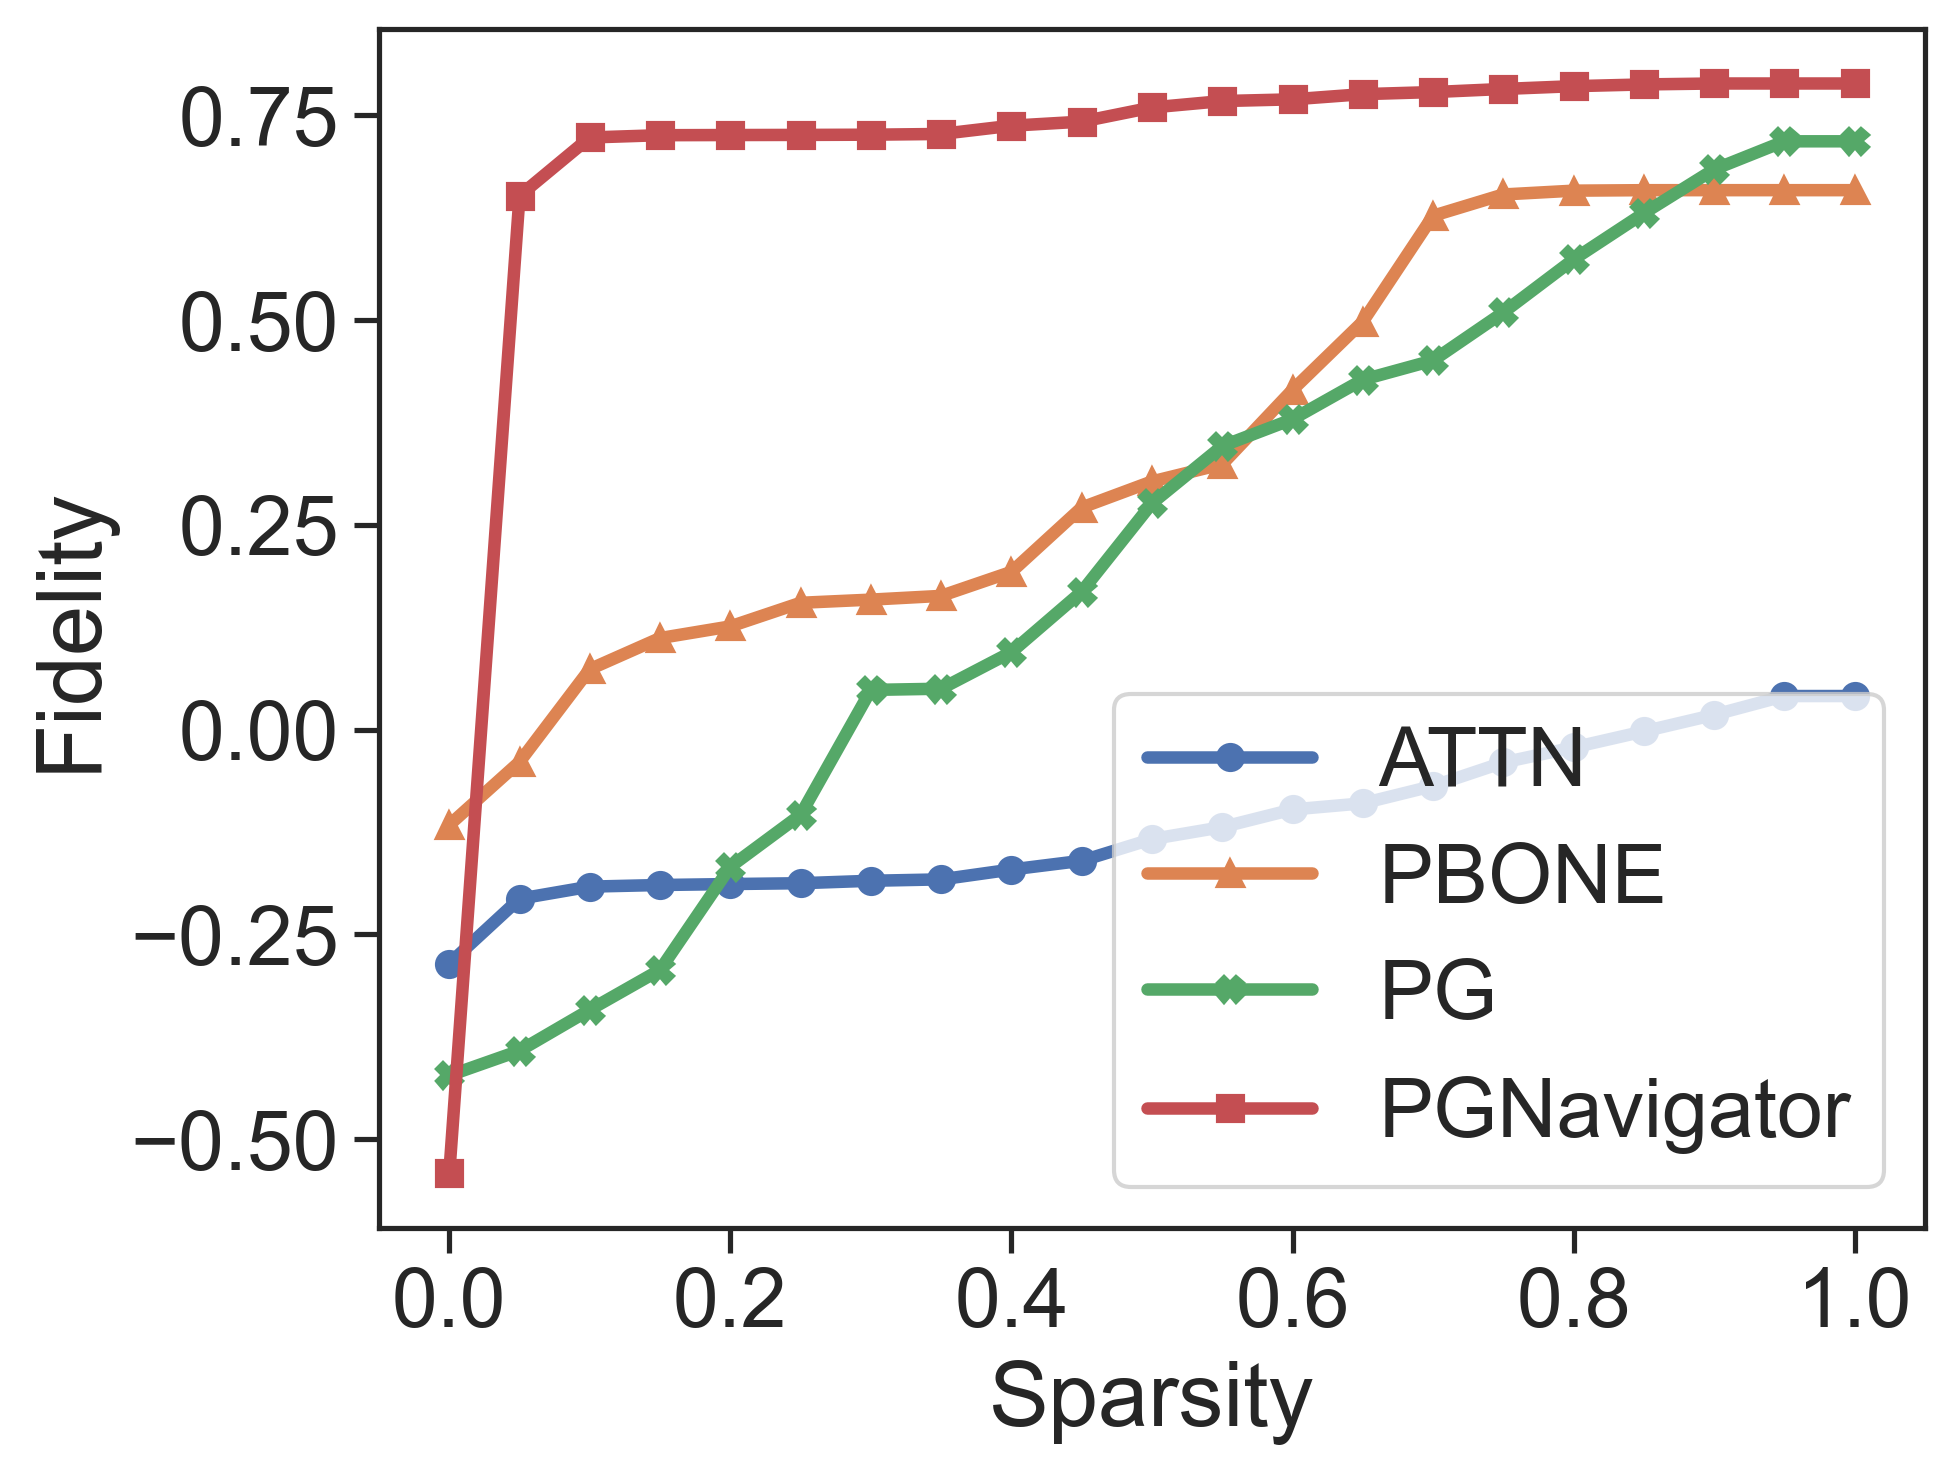

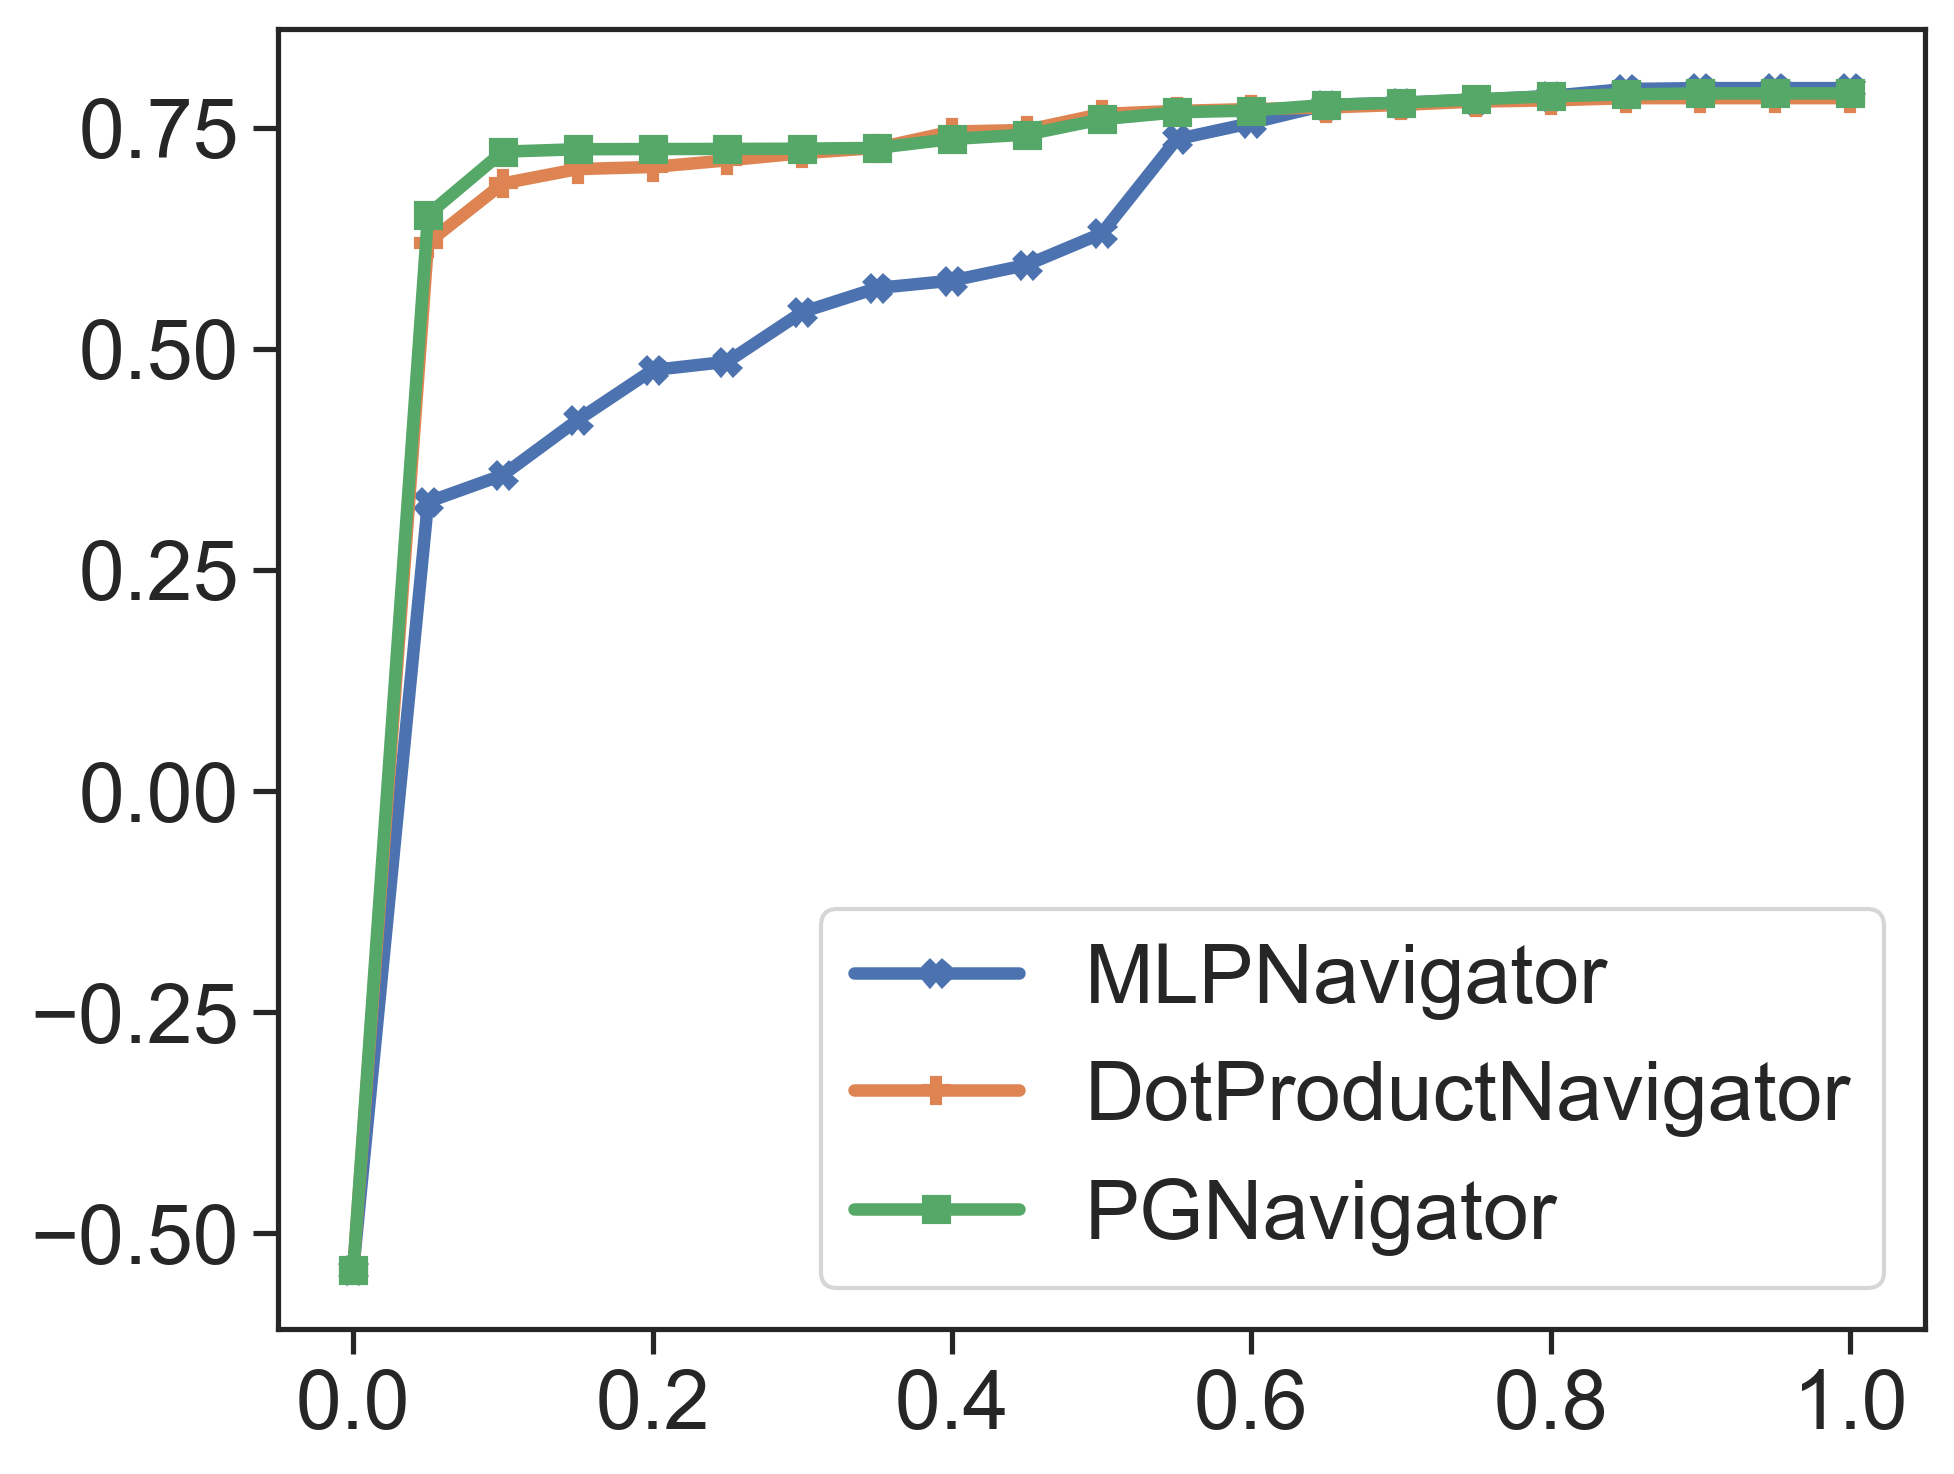

In [224]:
tgat_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_mlp_true_pg_positive_th20.csv",
            "tgat_simulate_v2_attn_explainer_tg_3_to_21752_eval_th20.csv",
            "tgat_simulate_v2_pbone_explainer_tg_3_to_21752_eval_th20.csv",
            "tgat_simulate_v2_pg_explainer_tg_3_to_21752_eval_th20.csv",
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_dot_true_pg_positive_th20.csv",
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgat_simulate_v2_tabs, tgat_simulate_v2_best_fids, tgat_simulate_v2_aufsc = read_tabs_plot(tgat_simulate_v2_files, "tgat_simulate_v2", plot_only_og)
plot_navigators(tgat_simulate_v2_tabs, "tgat_simulate_v2")

# TGN
## Wikipedia

Best Fid: {'xtg': 0.9347367412596941, 'attn': 0.5968533096462488, 'pbone': 0.734511648491025, 'pg': 0.5498718140274286, 'xtg-d': 0.9080627510696649, 'xtg-og': 0.920611462071538}
AUFSC: {'xtg': 0.49106371287442735, 'attn': 0.4181079647671431, 'pbone': 0.4323083633389324, 'pg': -0.418762693958357, 'xtg-d': 0.3711702890824526, 'xtg-og': 0.6803379071932285}


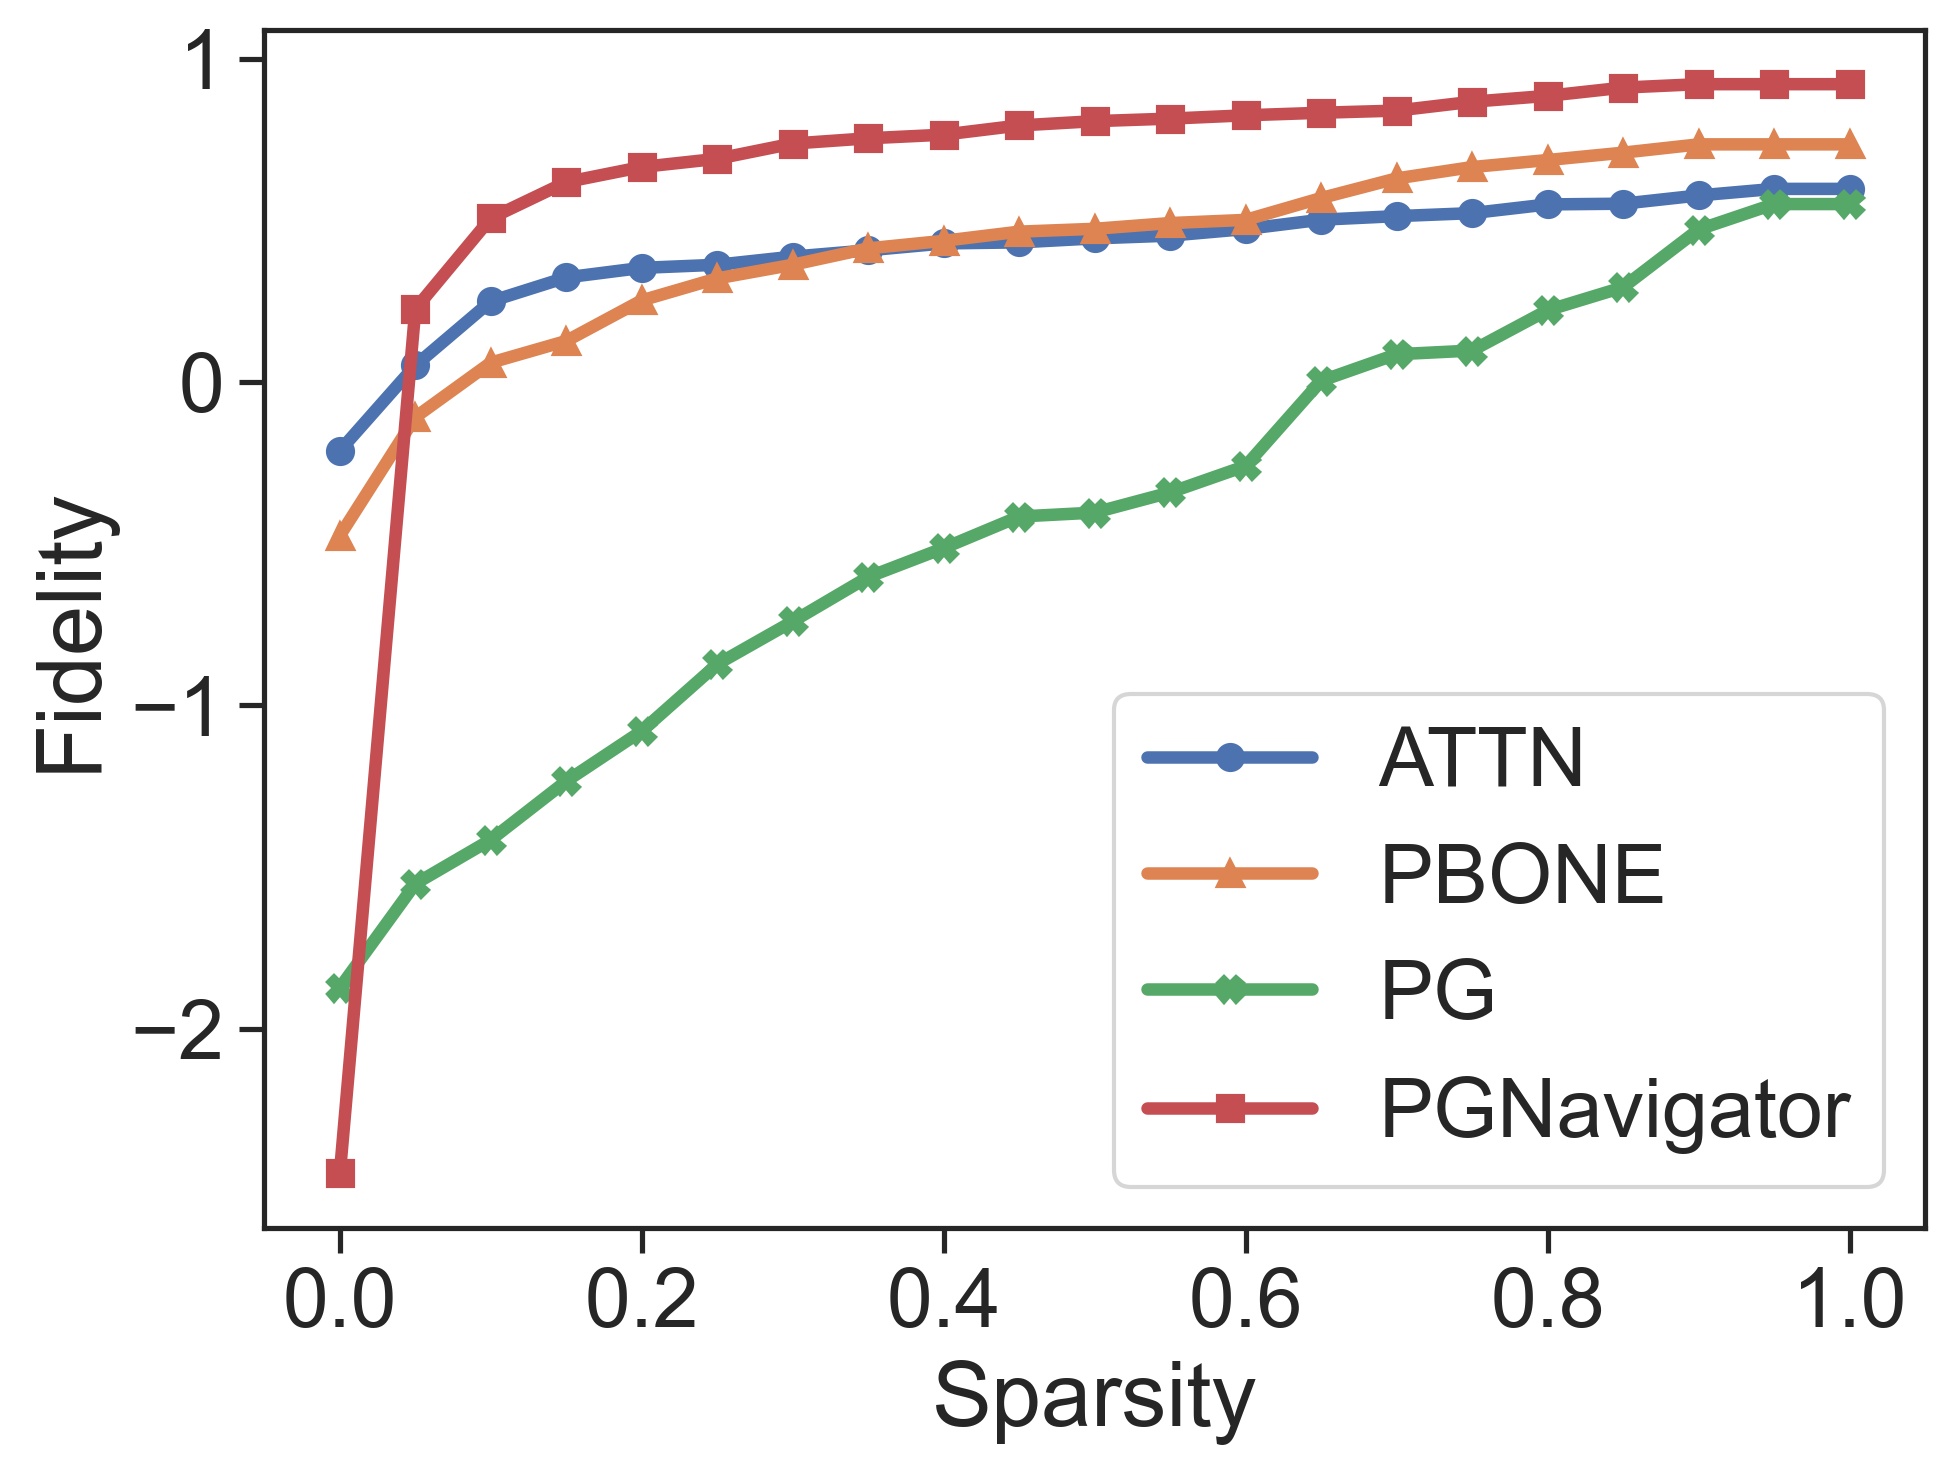

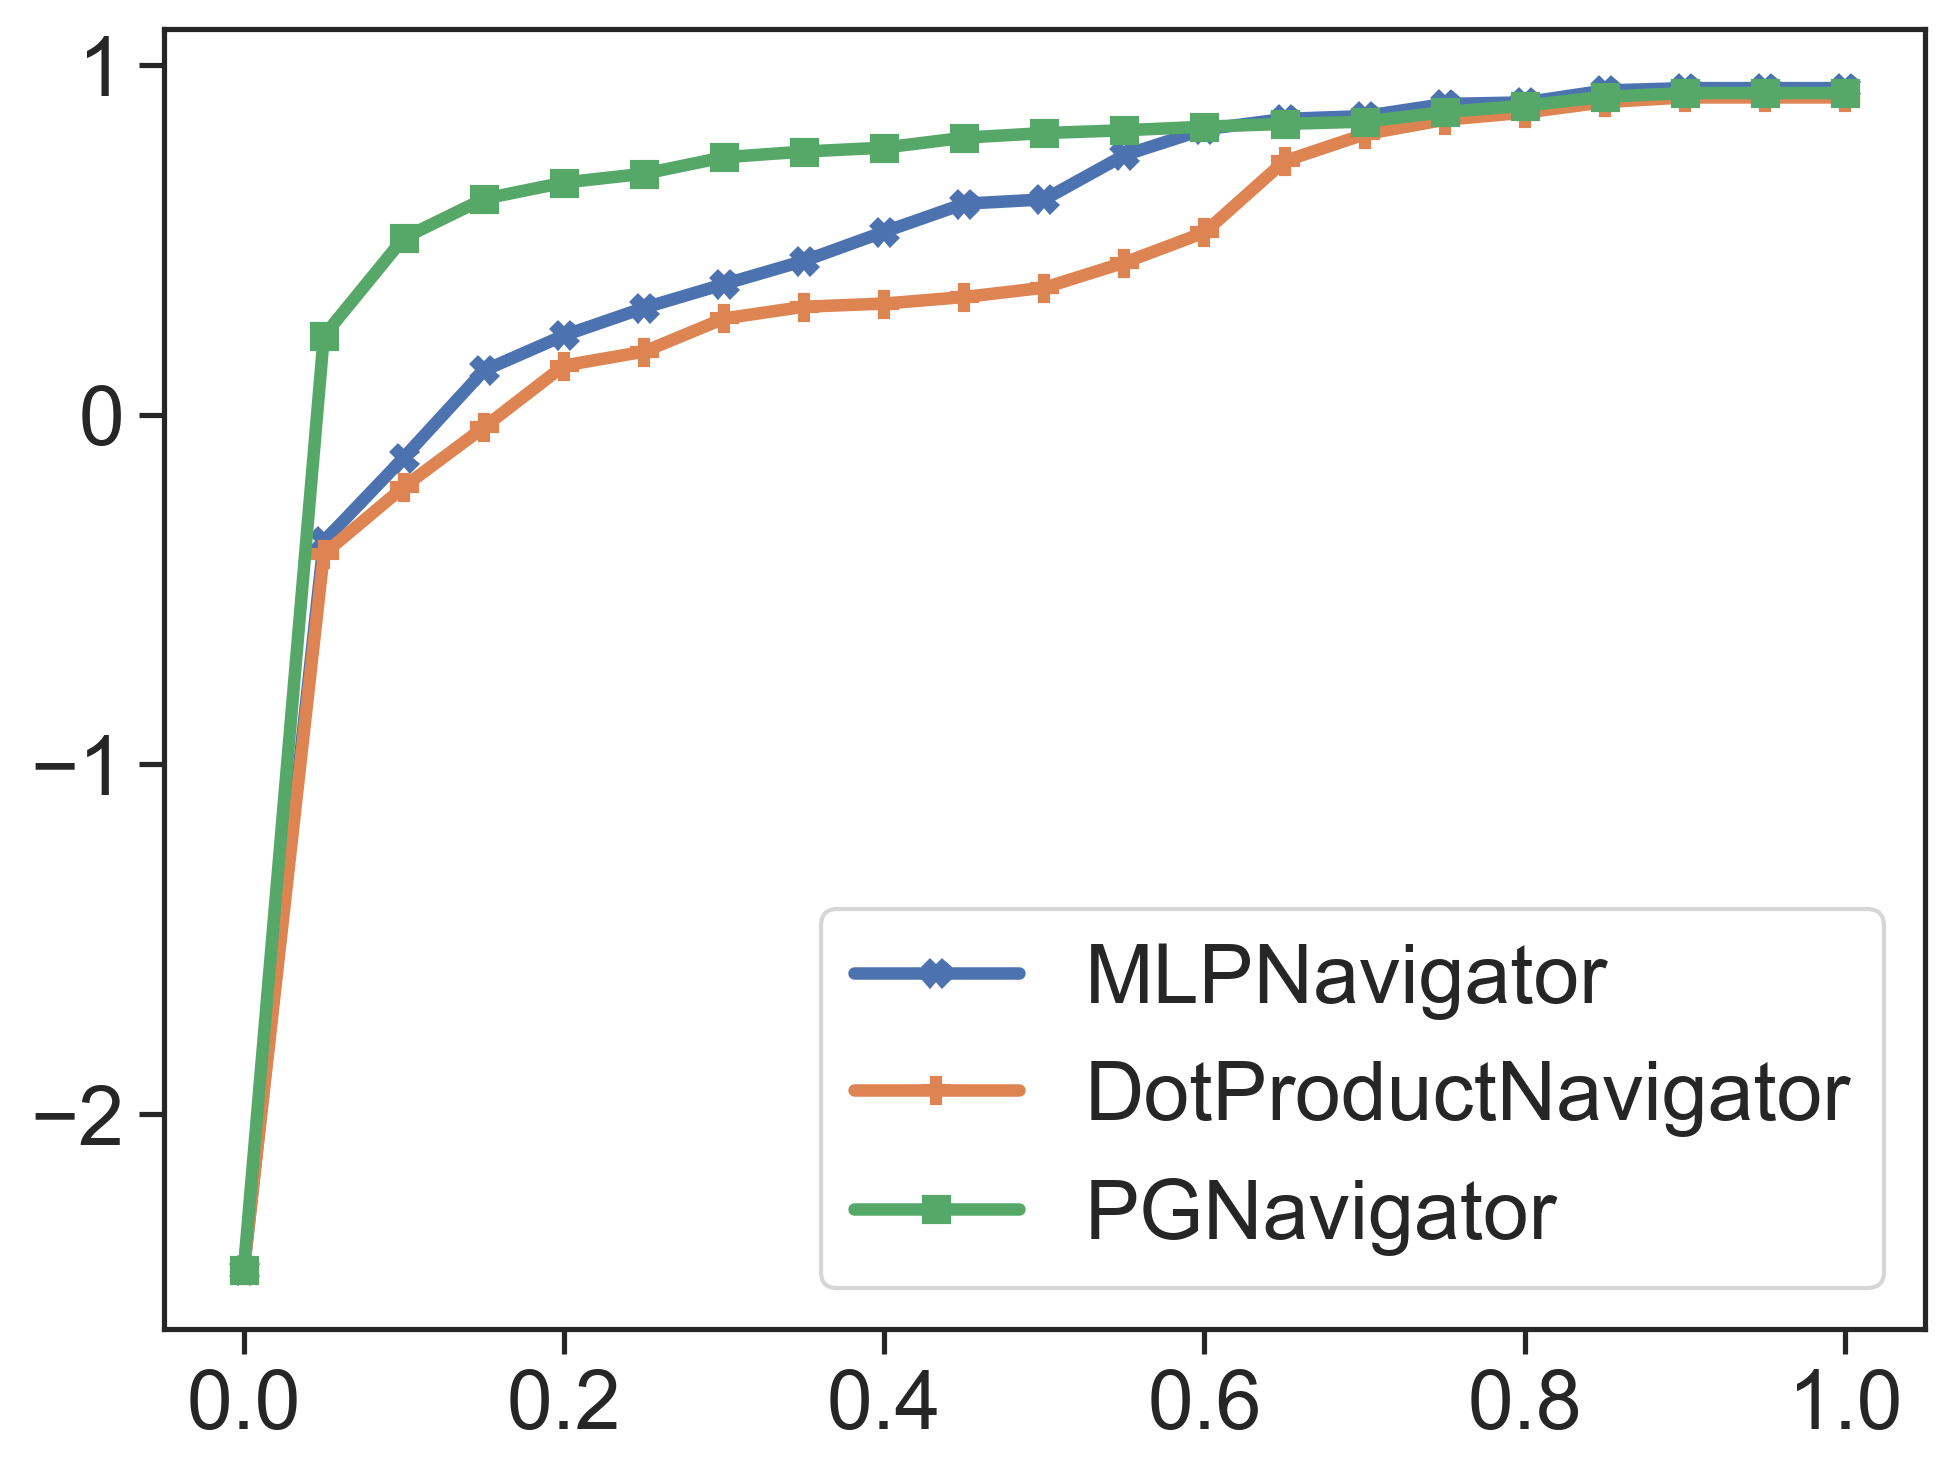

In [225]:
tgn_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_mlp_true_pg_positive_th20.csv",
            "tgn_wikipedia_attn_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgn_wikipedia_pbone_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgn_wikipedia_pg_explainer_tg_110314_to_155151_eval_th20.csv",
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_dot_true_pg_positive_th20.csv",
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_wikipedia_tabs, tgn_wikipedia_best_fids, tgn_wikipedia_aufsc = read_tabs_plot(tgn_wikipedia_files, "tgn_wikipedia", plot_only_og)
plot_navigators(tgn_wikipedia_tabs, "tgn_wikipedia")

## Reddit

Best Fid: {'xtg': 0.255969266295433, 'attn': 0.1809014984965324, 'pbone': 0.26522993773221964, 'pg': 0.1501991710066795, 'xtg-d': 0.2646820983290672, 'xtg-og': 0.2654505705088377}
AUFSC: {'xtg': -1.4603407012969258, 'attn': -1.4565657264180483, 'pbone': -0.6164062883388252, 'pg': -2.179182027122006, 'xtg-d': -1.2845651247836651, 'xtg-og': -1.0561136454176157}


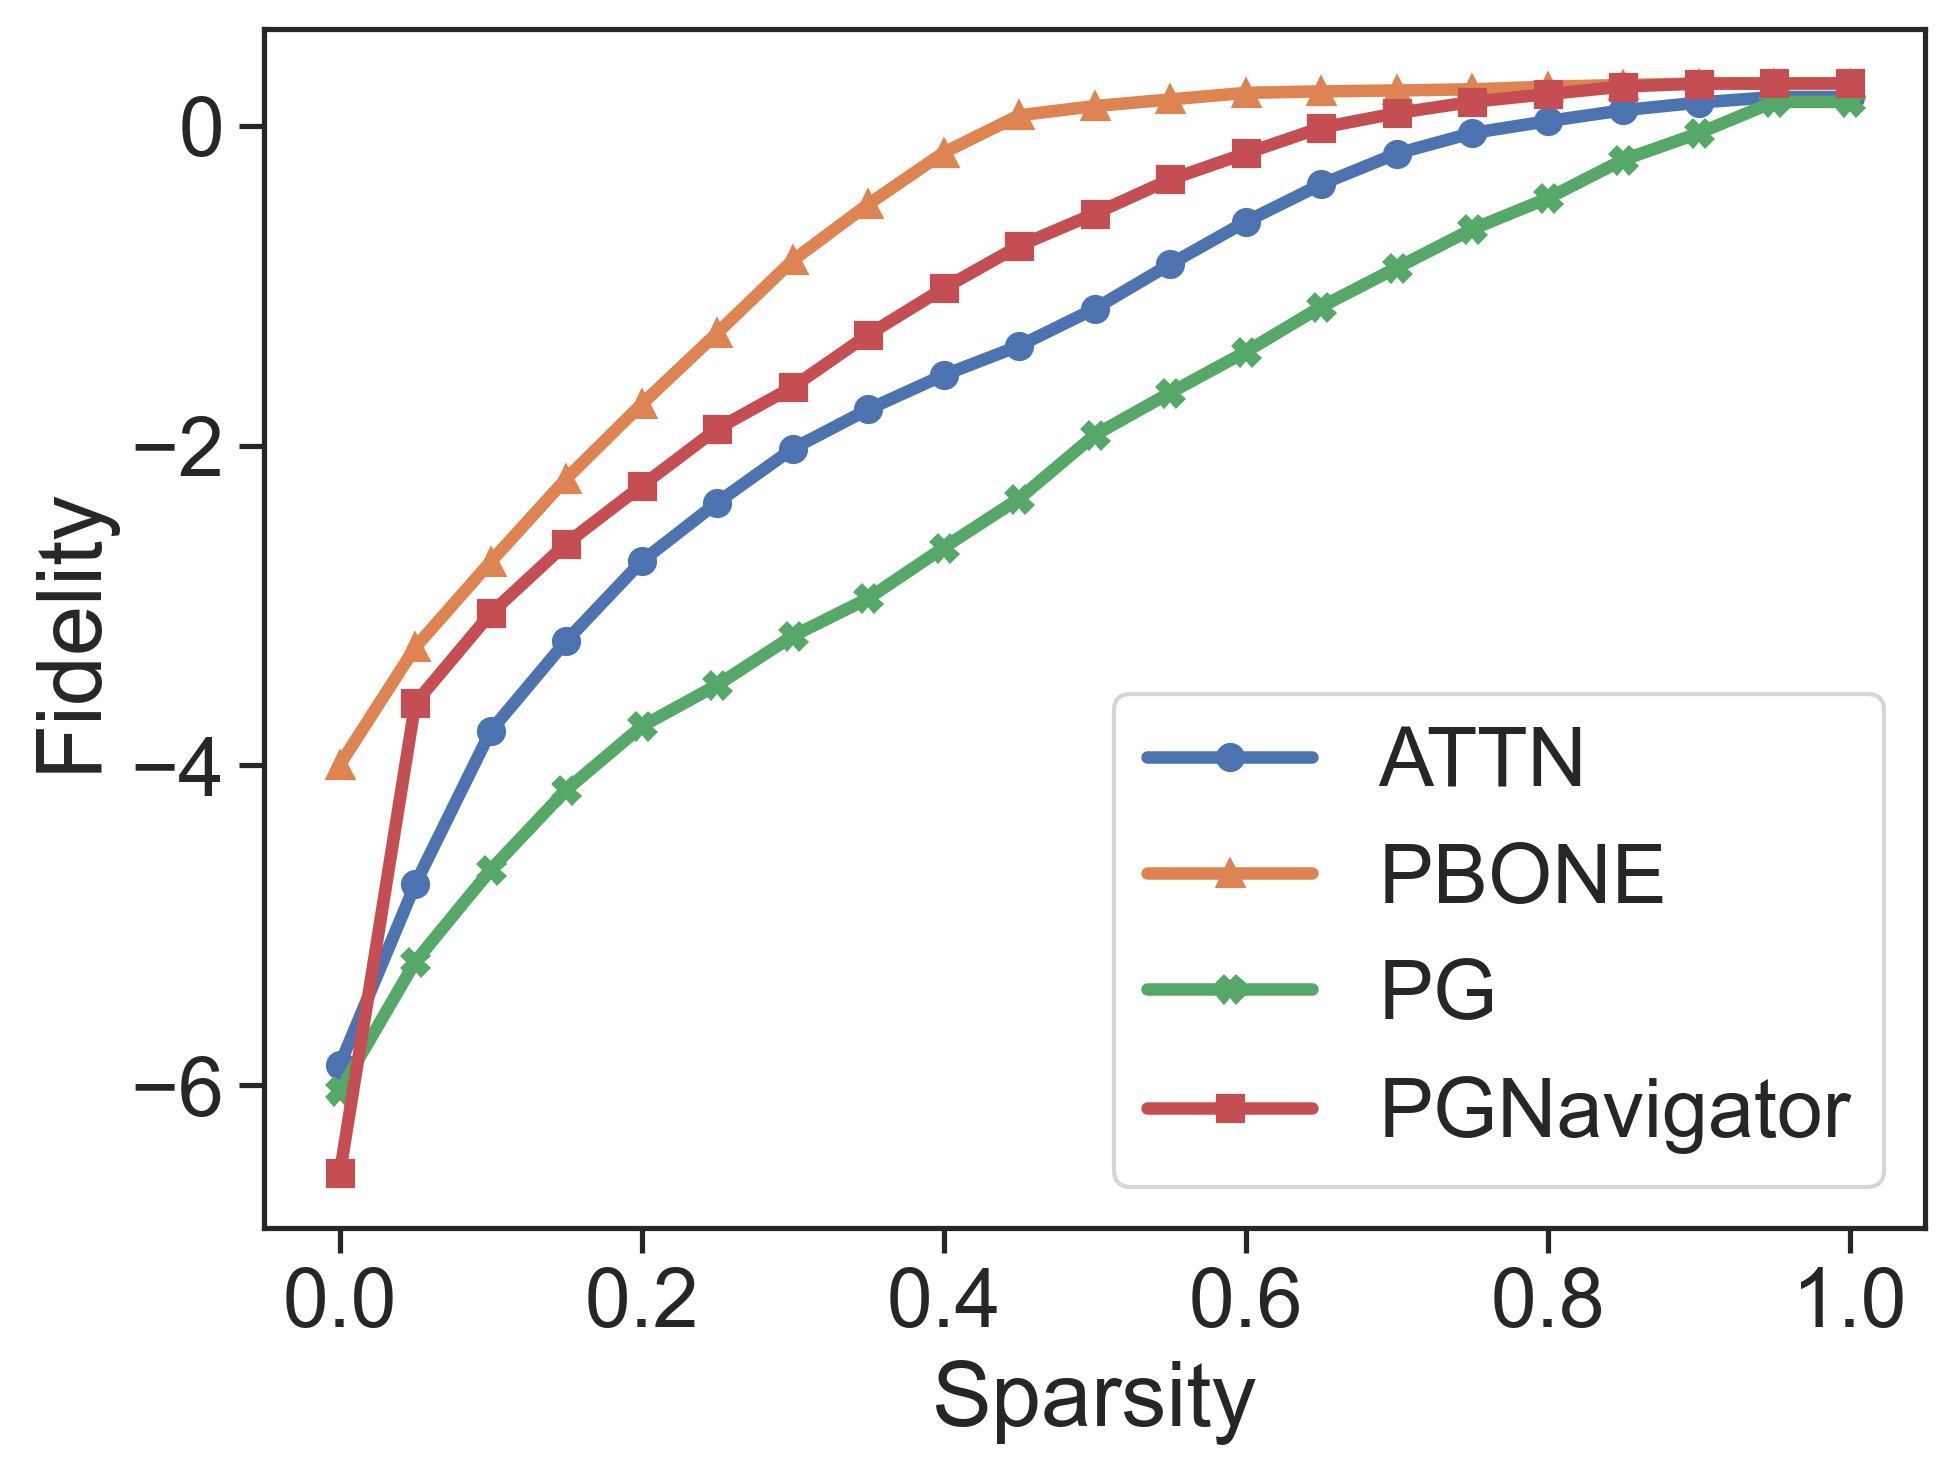

In [226]:
tgn_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_mlp_true_pg_positive_th20.csv",
            "tgn_reddit_attn_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgn_reddit_pbone_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgn_reddit_pg_explainer_tg_470920_to_663534_eval_th20.csv",
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_dot_true_pg_positive_th20.csv",
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_reddit_tabs, tgn_reddit_best_fids, tgn_reddit_aufsc = read_tabs_plot(tgn_reddit_files, "tgn_reddit", plot_only_og)

## Simulate V1

Best Fid: {'xtg': 1.9075012358964658, 'attn': 1.4227898985731835, 'pbone': 1.677653220354342, 'pg': 1.3189938968303156, 'xtg-d': 1.3005282142583061, 'xtg-og': 1.820665313917048}
AUFSC: {'xtg': 1.493588796754678, 'attn': 0.7884101023422736, 'pbone': 0.7508773210440195, 'pg': -0.011088532560011854, 'xtg-d': 0.39844800935072056, 'xtg-og': 1.4673305029670394}


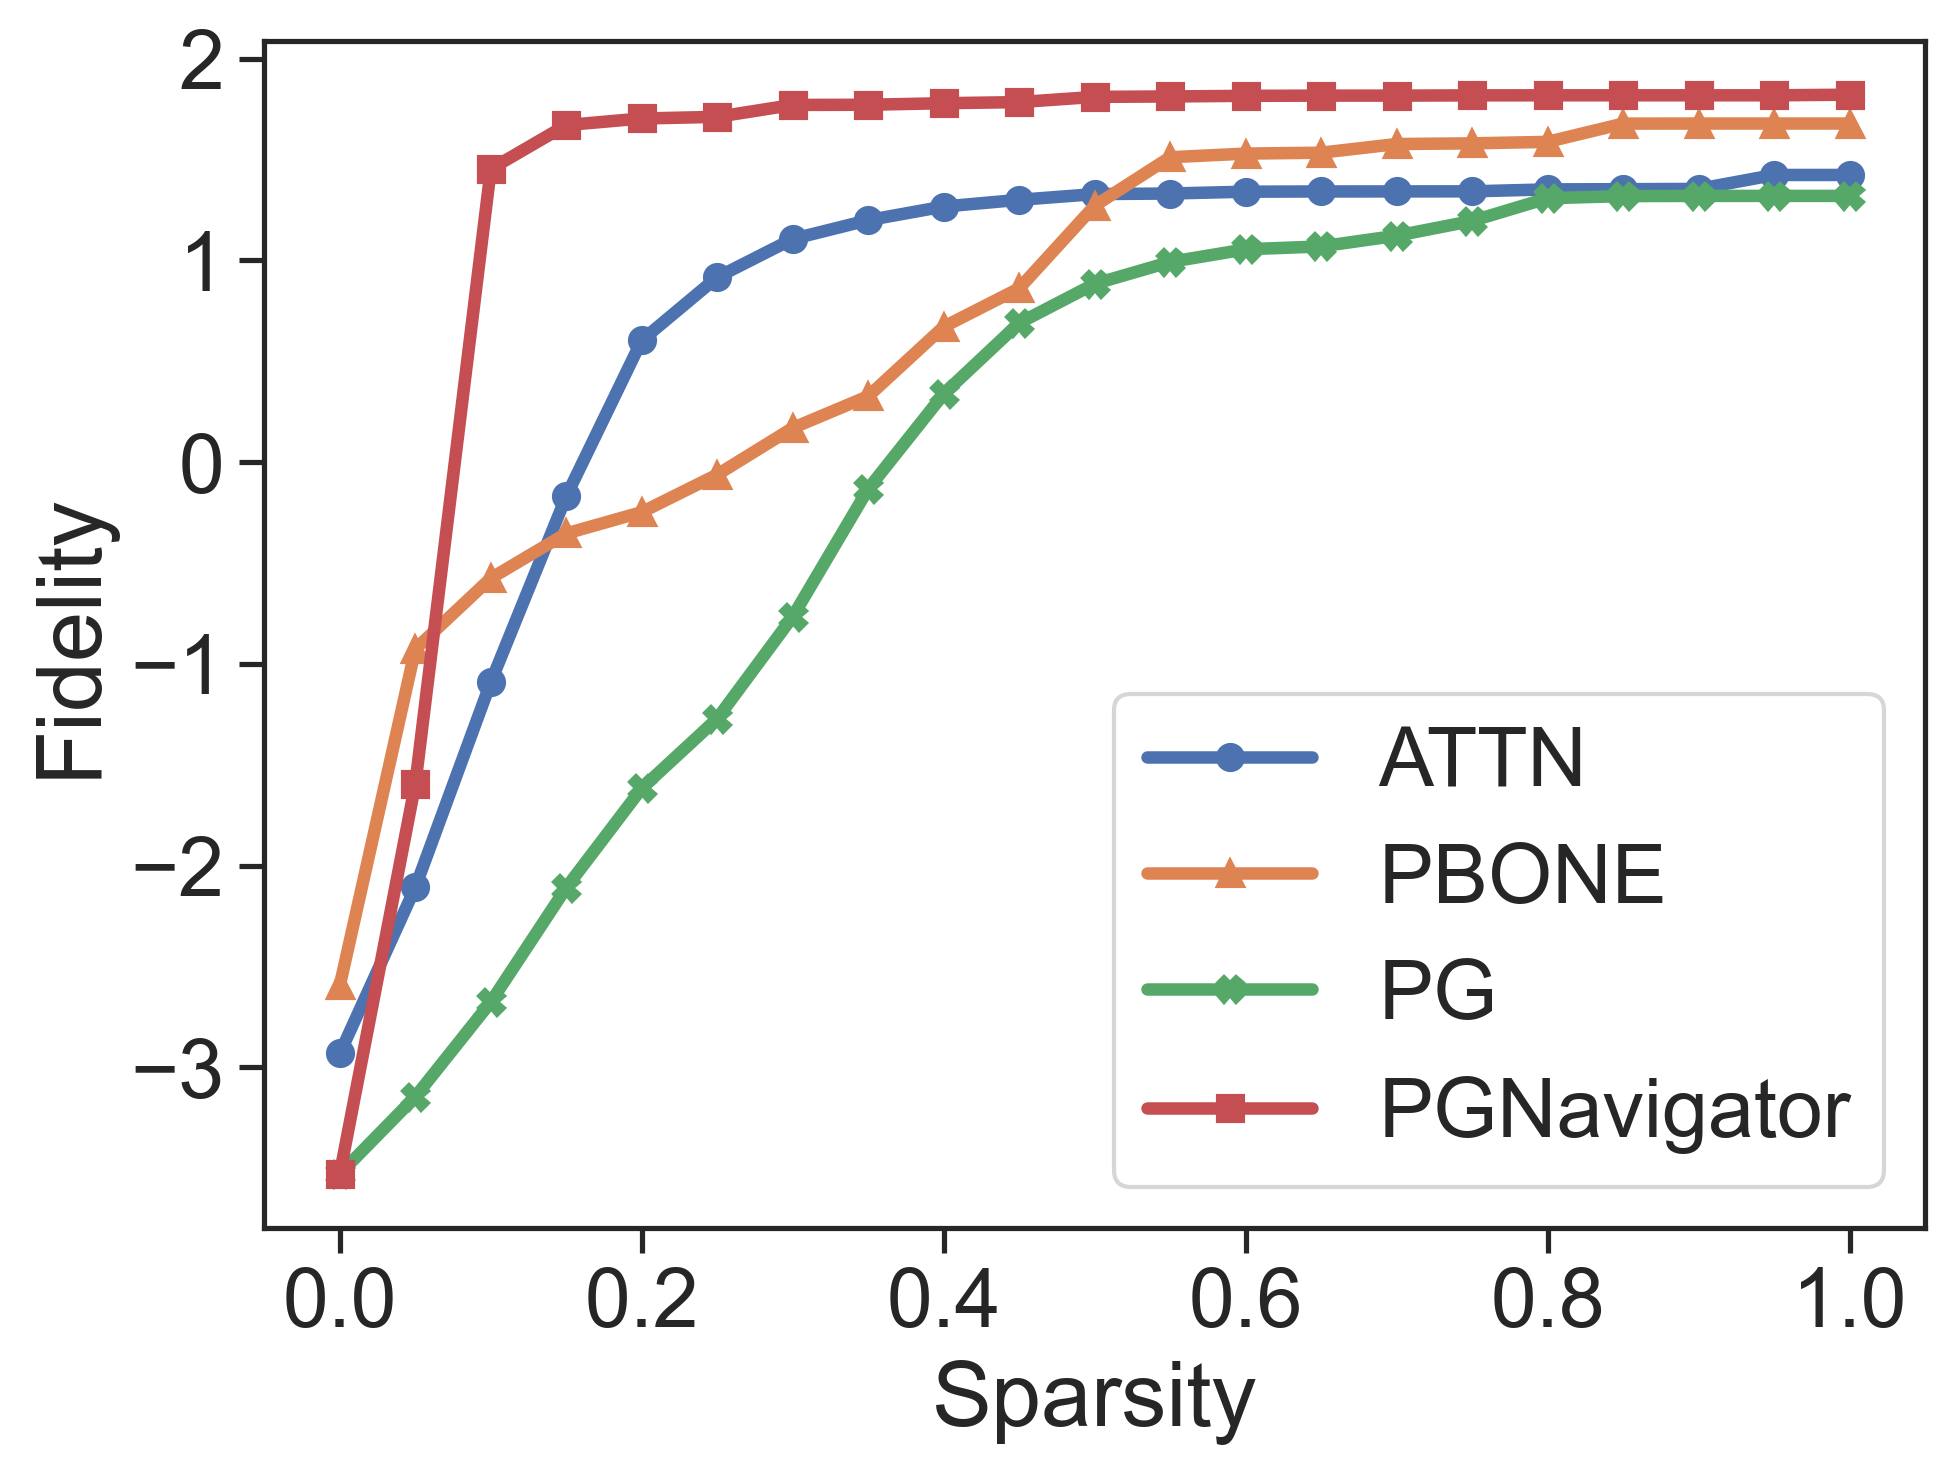

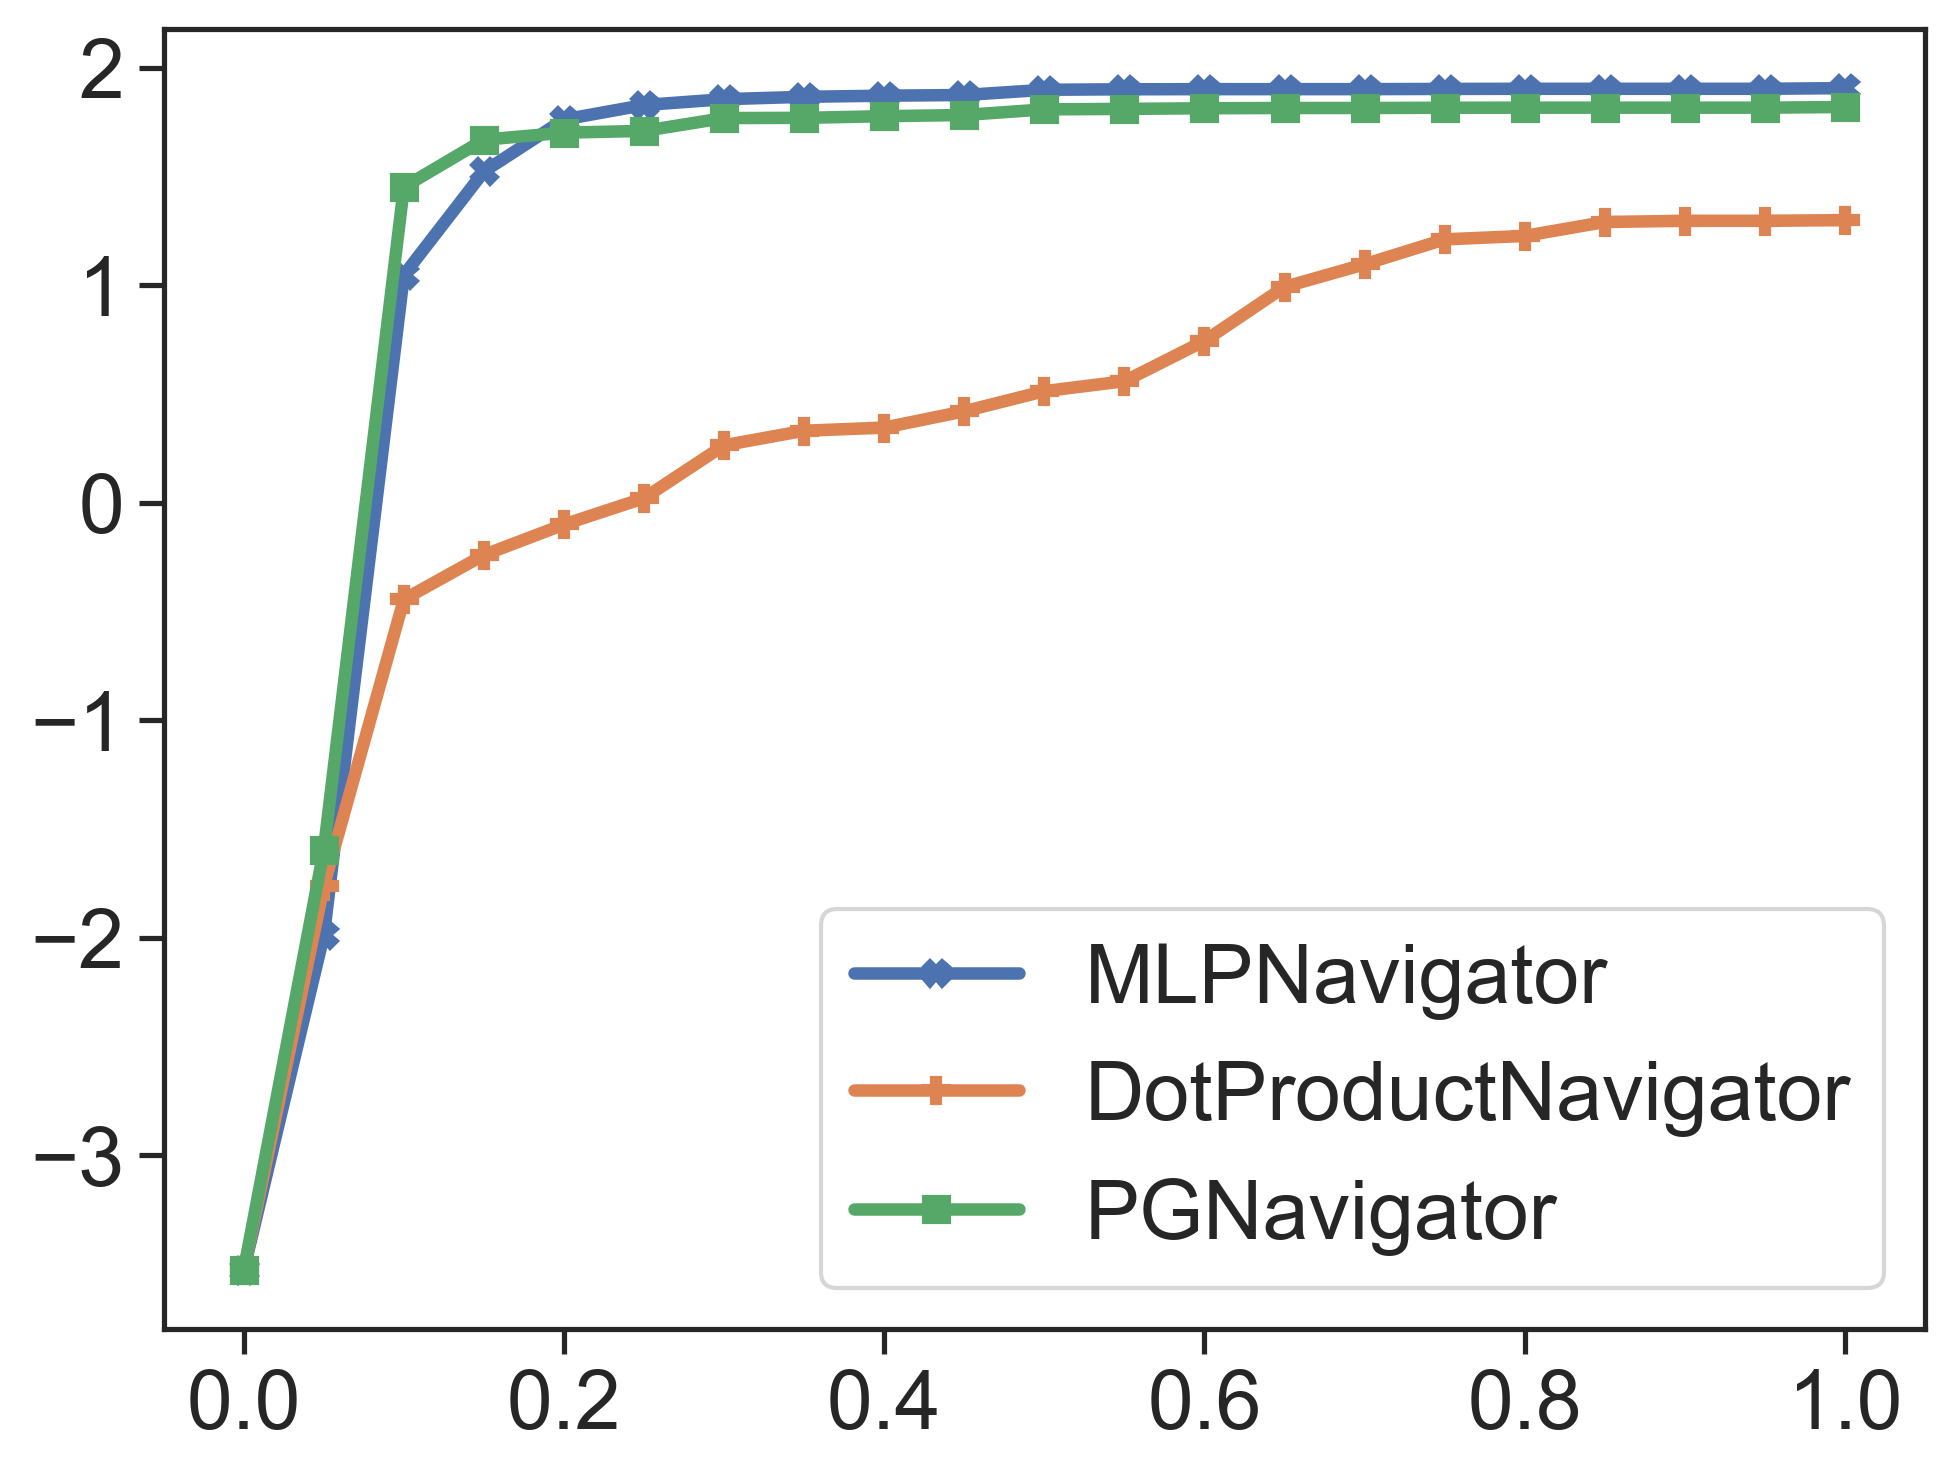

In [227]:
tgn_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_mlp_true_pg_positive_th20.csv",
            "tgn_simulate_v1_attn_explainer_tg_3_to_15902_eval_th20.csv",
            "tgn_simulate_v1_pbone_explainer_tg_3_to_15902_eval_th20.csv",
            "tgn_simulate_v1_pg_explainer_tg_3_to_15902_eval_th20.csv",
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_dot_true_pg_positive_th20.csv",
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_simulate_v1_tabs, tgn_simulate_v1_best_fids, tgn_simulate_v1_aufsc = read_tabs_plot(tgn_simulate_v1_files, "tgn_simulate_v1", plot_only_og)
plot_navigators(tgn_simulate_v1_tabs, "tgn_simulate_v1")

## Simulate V2

Best Fid: {'xtg': 2.4938756166135563, 'attn': 1.648984341936953, 'pbone': 2.9882321319743697, 'pg': 0.9902432631043827, 'xtg-d': 2.945418882311559, 'xtg-og': 2.825217526040825}
AUFSC: {'xtg': 0.8196067307436581, 'attn': -0.9743367022341666, 'pbone': 0.1378981057189257, 'pg': -2.312848904780021, 'xtg-d': 0.6539926552158943, 'xtg-og': 1.7695163844043715}


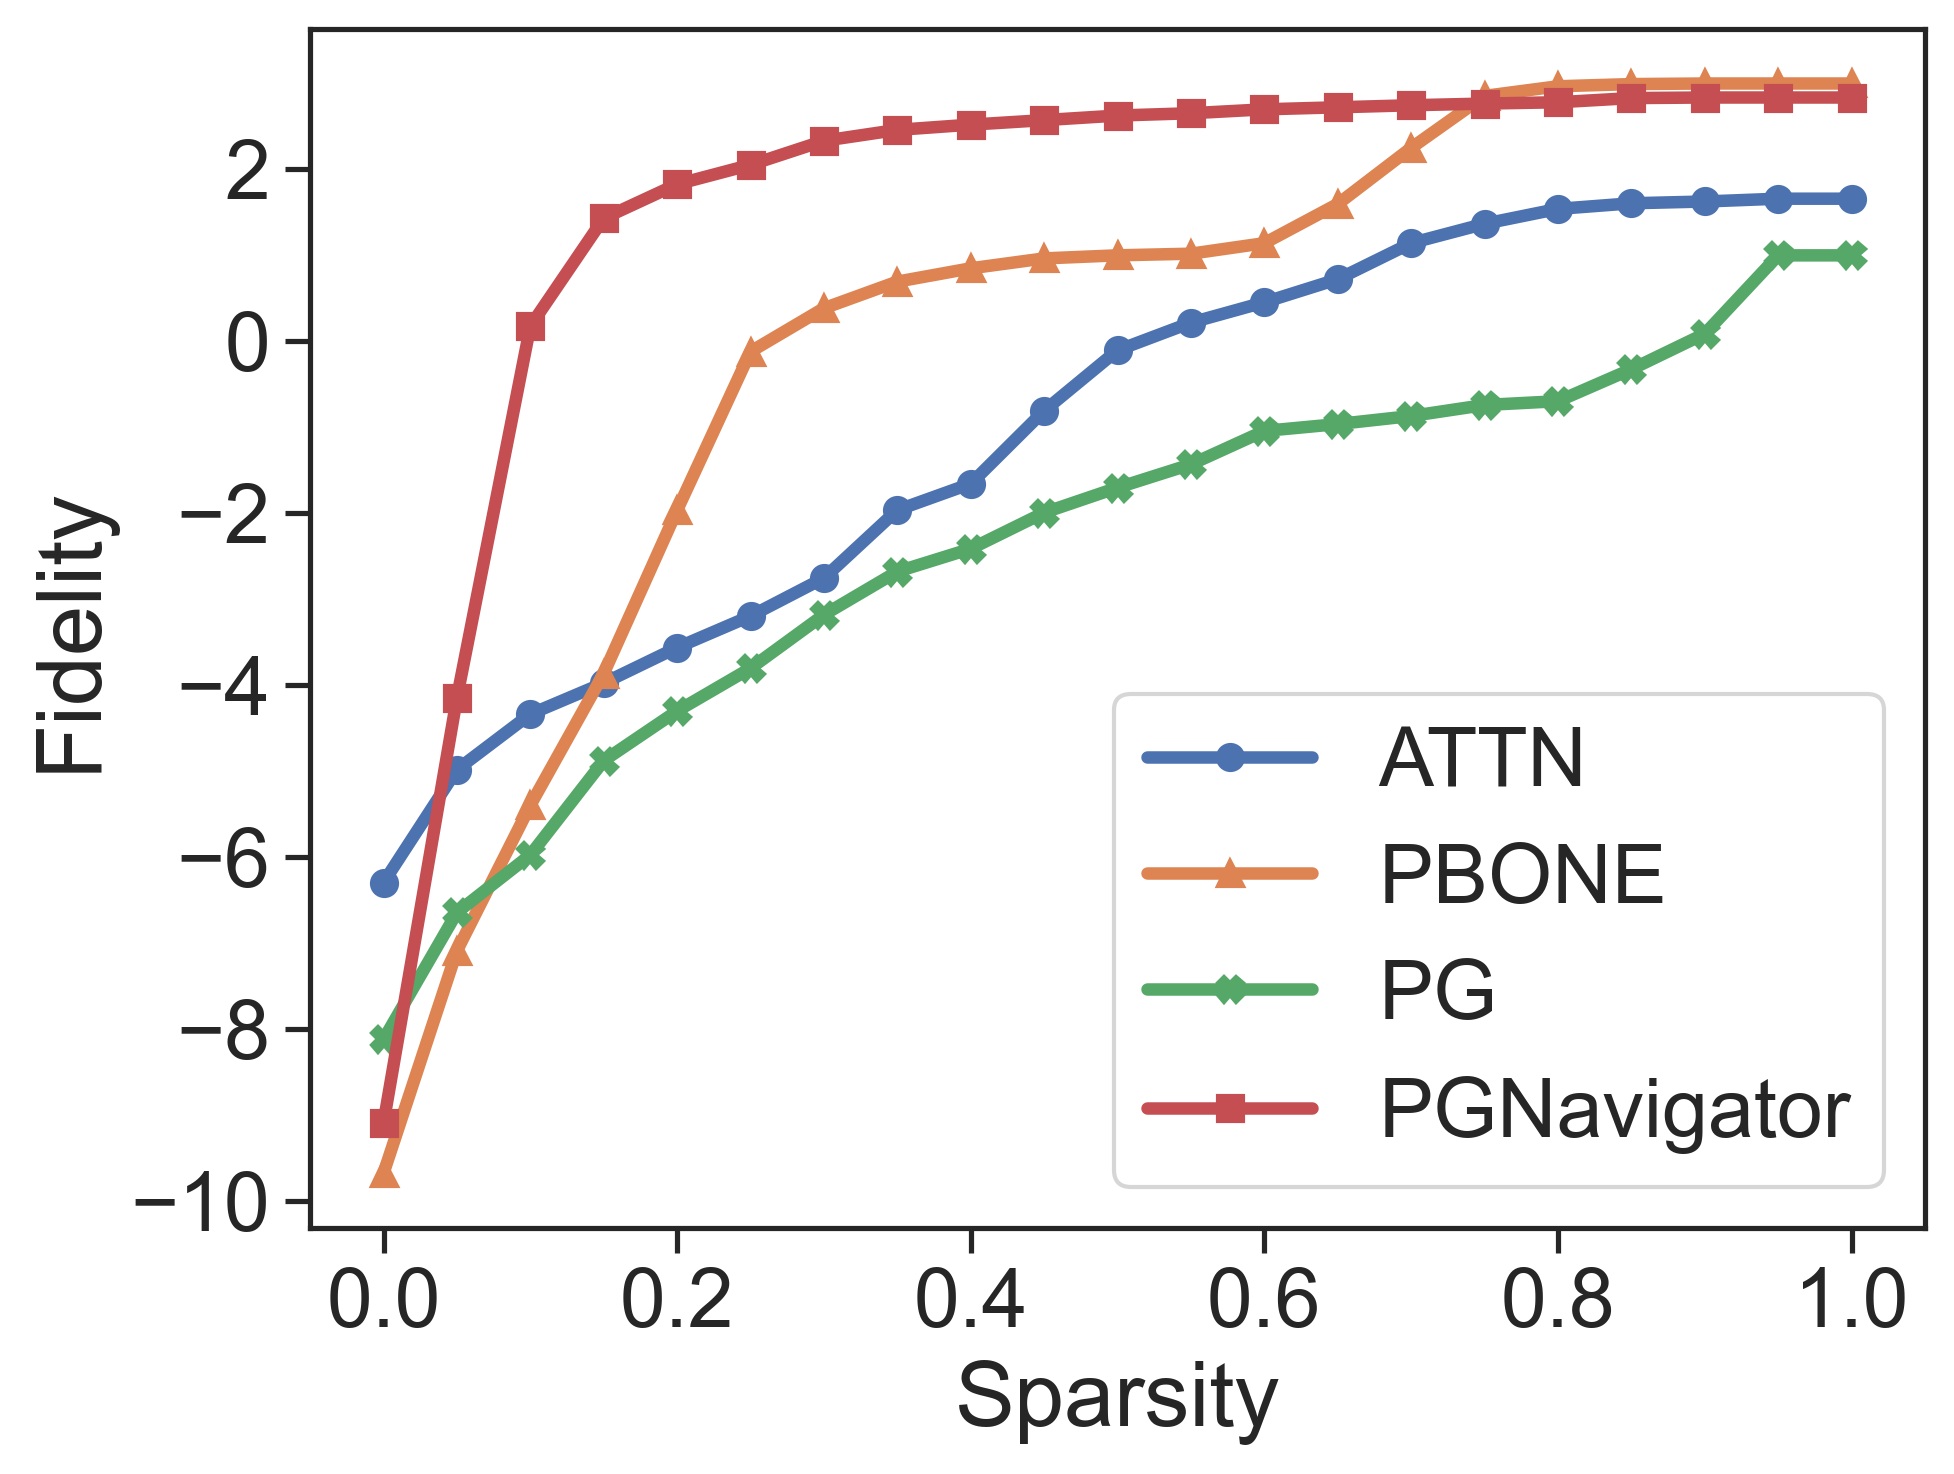

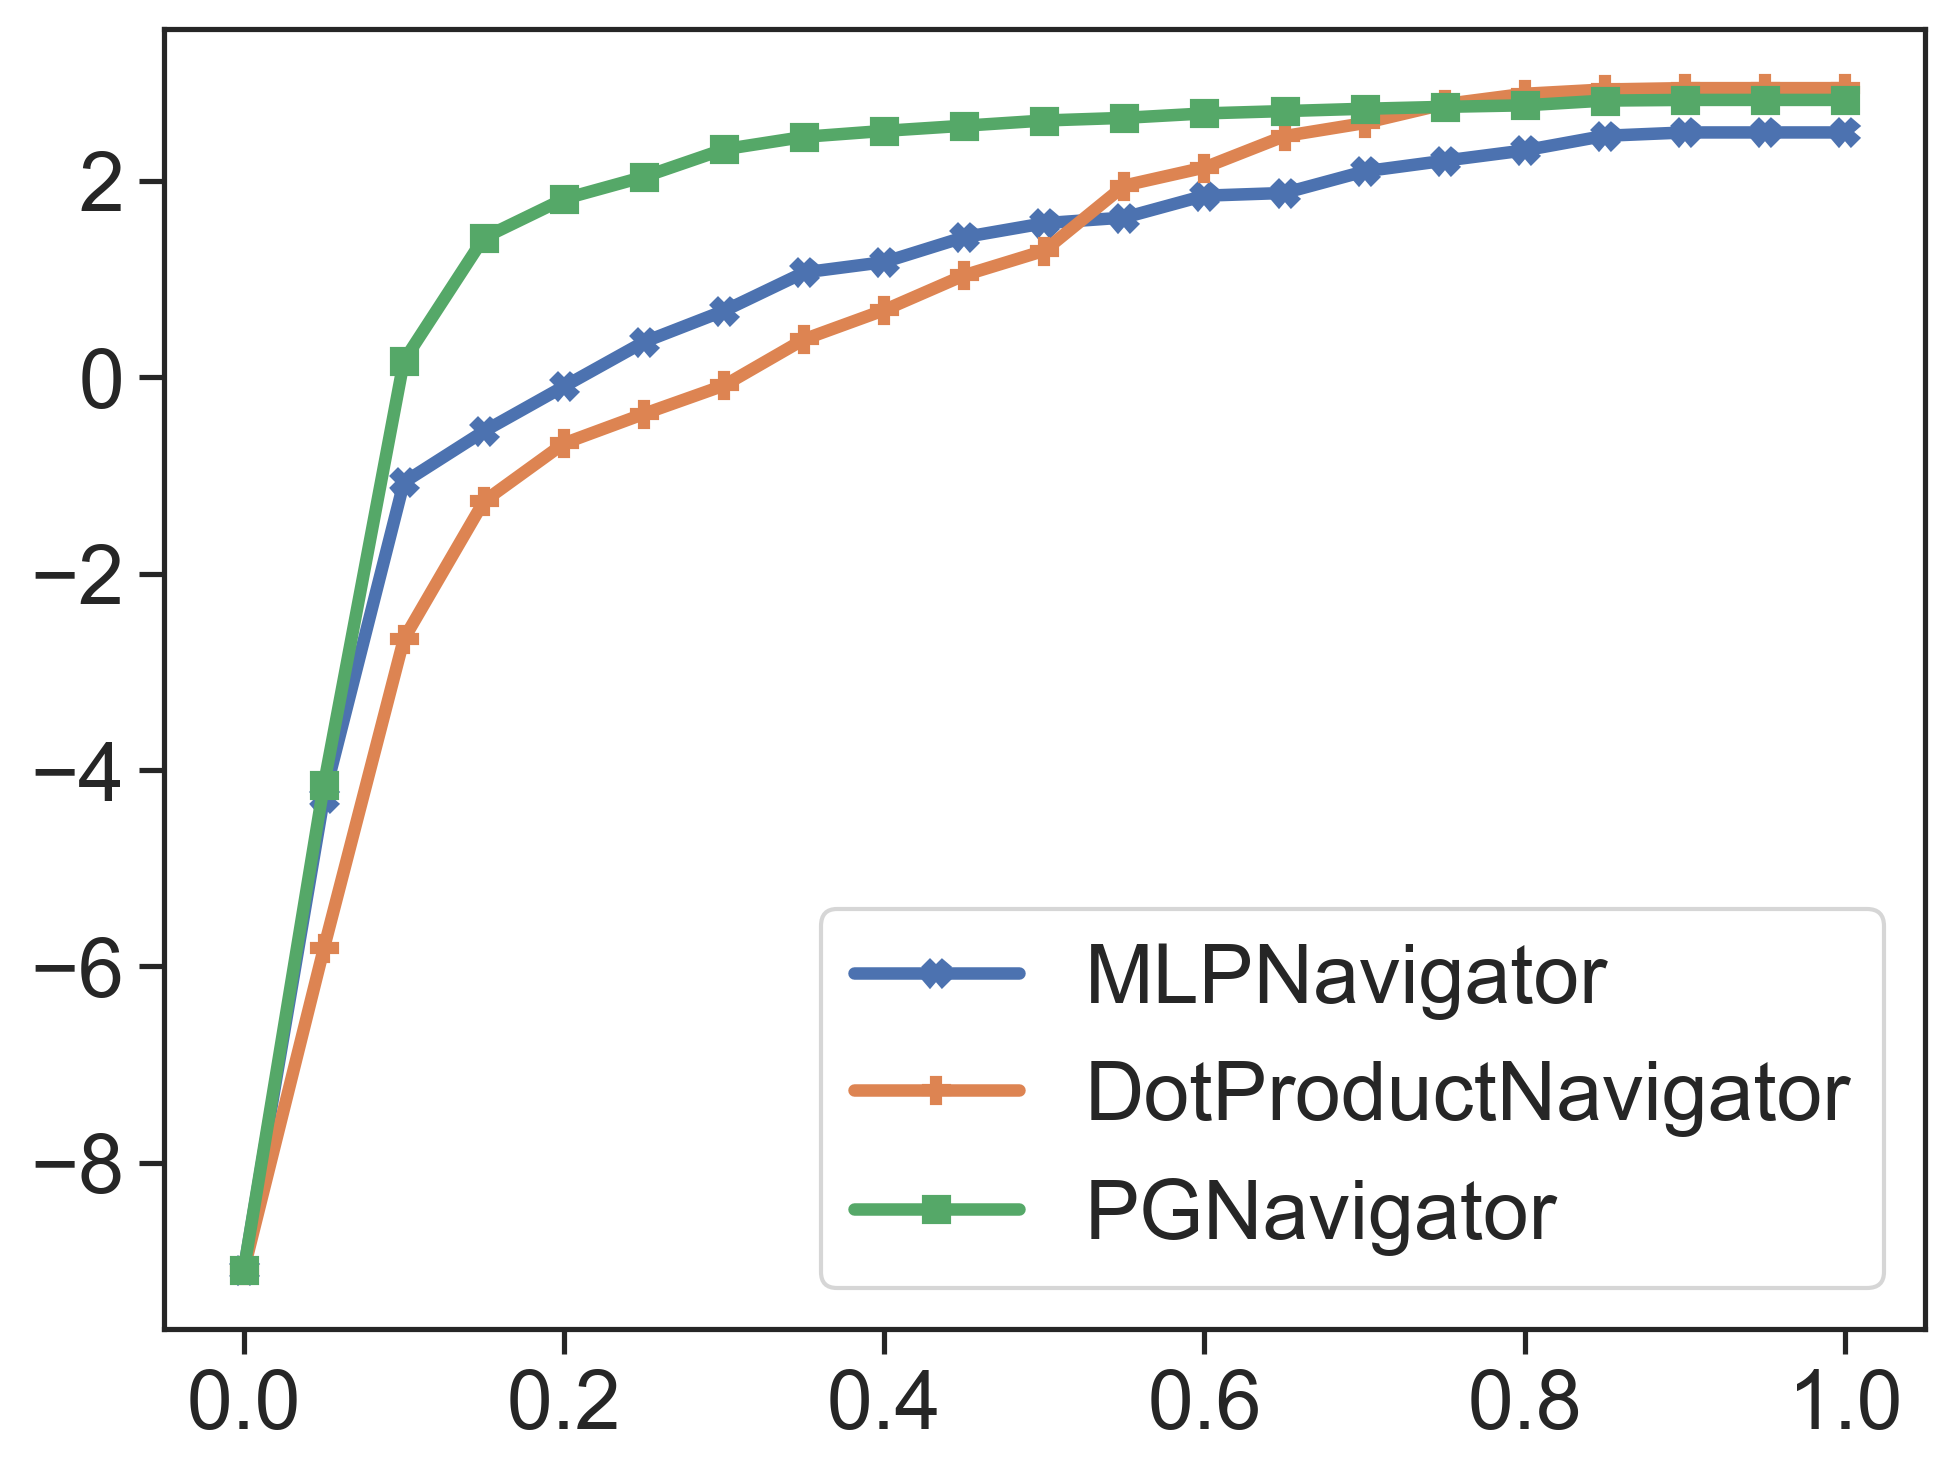

In [228]:
tgn_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_mlp_true_pg_positive_th20.csv",
            "tgn_simulate_v2_attn_explainer_tg_3_to_21752_eval_th20.csv",
            "tgn_simulate_v2_pbone_explainer_tg_3_to_21752_eval_th20.csv",
            "tgn_simulate_v2_pg_explainer_tg_3_to_21752_eval_th20.csv",
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_dot_true_pg_positive_th20.csv",
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_simulate_v2_tabs, tgn_simulate_v2_best_fids, tgn_simulate_v2_aufsc = read_tabs_plot(tgn_simulate_v2_files, "tgn_simulate_v2", plot_only_og)
plot_navigators(tgn_simulate_v2_tabs, "tgn_simulate_v2")

# Assemble everything
Here we assemble everything into a single dataframe and save it to a csv file.

In [253]:
# model = "tgat"
model = "tgn"

locs = locals()
d1 = {
    f"{model}_{dataset}_best_fids": locs[f"{model}_{dataset}_best_fids"]
    for dataset in dataset_to_index
}
d2 = {
    f"{model}_{dataset}_aufsc": locs[f"{model}_{dataset}_aufsc"]
    for dataset in dataset_to_index
}

# zip the two in order to be side by side, my brain is fried i got no better suggestion
d = {}
for (k, v), (k2, v2) in zip(d1.items(), d2.items()):
    d[k] = v
    d[k2] = v2

df_tgat = pd.DataFrame.from_dict(d, orient="columns")

index = pd.MultiIndex(
    levels=[
        ["Wikipedia", "Reddit", "Simulate V1", "Simulate V2"],
        ["Best FID", "AUFSC"],
    ],
    codes=[
        [0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 0, 1, 0, 1],
    ],
    names=["", ""],
)

df_tgat.columns = index
df_tgat.index = ["MLPNavigator", "ATTN", "PBONE", "PG", "DotProductNavigator", "PGNavigator"]
df_tgat = df_tgat.T[
    ["ATTN", "PBONE", "PG", "PGNavigator", "MLPNavigator", "DotProductNavigator"]
].T  # reorder rows to correspond to their order in OG paper
import matplotlib.colors as mcolors


def color_gradient(val, cmap="coolwarm", vmin=None, vmax=None):
    """
    Takes a scalar and returns a string with
    the css property `'color: ...'` for a color
    based on the value relative to the vmin and vmax.
    """
    cmap = plt.get_cmap(cmap)
    norm = mcolors.AsinhNorm(vmin=vmin, vmax=vmax)
    color = mcolors.rgb2hex(cmap(norm(val)))
    return f" color: {color}({val})"

df_latex = df_tgat
df_latex = (
    df_latex.style.highlight_max(props="font-weight:bold")
    .apply(lambda x: np.where(x == x.nlargest(2)[-1], "font-style:oblique;", None))
    .format(precision=3)
    .to_latex(
        convert_css=True,
        multicol_align="c",
        hrules=True,
        column_format="lrrrrrrrr",
        caption="$\\dagger$ Explainer results for {model.upper()} model",
        label=f"tab:{model}_results",
    )
    .replace("\\slshape", "\\underline")
)

df_diff = (df_tgat - locs[f"df_{model}_theirs"]) / locs[f"df_{model}_theirs"] * 100
df_diff = (
    df_diff.dropna().style.format(precision=3)
    .to_latex(
        convert_css=True,
        multicol_align="c",
        hrules=True,
        position_float="centering",
        column_format="lrrrrrrrr",
        caption=f"Relative difference in results for {model.upper()} model with respect to the original paper (in \\%).",
        label=f"tab:{model}_results_diff",
    )
)
with open(f"tables/{model}_results_tab.tex", "w") as f:
    f.write(df_latex)

with open(f"tables/{model}_results_tab.md", 'w') as f:
    df_tgat.style.format(precision=3).to_html(f, caption=f"Experimental results for {model.upper()} model.")

with open(f"tables/{model}_results_diff_tab.tex", "w") as f:
    f.write(df_diff)

with open(f"tables/{model}_results_og_tab.tex", "w") as f:
    f.write(
        locs[f"df_{model}_theirs"]
        .style.format(precision=3)
        .to_latex(
            multicol_align="c",
            hrules=True,
            clines="skip-last;data",
            position_float="centering",
            column_format="lcccccccc",
            caption=f"Results for {model.upper()} model from the original paper.",
            label=f"tab:{model}_results_og",
        )
    )

# set display precision
print(df_latex)

\begin{table}
\caption{$\dagger$ Explainer results for {model.upper()} model}
\label{tab:tgn_results}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{Wikipedia} & \multicolumn{2}{c}{Reddit} & \multicolumn{2}{c}{Simulate V1} & \multicolumn{2}{c}{Simulate V2} \\
 & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC \\
\midrule
ATTN & 1.423 & 0.788 & 1.649 & -0.974 & 0.597 & 0.418 & 0.181 & -1.457 \\
PBONE & 1.678 & 0.751 & \bfseries 2.988 & 0.138 & 0.735 & 0.432 & \underline 0.265 & \bfseries -0.616 \\
PG & 1.319 & -0.011 & 0.990 & -2.313 & 0.550 & -0.419 & 0.150 & -2.179 \\
PGNavigator & \underline 1.821 & \underline 1.467 & 2.825 & \bfseries 1.770 & \underline 0.921 & \bfseries 0.680 & \bfseries 0.265 & \underline -1.056 \\
MLPNavigator & \bfseries 1.908 & \bfseries 1.494 & 2.494 & \underline 0.820 & \bfseries 0.935 & \underline 0.491 & 0.256 & -1.460 \\
DotProductNavigator & 1.301 & 0.398 & \underline 2.945 & 0.654 & 0.908 & 0.371 & 0.265 & -1.285 \\
\

# Decision Explanation
## SimulateV1

([1, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0],
 ['lightgreen',
  'green',
  'green',
  'grey',
  'grey',
  'grey',
  'lightgreen',
  'grey',
  'grey',
  'green',
  'grey',
  'grey',
  'grey',
  'lightgreen',
  'green',
  'green',
  'grey',
  'green',
  'grey',
  'grey'])

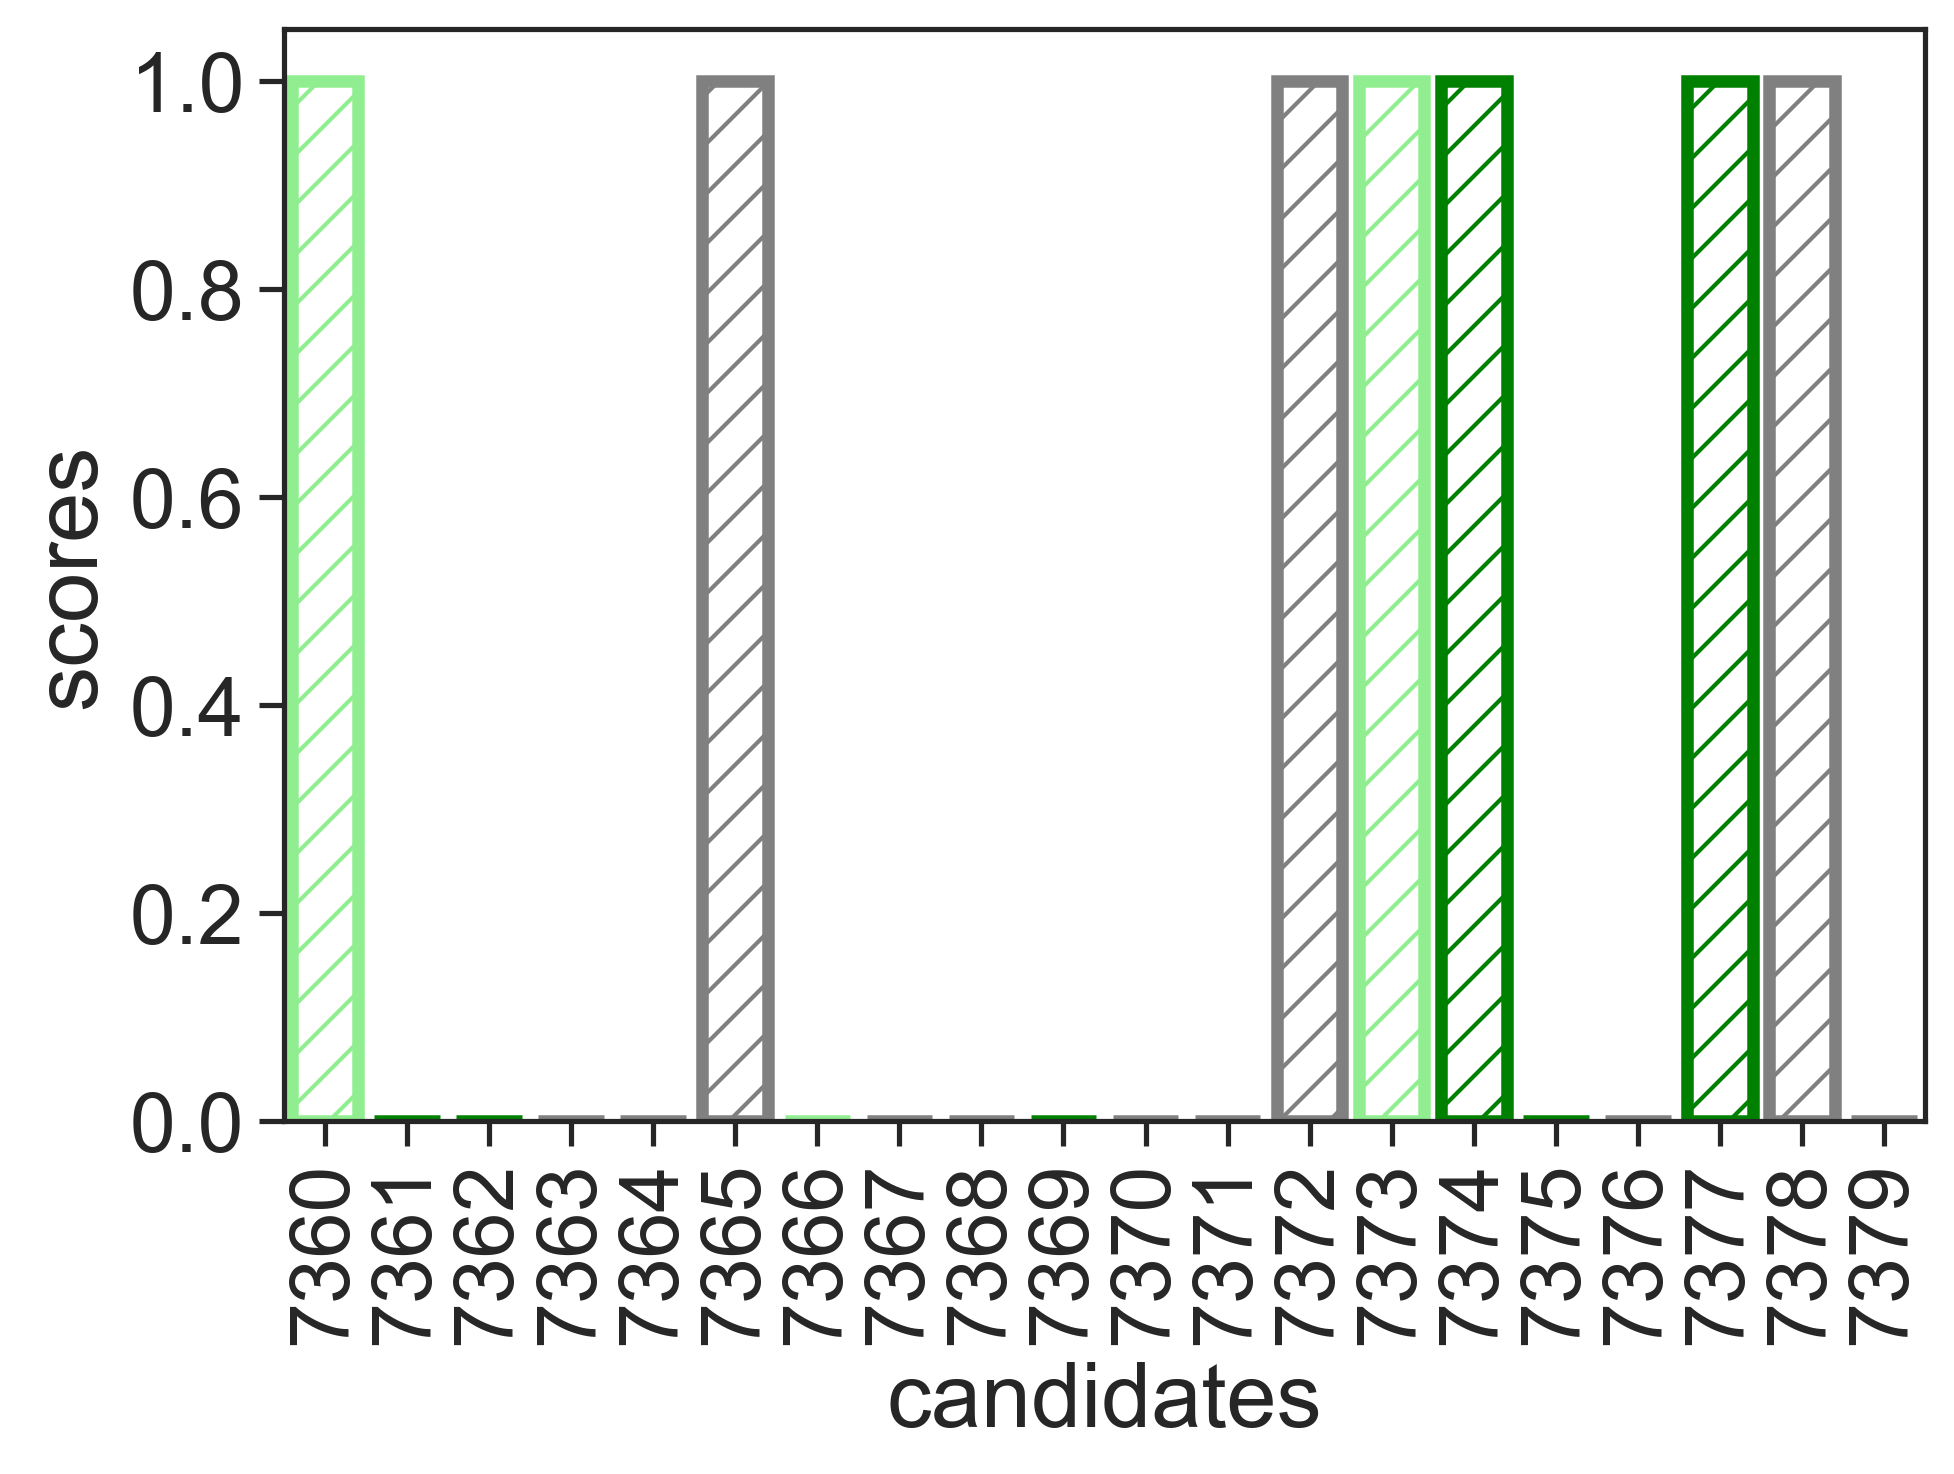

In [40]:
threshold = 20
# ground truth

def get_color(c):
    match c:
        case 0:
            return "grey"
        case 1:
            return "lightgreen"
        case 2:
            return "green"
        case -1:
            return "lightcoral"  # dont ask
        case -2:
            return "indianred"
        case _:
            return "white"


def plot_7380_tgat_og(threshold=20):
    relevancy = [0]*(threshold-20)+[1,2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0]
    colors = [get_color(c) for c in relevancy]
    xaxis = range(7380 - threshold, 7380)
    plt.bar(
        xaxis,
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        edgecolor=colors, linewidth=3, color="white", hatch="//",
    )
    plt.xlim(7380 - threshold - 0.5, 7379 + 0.5)
    plt.xlabel("candidates")
    plt.ylabel("scores")
    plt.xticks(xaxis, rotation=90)
    return relevancy, colors

plot_7380_tgat_og()

Navigator: pg_true
Navigator: mlp_true
Navigator: dot_true


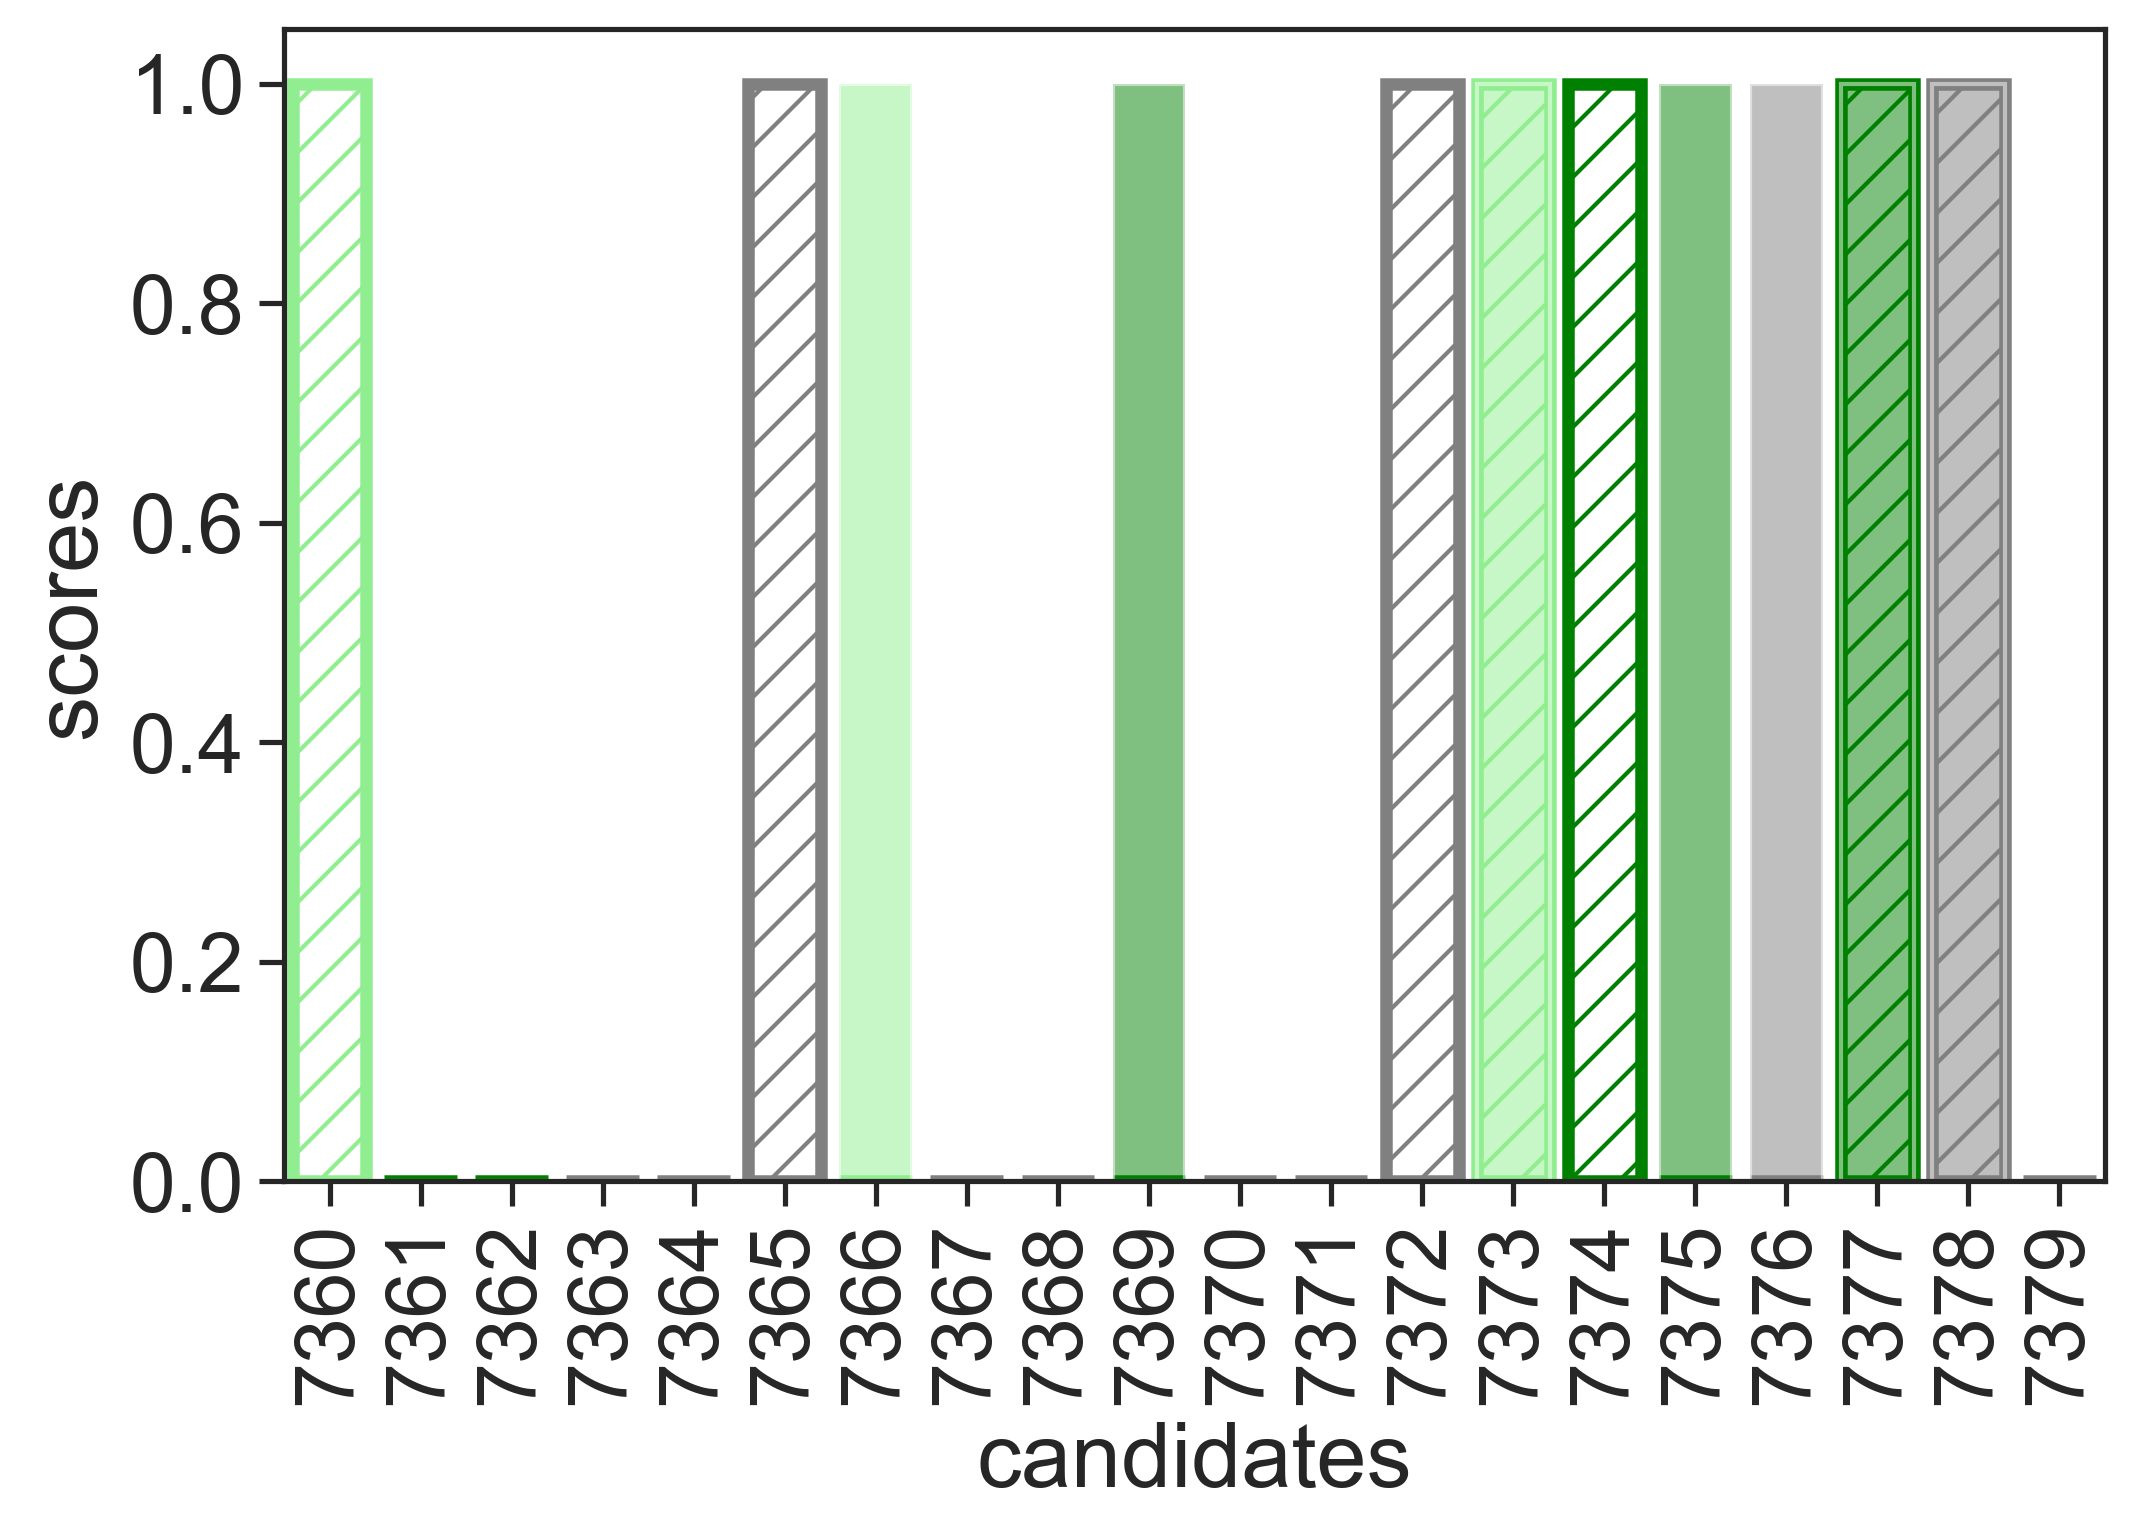

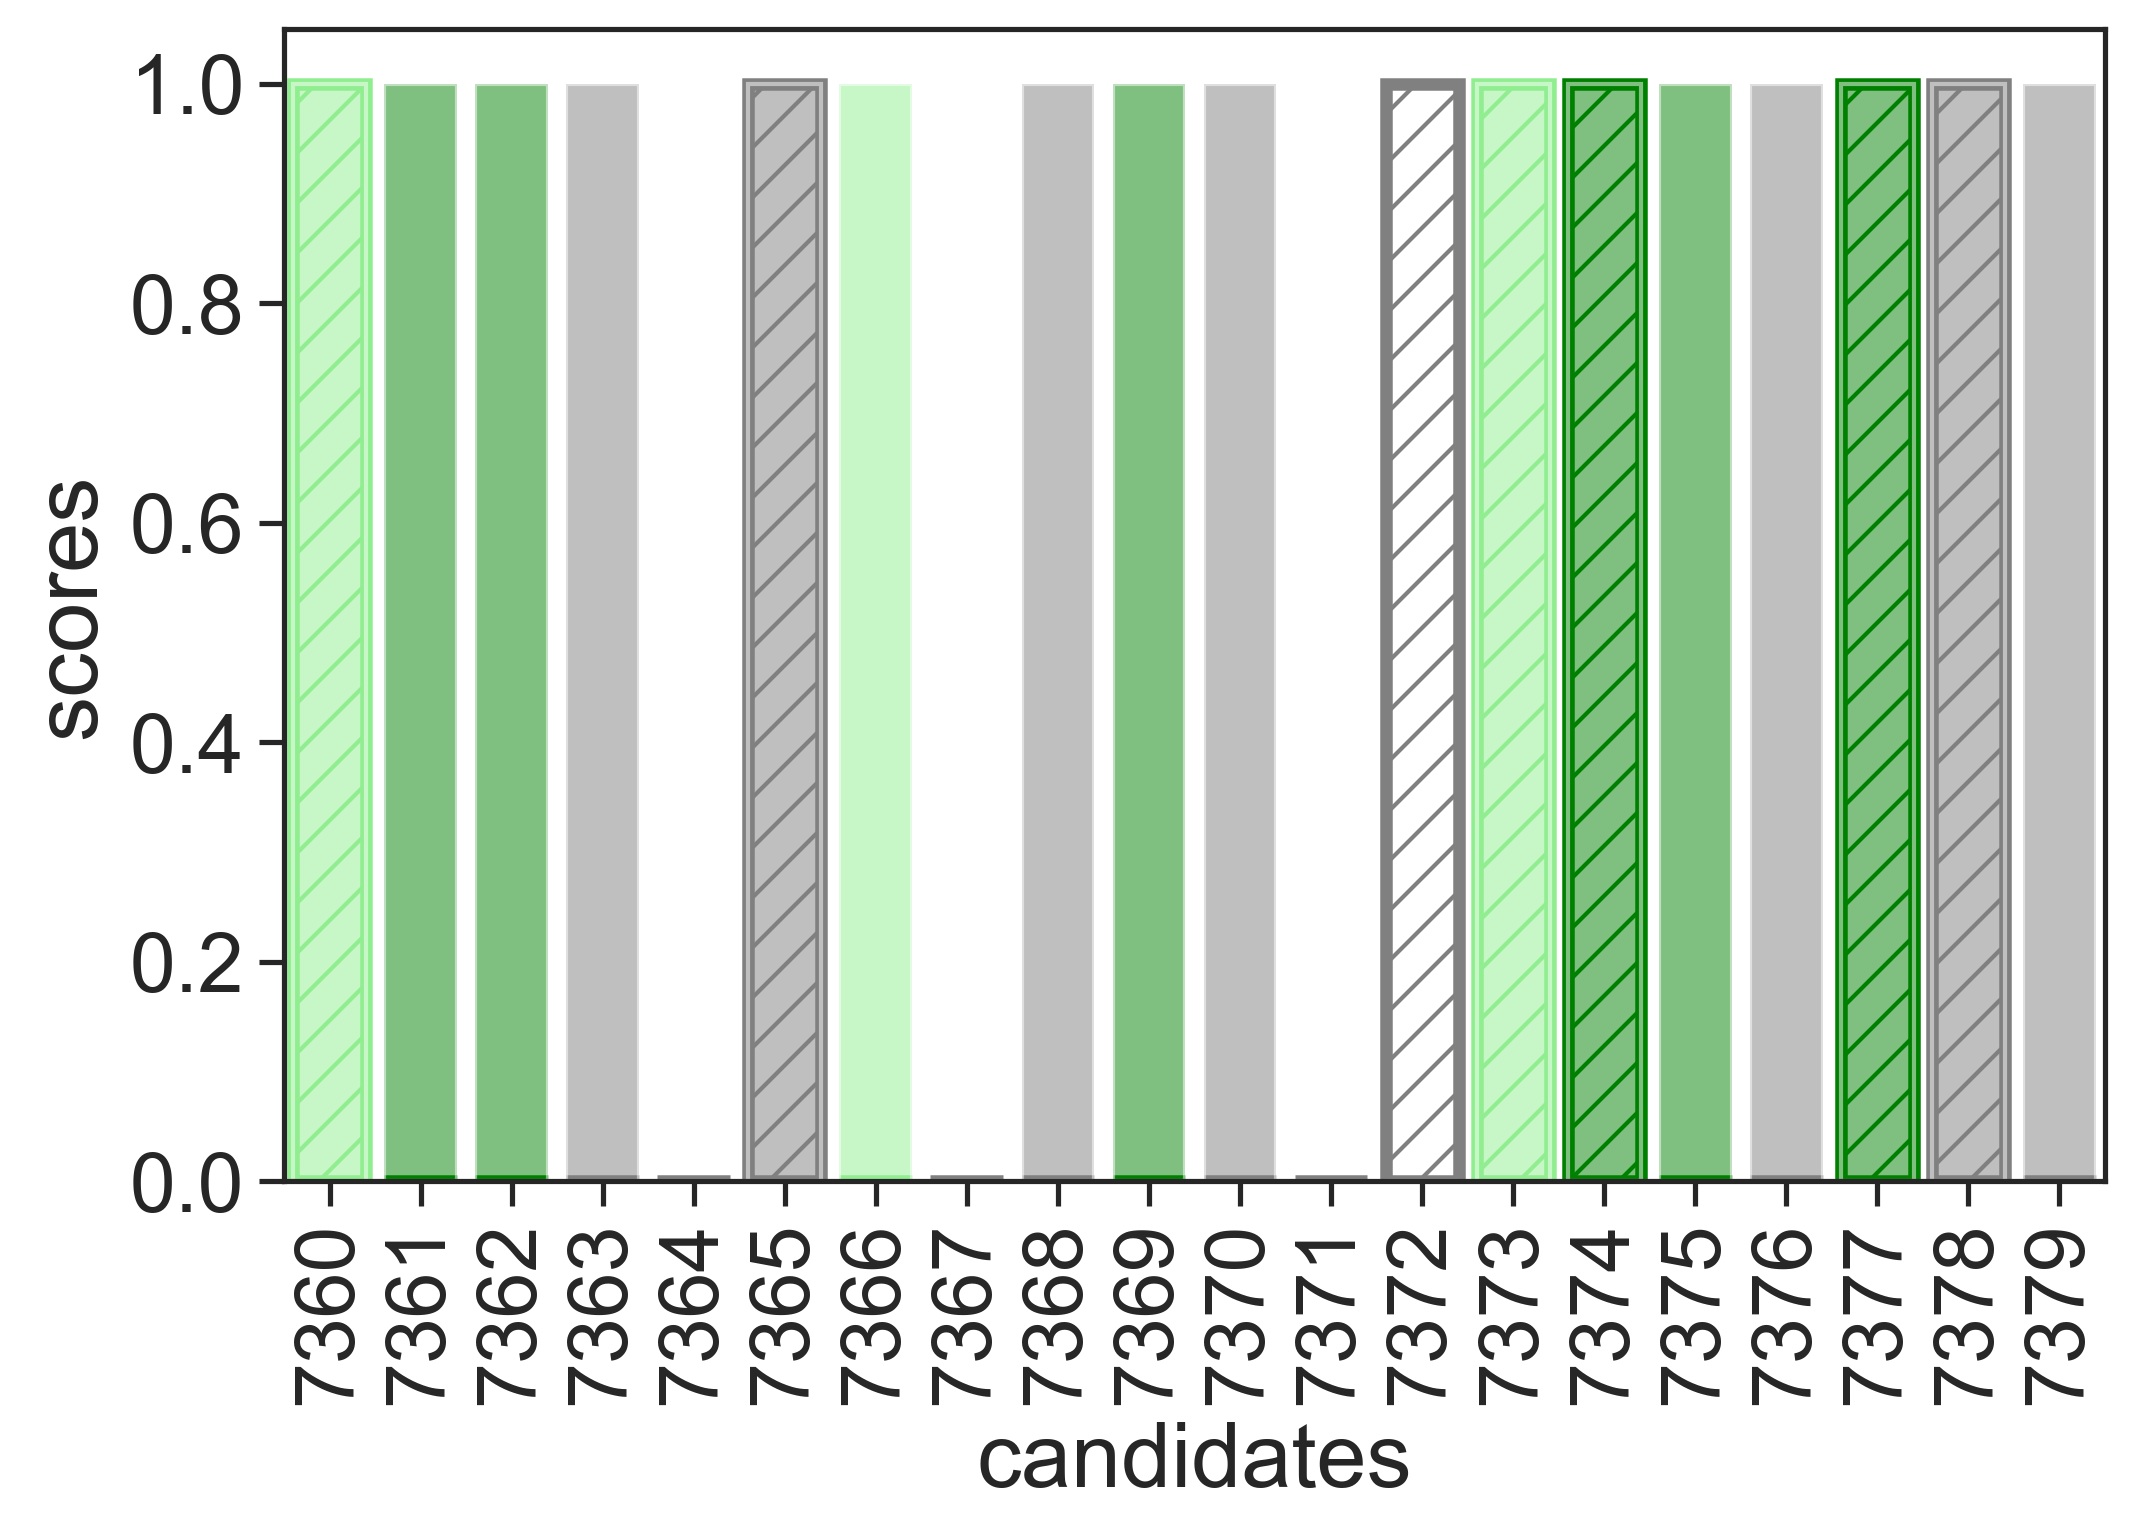

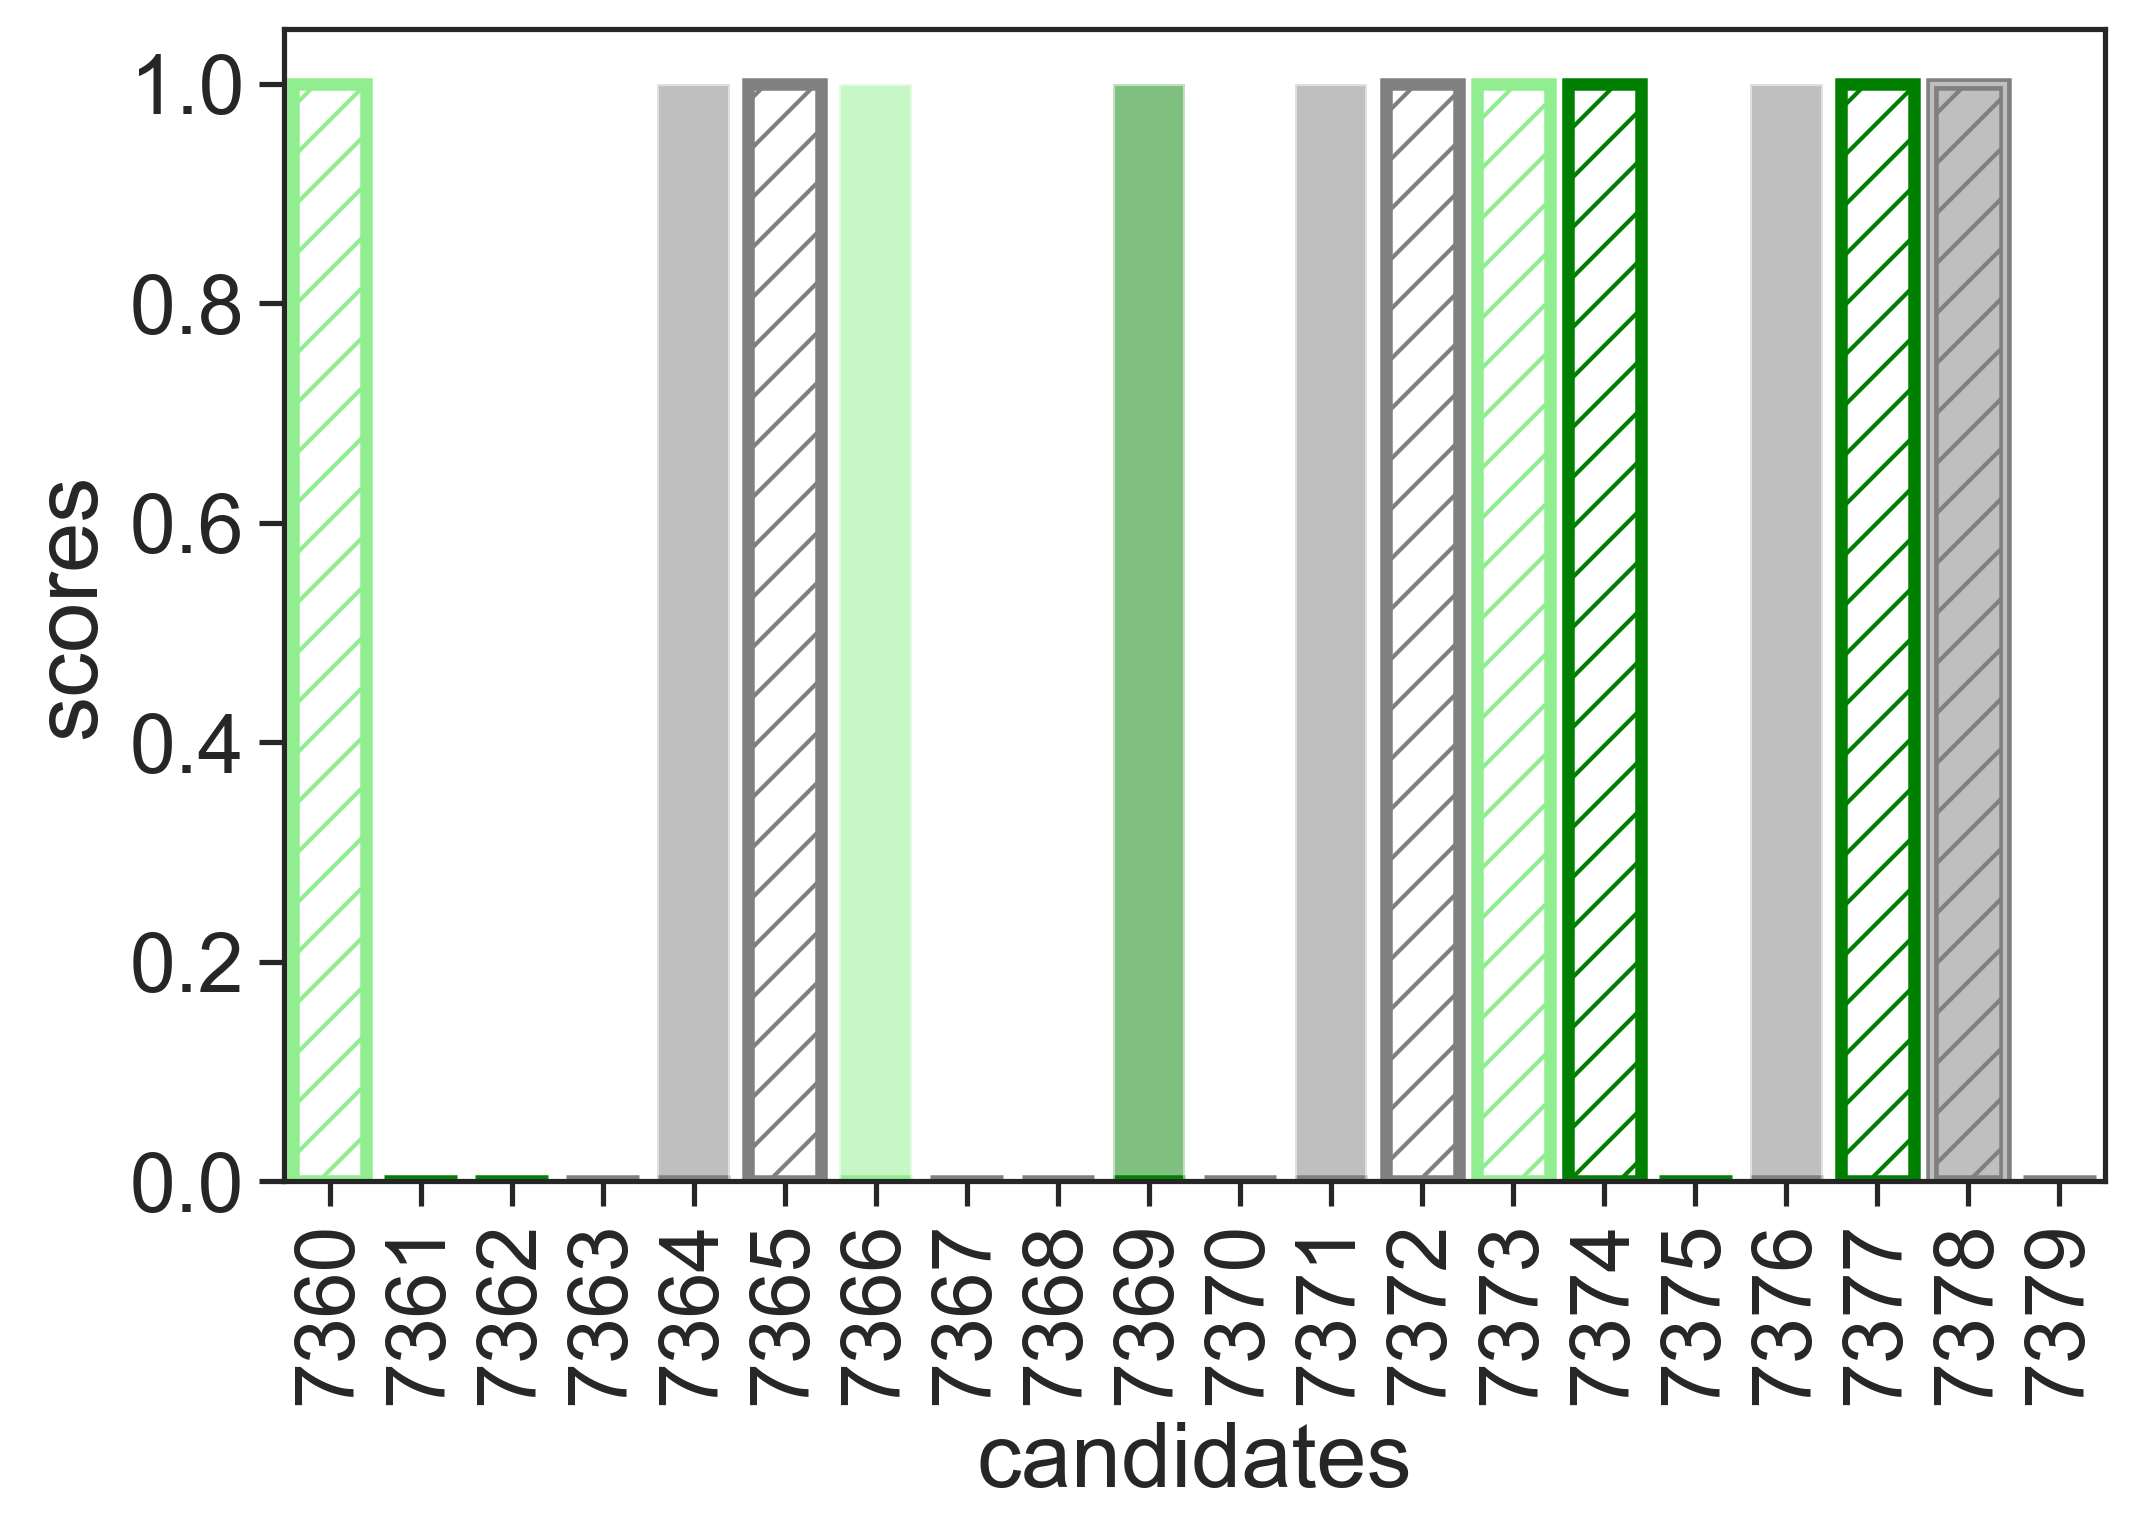

In [41]:
model = "tgat"

xaxis = range(7380 - threshold, 7380)

for navigator in ["pg_true", "mlp_true", "dot_true"]:
    print("Navigator:", navigator)
    mcts_node_info = next(mcts_path.glob(f"{model}*simulate_v1_7380*{navigator}*{threshold}*"), None)
    if mcts_node_info is None:
        print("No mcts node info found")
        continue
    # mcts_node_info
    node_info = torch.load(mcts_node_info)
    node_info = node_info["saved_MCTSInfo_list"]  # there is only one key in the dict

    best_expansion = max(node_info, key=lambda x: x["P"])

    plt.figure(figsize=(7, 5))
    relevancy, colors = plot_7380_tgat_og(threshold)
    plt.bar(
        xaxis, [1 if x in best_expansion["coalition"] else 0 for x in xaxis], color=colors, alpha=0.5
    )

    plt.xlim(7380 - threshold-0.5, 7379+0.5)
    plt.xlabel('candidates')
    plt.ylabel('scores')
    plt.xticks(xaxis, rotation=90)
    plt.savefig(f"plots/case-study/simulated_1_7380_{model}_mcts_{navigator}_th{threshold}.png")


### SimulateV2 - 2013

([-2, 1, 1, 2, -2, -1, 1, 2, -2, 1, 2, -2, 2, -2, -2, 1, -1, 1, 1, 2],
 ['indianred',
  'lightgreen',
  'lightgreen',
  'green',
  'indianred',
  'lightcoral',
  'lightgreen',
  'green',
  'indianred',
  'lightgreen',
  'green',
  'indianred',
  'green',
  'indianred',
  'indianred',
  'lightgreen',
  'lightcoral',
  'lightgreen',
  'lightgreen',
  'green'])

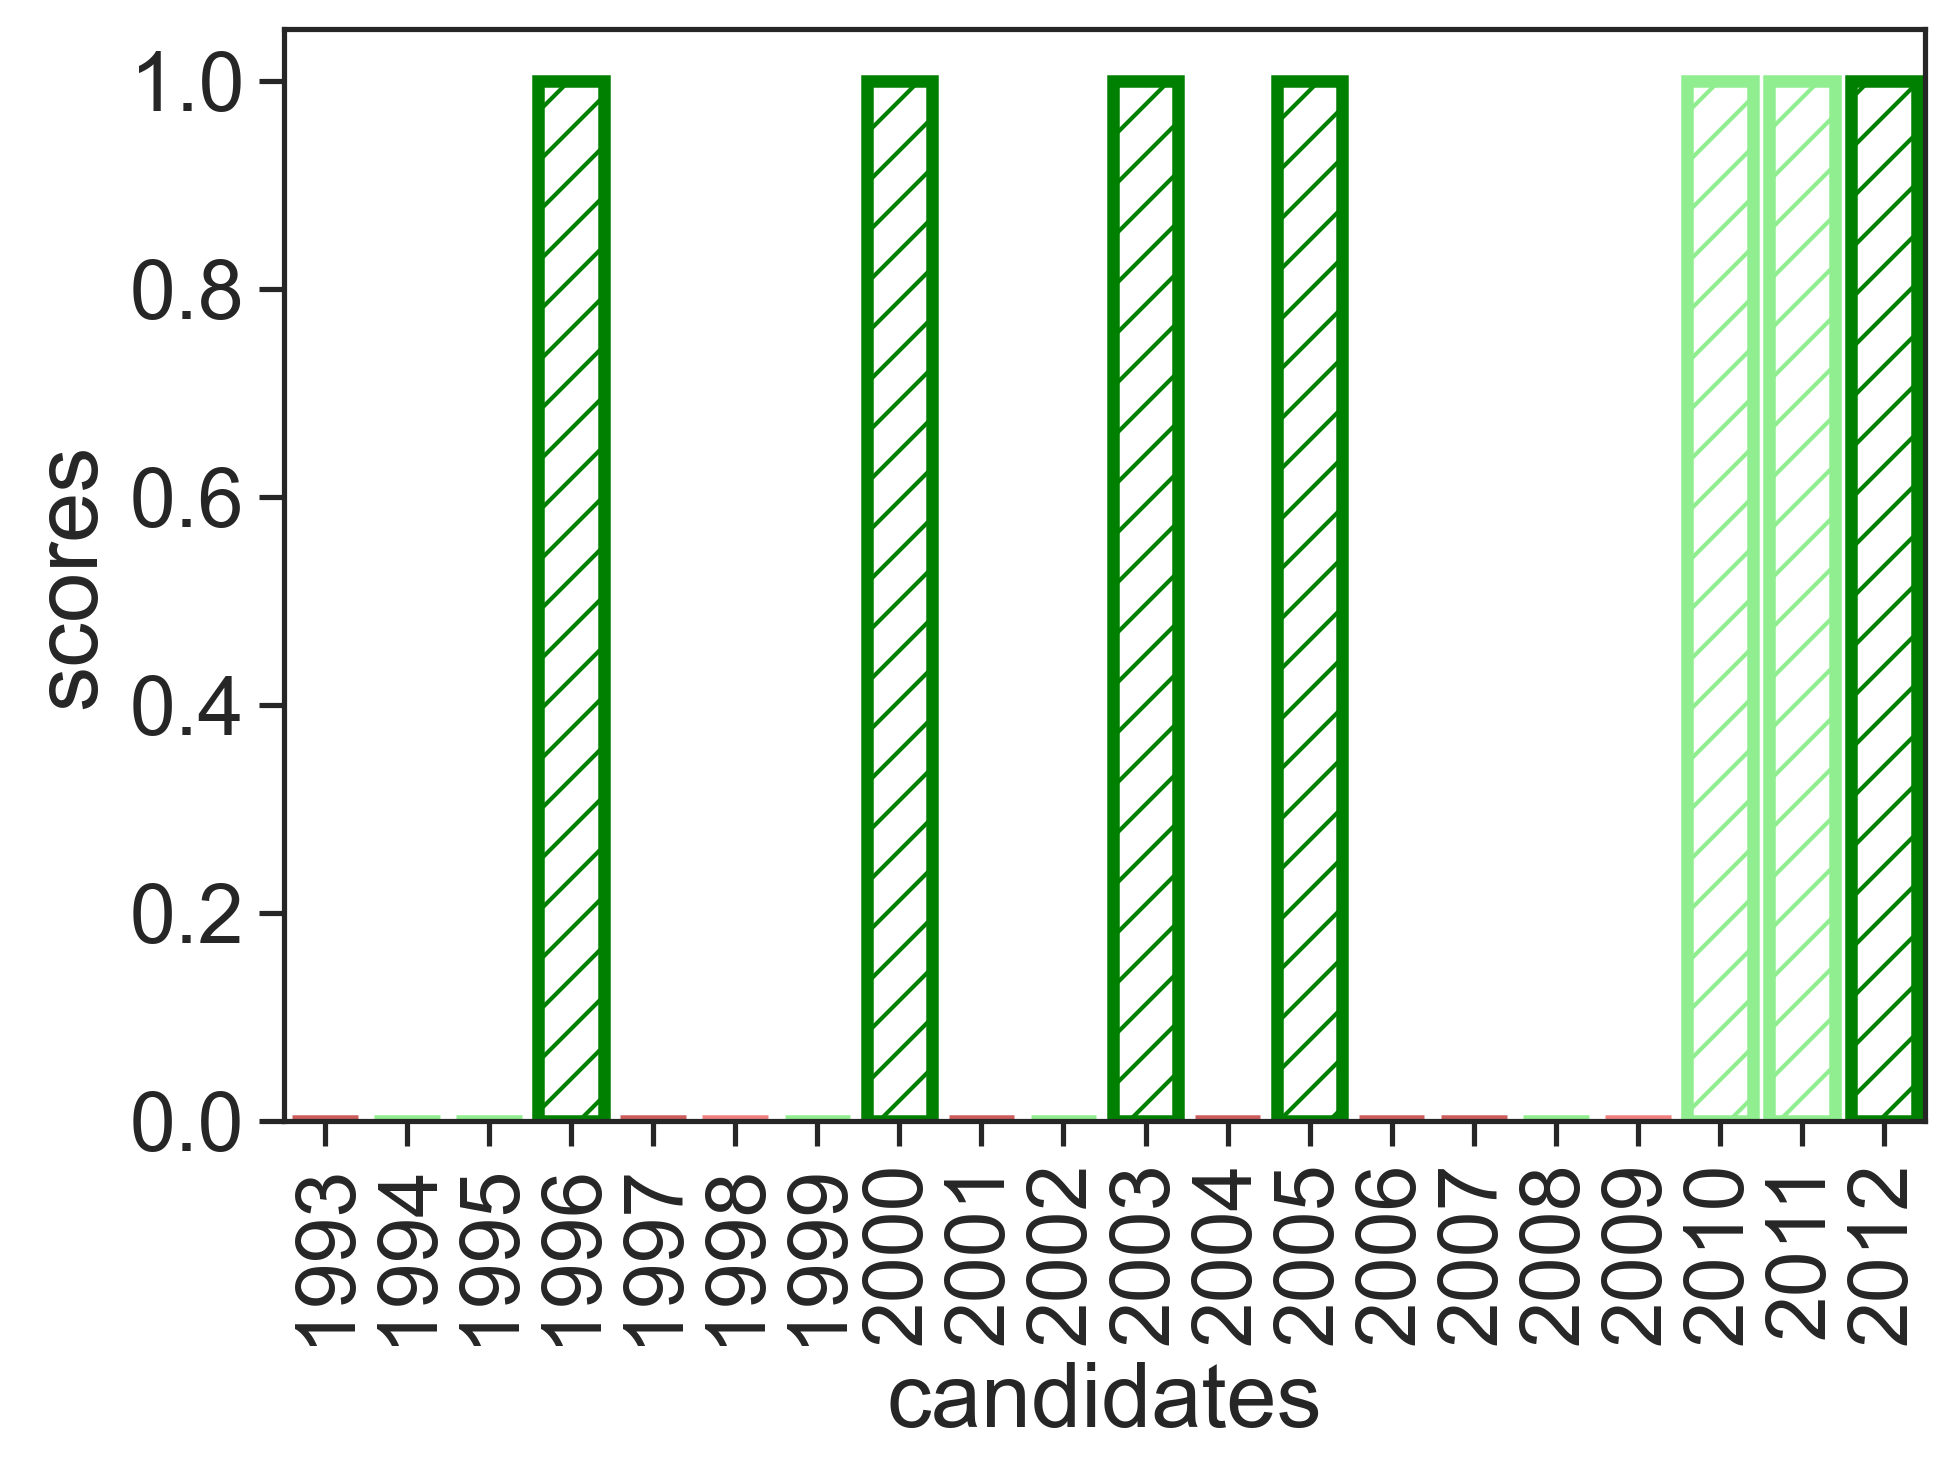

In [42]:
threshold = 20

def plot_2013_tgat_og(threshold=20):
    relevancy = [0] * abs(threshold - 20) + [-2,1,1,2,-2,-1,1,2,-2,1,2,-2,2,-2,-2,1,-1,1,1,2]
    colors = [get_color(c) for c in relevancy]
    xaxis = range(2013 - threshold, 2013)
    plt.bar(
        xaxis,
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1],
        color='white', edgecolor=colors, linewidth=3, hatch="//"
    )

    plt.xlim(2013 - threshold - 0.5, 2012 + 0.5)
    plt.xlabel("candidates")
    plt.ylabel("scores")
    plt.xticks(xaxis, rotation=90)
    return relevancy, colors

plot_2013_tgat_og()

Navigator: pg_true
Navigator: pg_false
Navigator: dot_true


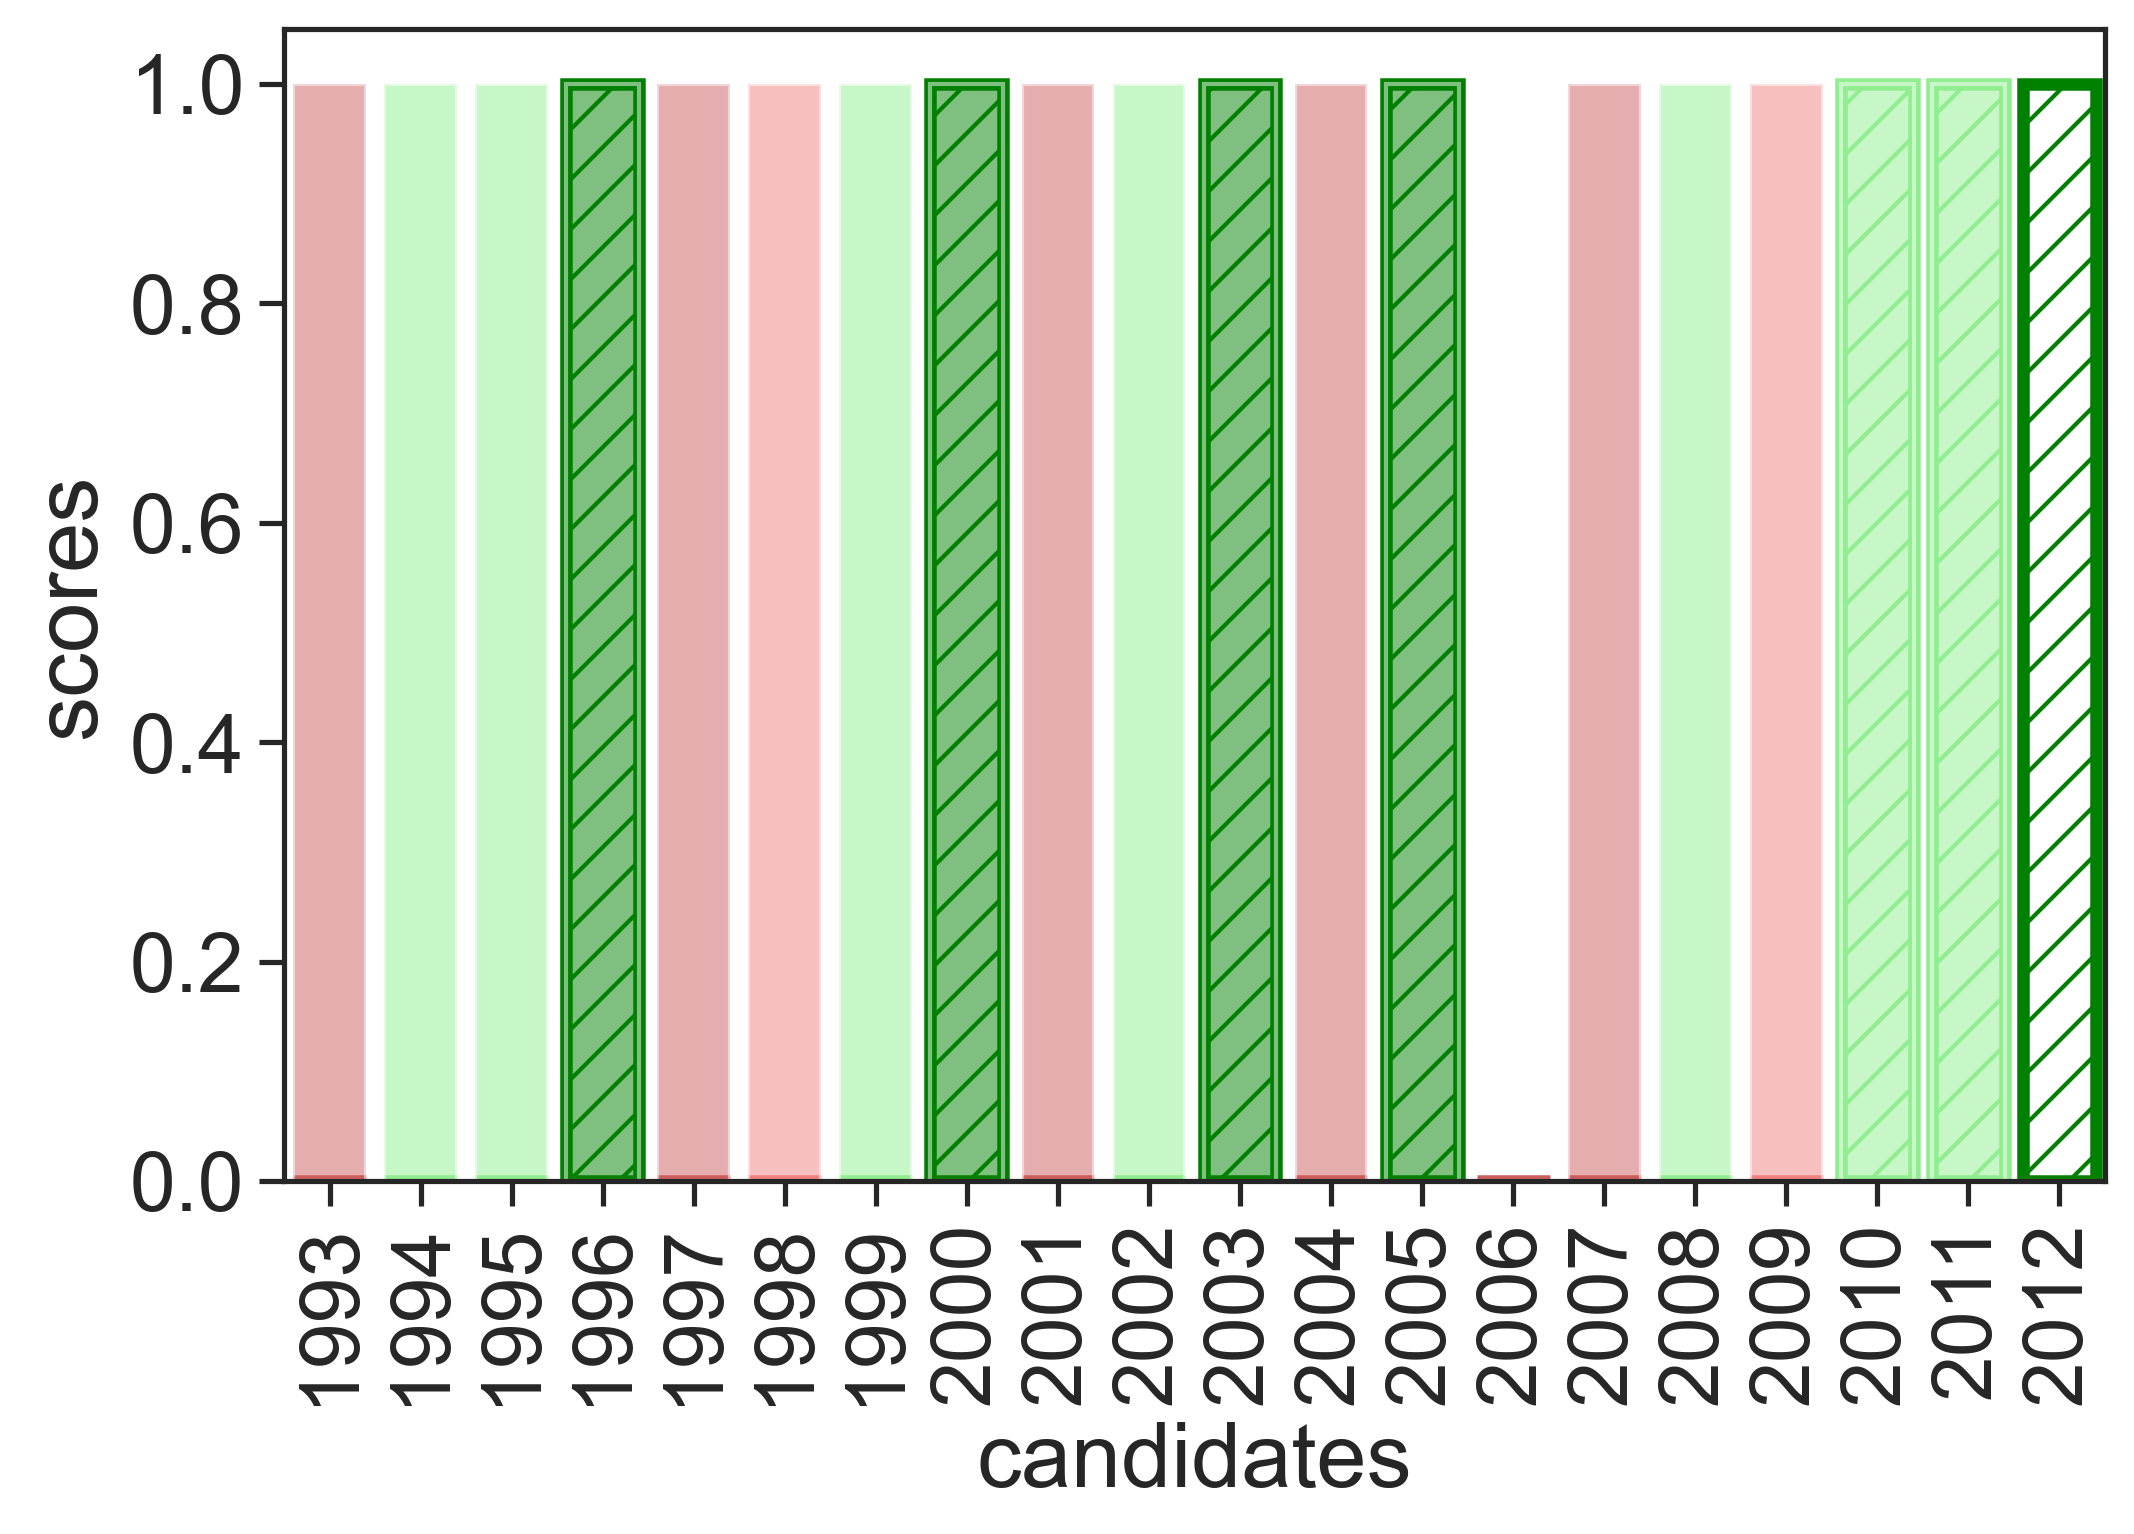

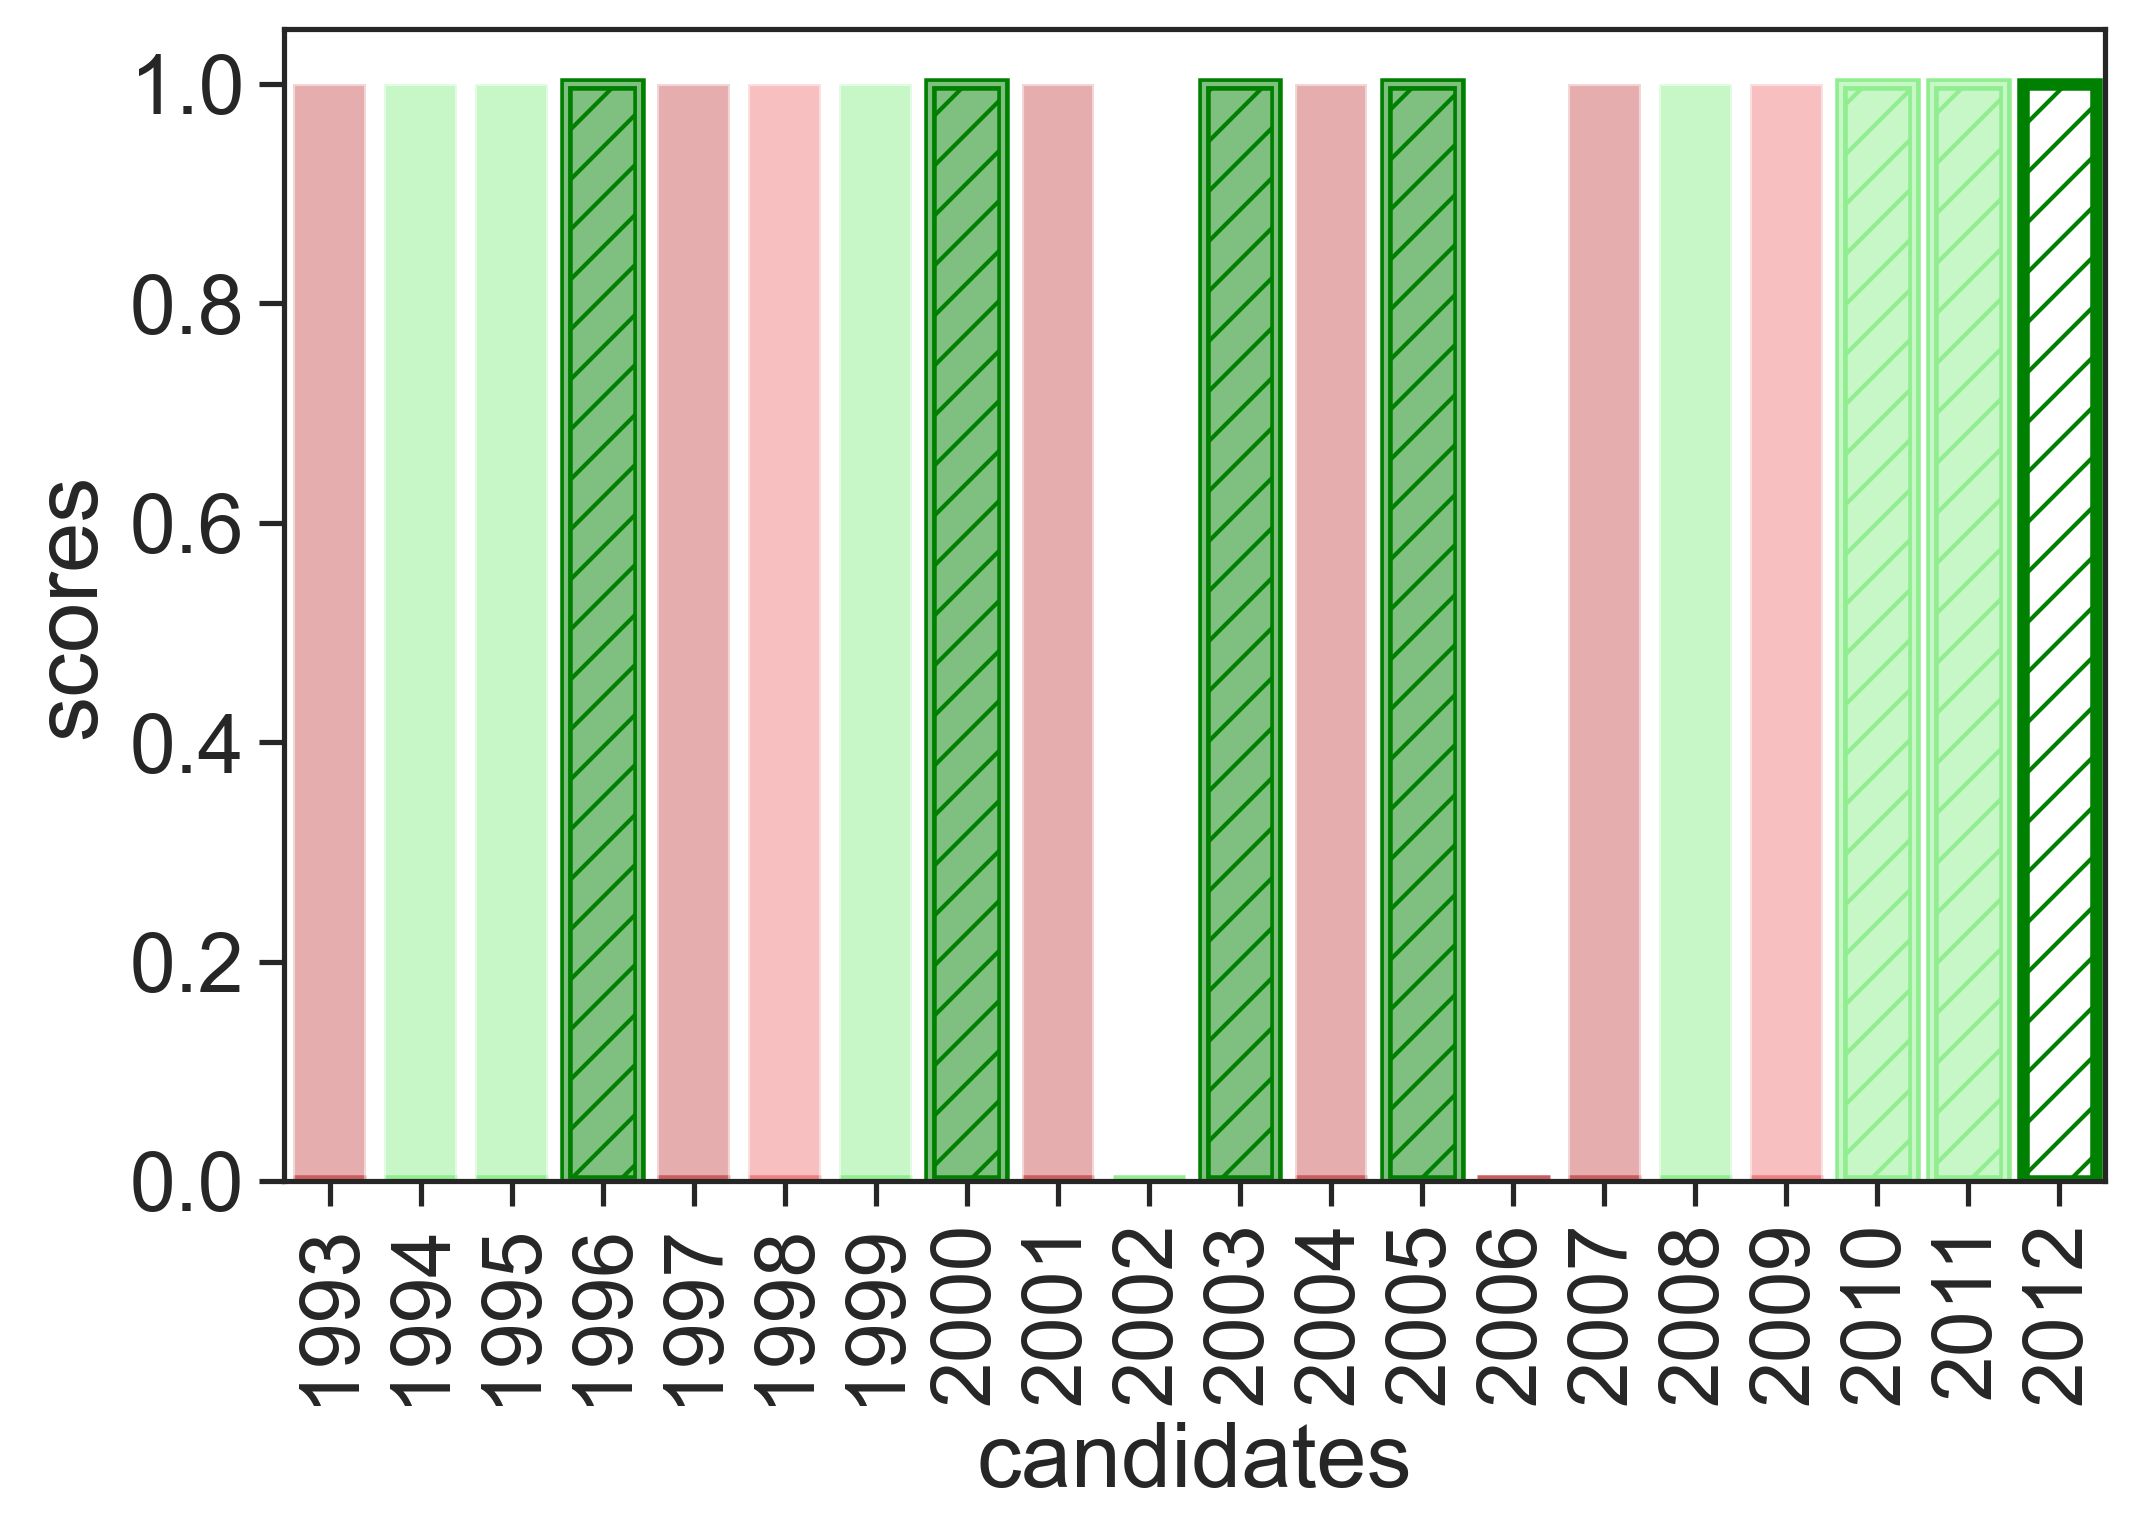

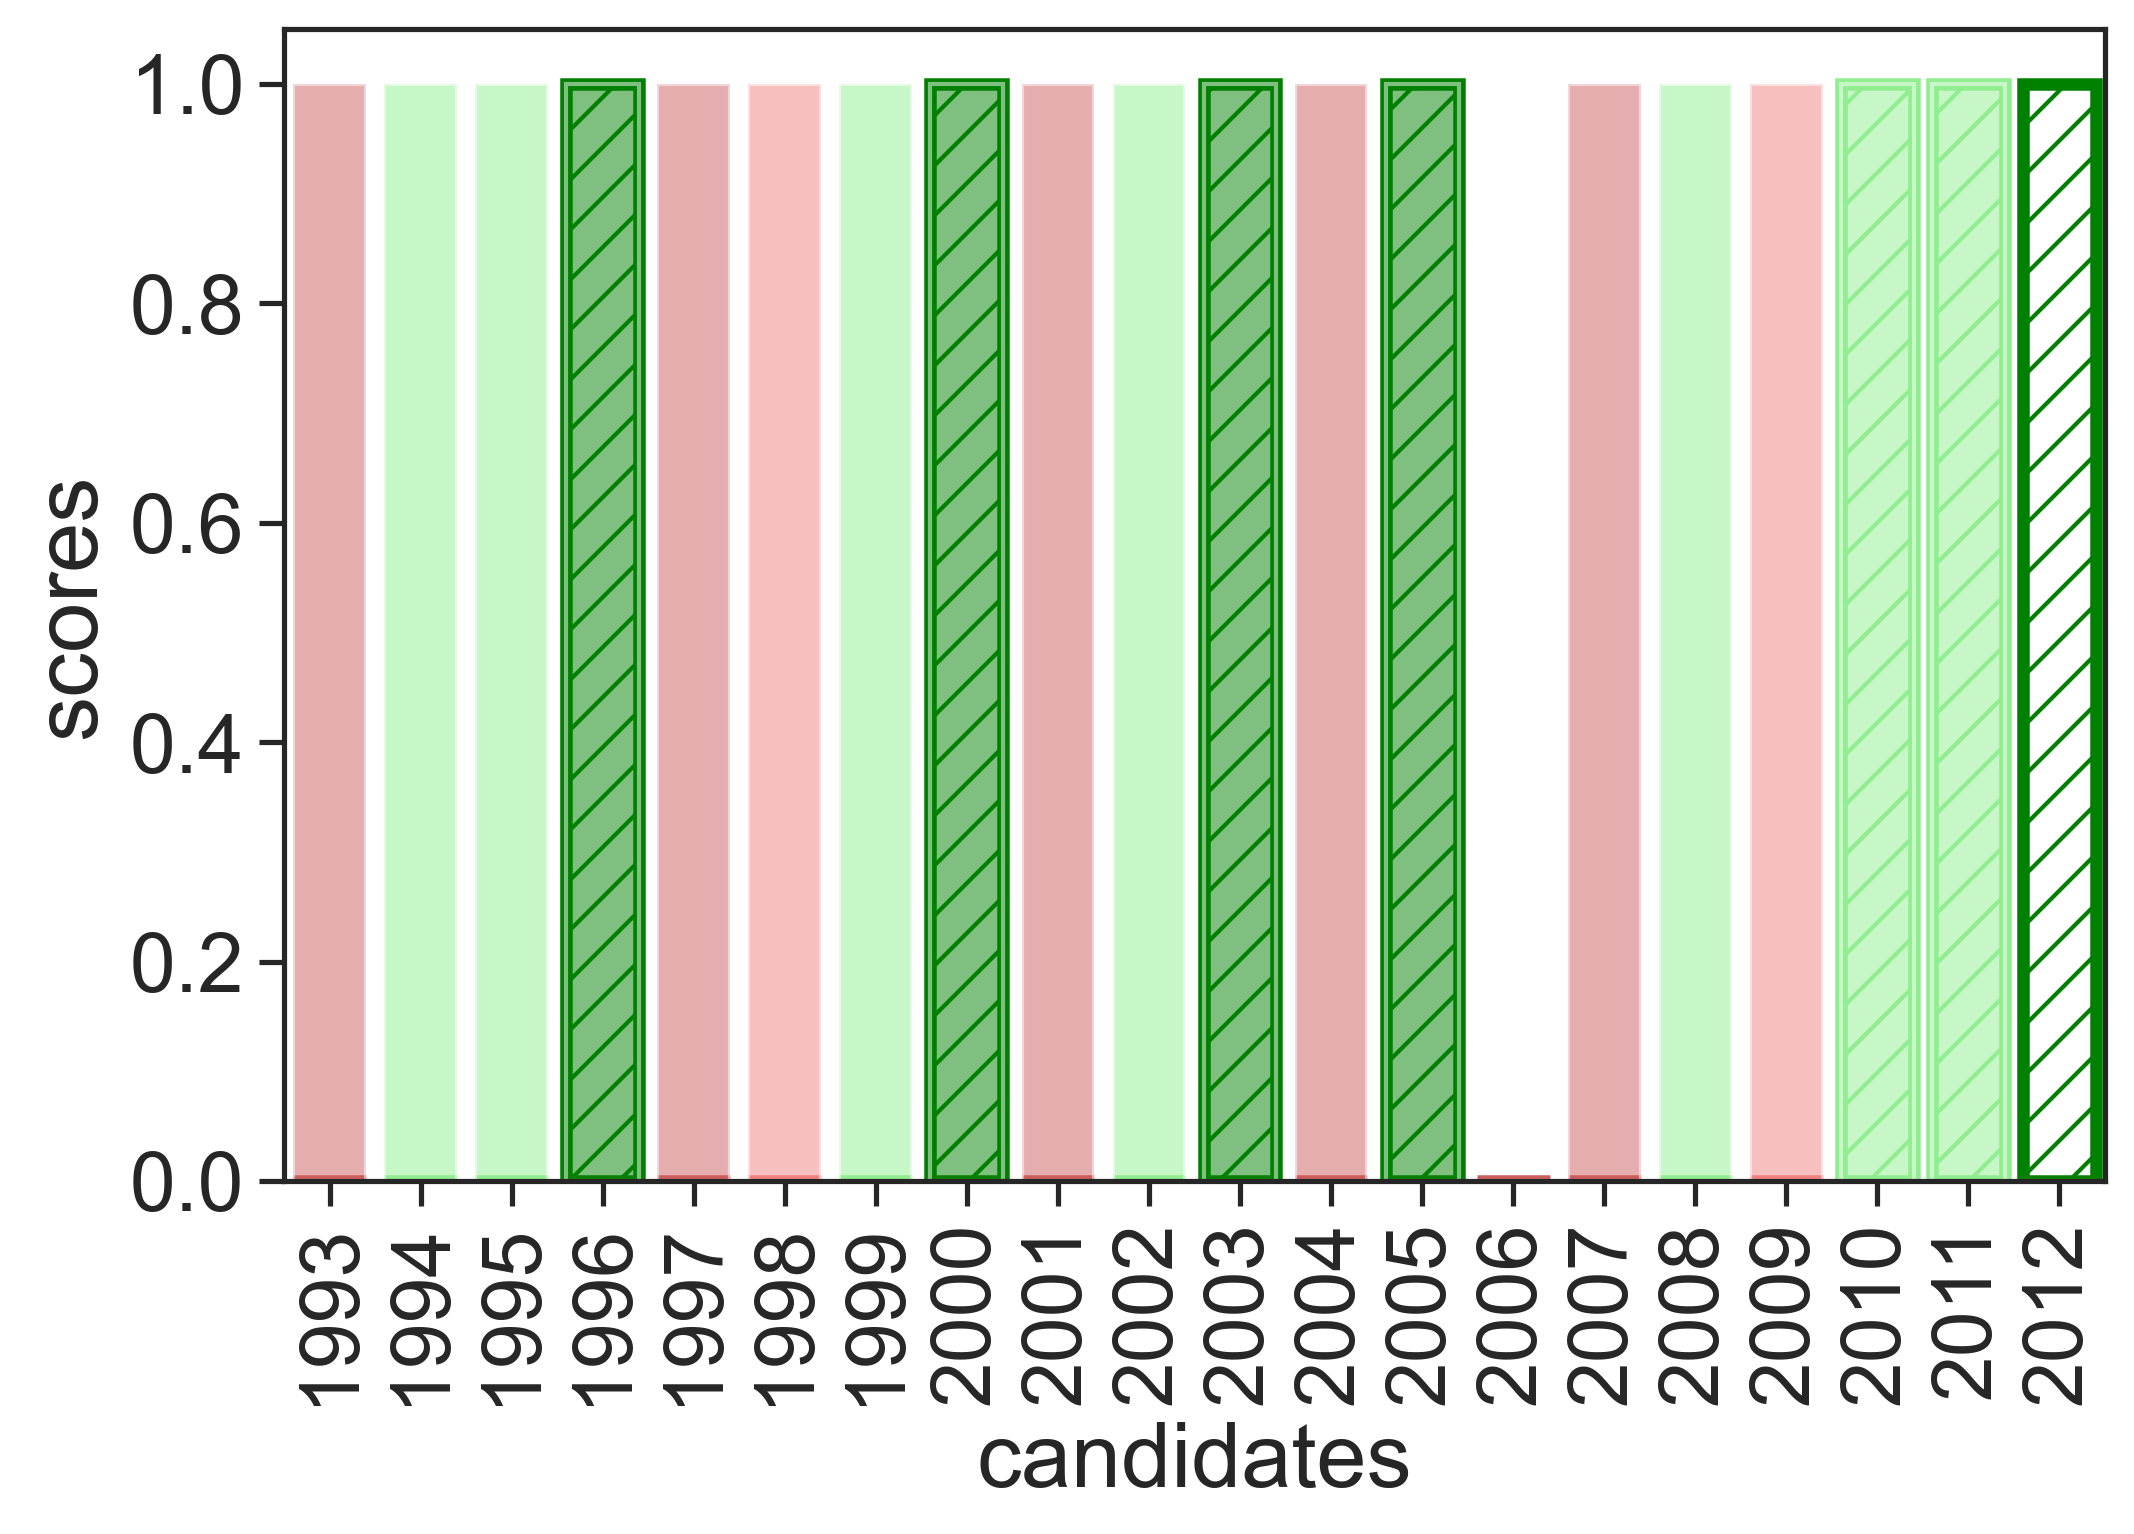

In [43]:
model = "tgat"

xaxis = range(2013 - threshold, 2013)

for navigator in ["pg_true", "pg_false", "dot_true"]:
    print("Navigator:", navigator)
    mcts_node_info = next(
        mcts_path.glob(f"{model}*simulate_v2_2013*{navigator}*{threshold}*")
    )
    # mcts_node_info
    node_info = torch.load(mcts_node_info)
    node_info = node_info["saved_MCTSInfo_list"]  # there is only one key in the dict

    best_expansion = max(node_info, key=lambda x: x["P"])

    plt.figure(figsize=(7, 5))
    
    relevancy, colors = plot_2013_tgat_og(threshold)
    plt.bar(
        xaxis,
        [1 if x in best_expansion["coalition"] else 0 for x in xaxis],
        color=colors, alpha=0.5
    )

    plt.xlim(2013 - threshold - 0.5, 2013 -1 + 0.5)
    plt.xlabel("candidates")
    plt.ylabel("scores")
    plt.xticks(xaxis, rotation=90)
    plt.savefig(f"plots/case-study/simulated_2_2013_{model}_mcts_{navigator}_th{threshold}.png")


# Runtime comparison

In [234]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}

candidate_scores_path = results_path / "candidate_scores"
globs = {
    # XTG, ATTN, PBONE, PG, XTG-D
    k: v
    for k, v in zip(
        ["xtg-og", "xtg-non", "xtg", "xtg-d"],
        [
            "{model}_{dataset}*pg_true*_th20*",
            "{model}_{dataset}*pg_false*_th20*",
            "{model}_{dataset}*mlp_true*_th20*",
            # '{model}_{dataset}*_attn*',
            # '{model}_{dataset}*_pbone*',
            # '{model}_{dataset}*_pg*',
            "{model}_{dataset}*dot_true*_th20*",
        ],
    )
}

model = "tgat"
# model = "tgn"
metric = "rollout"  # rollout, runtime
scores = {}
not_found = []
for explainer in globs:
    scores[explainer] = {}
    for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
        try:
            glob = candidate_scores_path.glob(
                globs[explainer].format(model=model, dataset=dataset)
            )

            # collate stats for all runs
            arrs = [pd.read_csv(g) for g in glob]
            res = []
            for arr in arrs:
                # find the best score
                boop = arr["best_reward"]
                # normalize
                boop = (boop - boop.min()) / (boop.max() - boop.min())
                # find the idx of the first score above 0.8
                idx = (boop >= 0.8).to_numpy().argmax()
                res.append(arr[metric].to_numpy()[idx])

            sc = np.array(res)

            # filter outliers
            sc = sc[sc - sc.mean() < 3 * sc.std()]
            print(len(sc))
            scores[explainer][dataset] = (sc.mean(), sc.std())
        except (KeyError, StopIteration):
            not_found.append(f"{explainer}_{dataset}")
            continue
print("Not found:", not_found)

# deepcopy to avoid overwriting
explainer_fid_times = pd.DataFrame.from_dict(scores, orient="columns").T
explainer_fid_times = explainer_fid_times.rename(labels, inplace=False).rename(
    dataset_to_index, axis=1, inplace=False
)

explainer_fid_times = explainer_fid_times.applymap(lambda x: f"{x[0]:.2f} ± {x[1]:.1f}")
explainer_fid_latex = (
    explainer_fid_times.style.highlight_min(props="font-weight:bold")
    .to_latex(hrules=True, convert_css=True, caption=f"Number of rollouts to 80\\% fidelity for {model.upper()} model.", label=f"tab:{model}_time")
)

with open(f"tables/{model}_{metric}_tab.tex", "w") as f:
    f.write(explainer_fid_latex)
print(explainer_fid_latex)

102
102
100
100
102
97
100
100
102
102
100
100
102
101
100
99
Not found: []
\begin{table}
\caption{Number of rollouts to 80\% fidelity for TGAT model.}
\label{tab:tgat_time}
\begin{tabular}{lllll}
\toprule
 & Synthetic V1 & Synthetic V2 & Wikipedia & Reddit \\
\midrule
PGNavigator & 171.43 ± 128.9 & 107.93 ± 135.3 & \bfseries 135.22 ± 135.5 & 141.87 ± 127.0 \\
PGNavigator (NO NAV) & \bfseries 145.64 ± 113.5 & 38.51 ± 69.0 & 163.34 ± 128.1 & 124.11 ± 124.0 \\
MLPNavigator & 167.53 ± 137.0 & \bfseries 105.85 ± 132.8 & 141.43 ± 122.0 & 126.16 ± 134.8 \\
DotProductNavigator & 155.77 ± 127.3 & 78.44 ± 109.2 & 169.40 ± 135.8 & \bfseries 111.65 ± 116.2 \\
\bottomrule
\end{tabular}
\end{table}



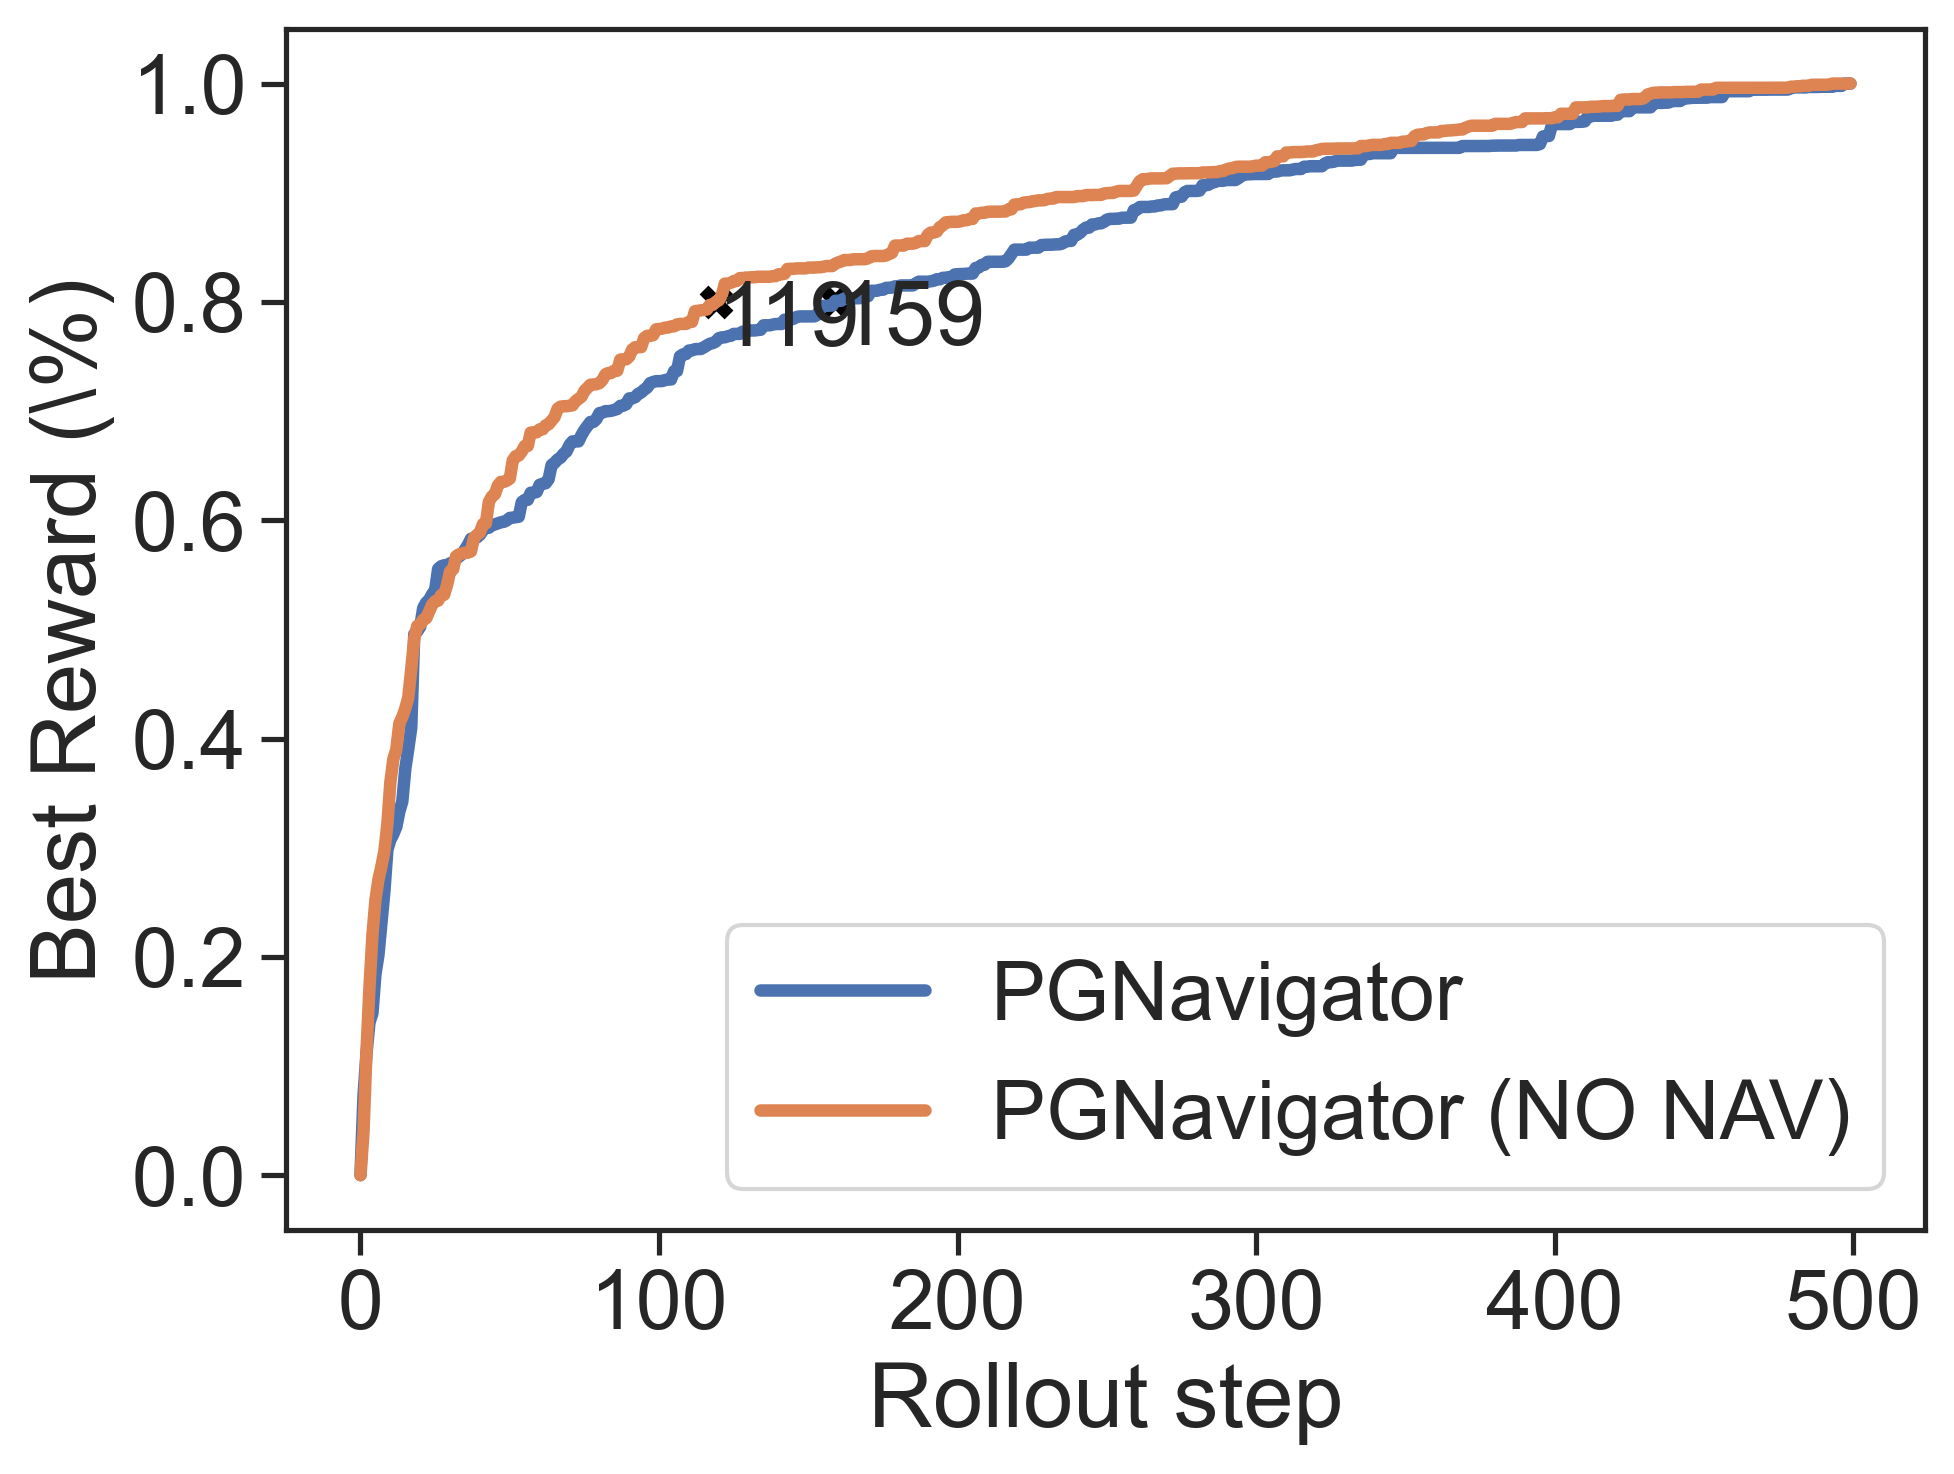

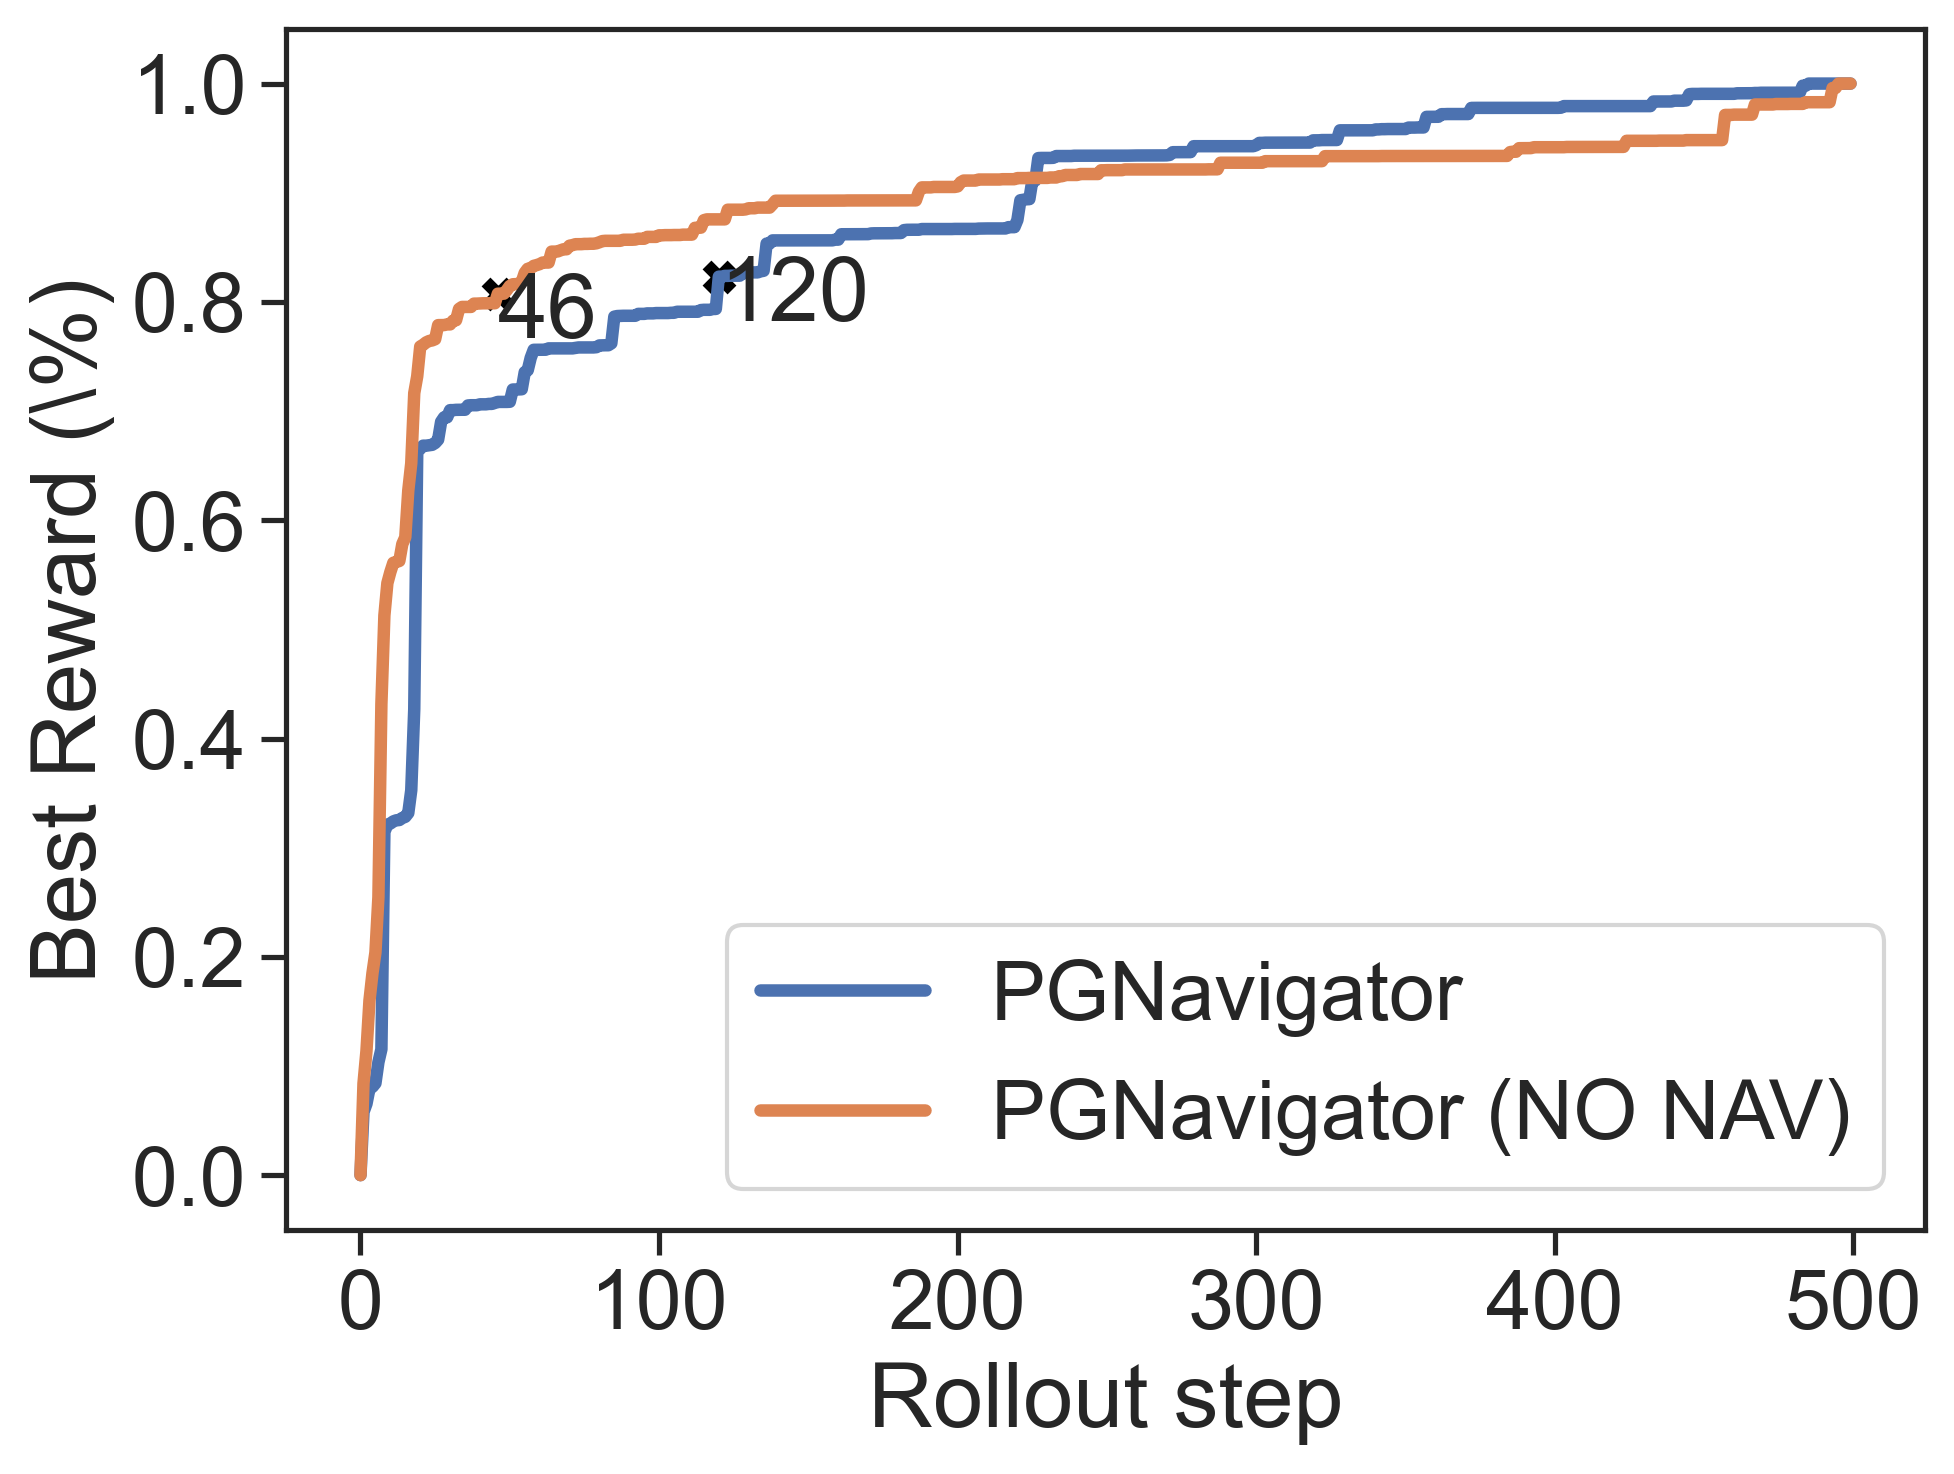

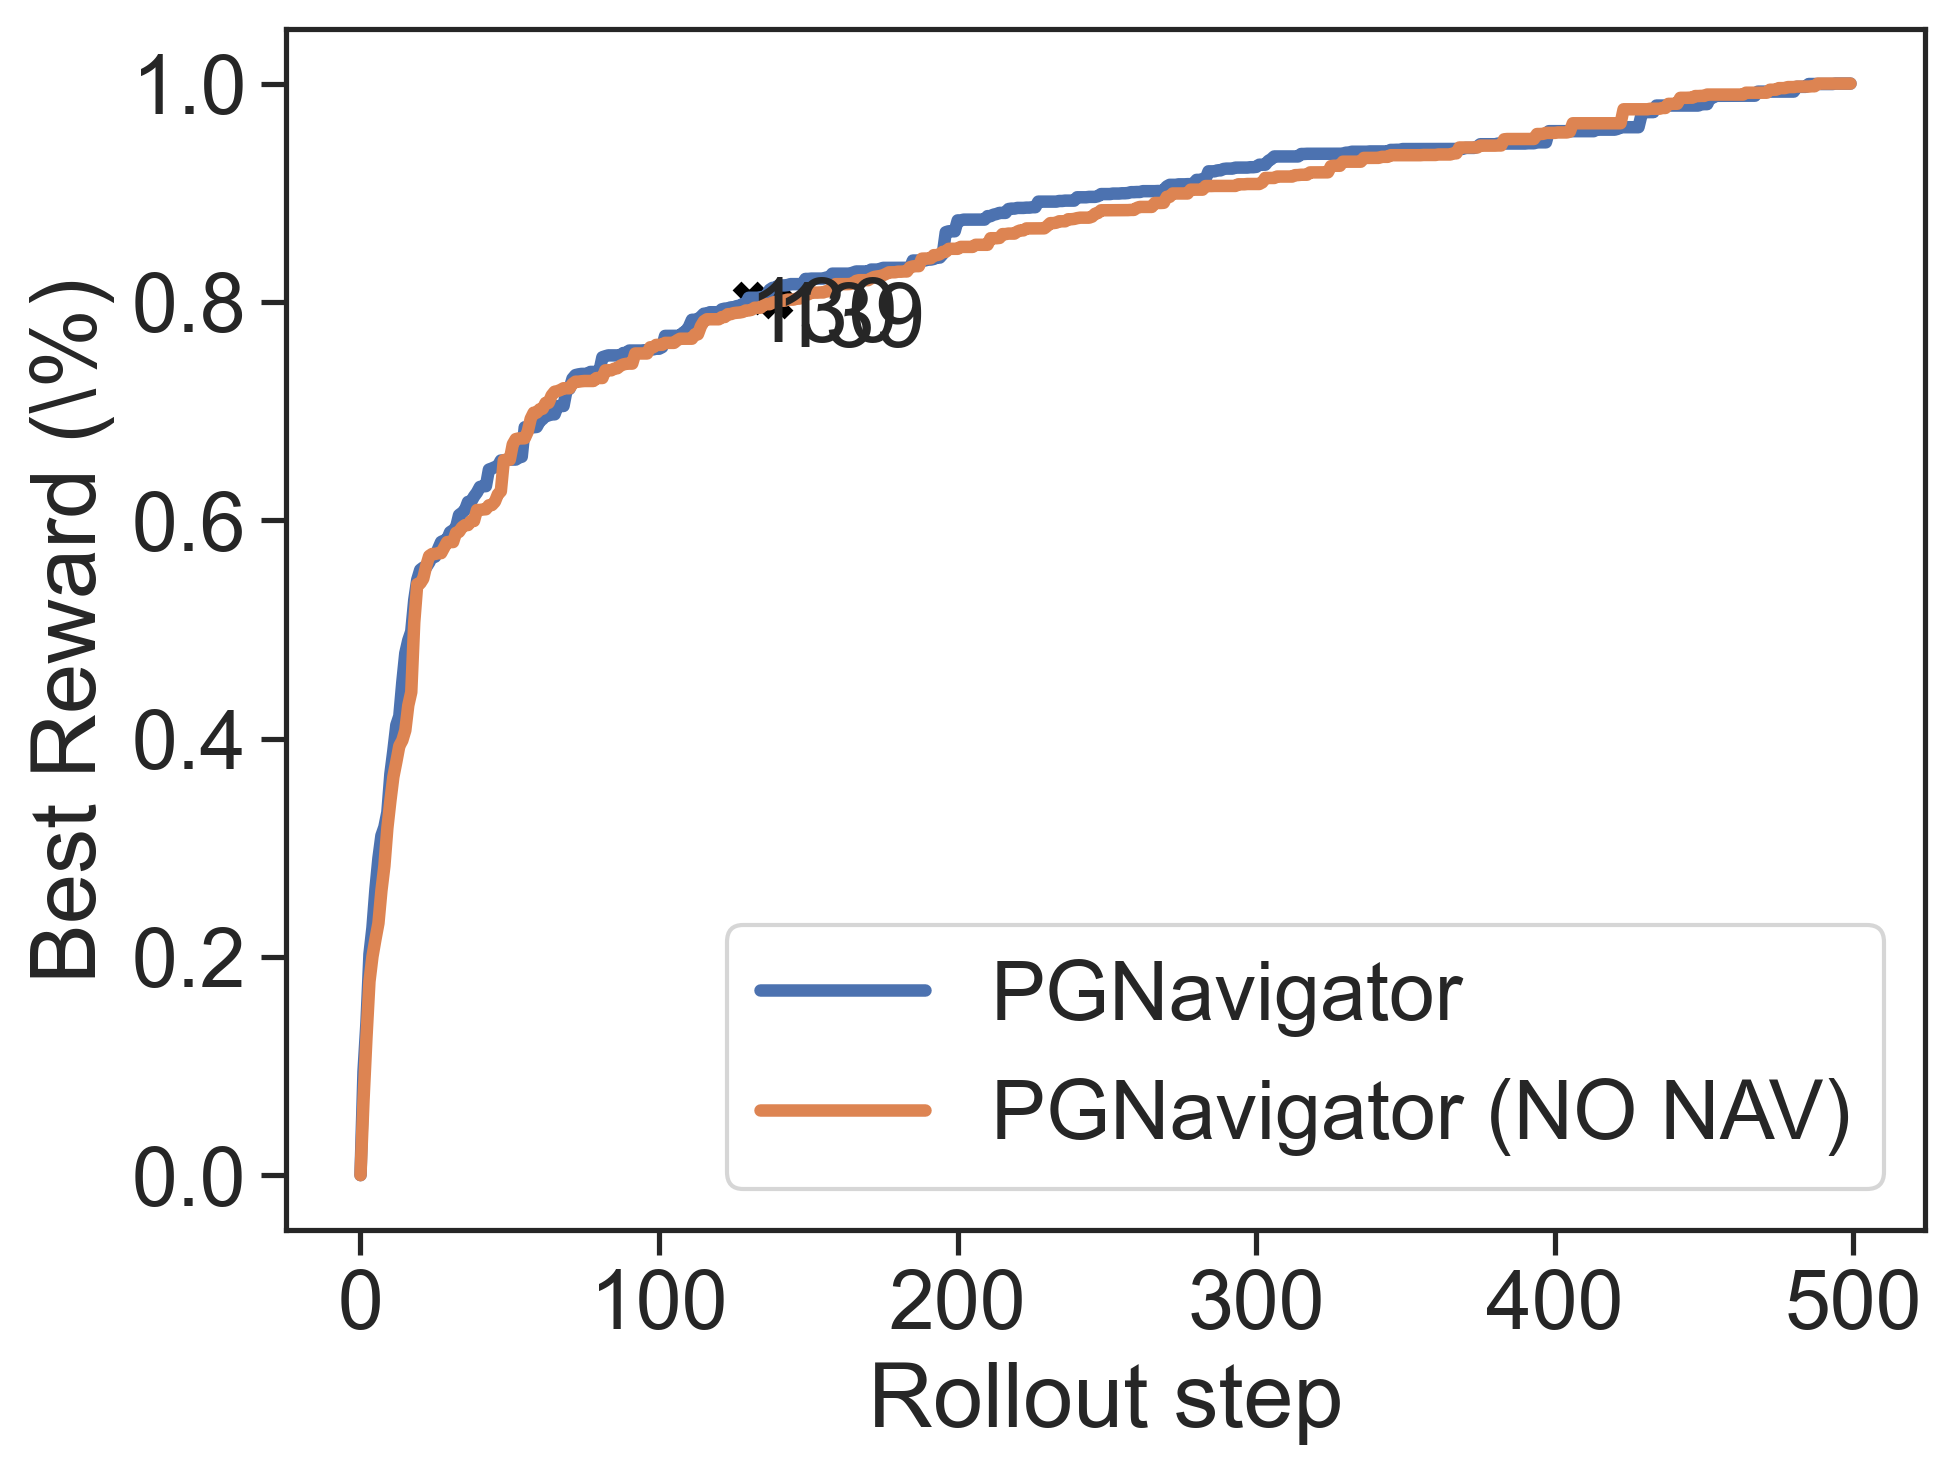

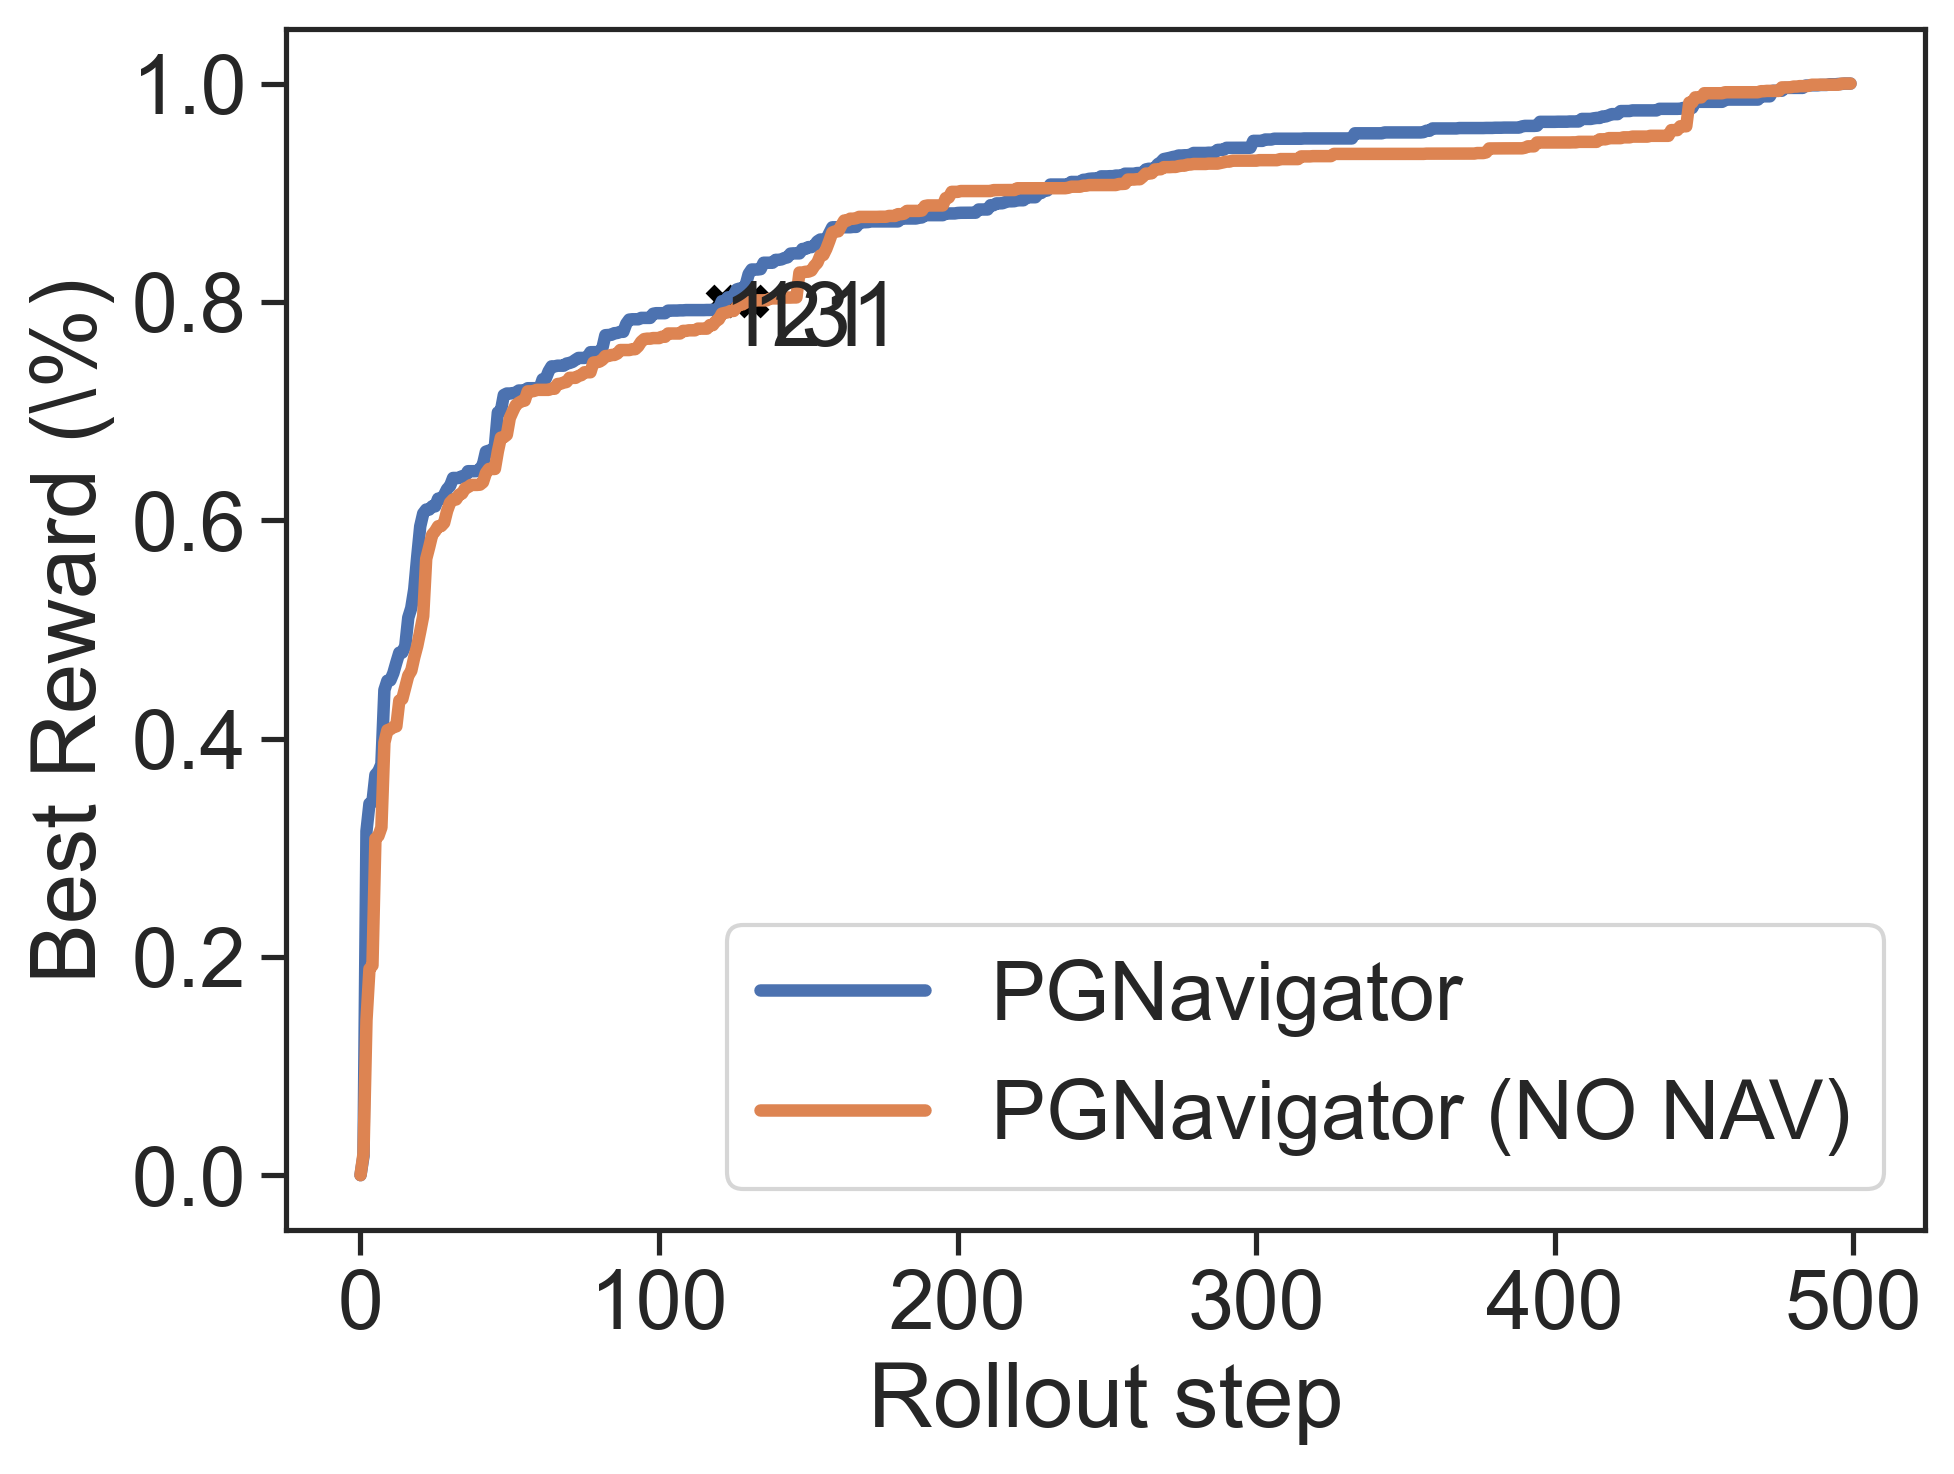

Not found: []


In [235]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}



candidate_scores_path = results_path / "candidate_scores"
globs = {
    # XTG, ATTN, PBONE, PG, XTG-D
    k: v
    for k, v in zip(
        ["xtg-og", "xtg-non", "xtg", "xtg-d"],
        [
            "{model}_{dataset}*pg_true*_th20*",
            "{model}_{dataset}*pg_false*_th20*",
            # "{model}_{dataset}*mlp_true*_th20*",
            # '{model}_{dataset}*_attn*',
            # '{model}_{dataset}*_pbone*',
            # '{model}_{dataset}*_pg*',
            # "{model}_{dataset}*dot_true*_th20*",
        ],
    )
}

model = "tgat"
# model = "tgn"
not_found = []
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sns.set_style("ticks")
for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
    for explainer in globs:
        try:
            glob = candidate_scores_path.glob(
                globs[explainer].format(model=model, dataset=dataset)
            )

            # collate stats for all runs
            arrs = [pd.read_csv(g) for g in glob]

            mat = [arr["best_reward"].to_numpy() for arr in arrs]

            mat = np.array(mat).mean(axis=0)
            # normalize
            mat = (mat - mat.min()) / (mat.max() - mat.min())
            index = np.argmax(mat >= 0.8)

            plt.plot(mat, label=labels[explainer])
            plt.scatter(index, mat[index], marker="x", color="black")
            
            plt.text(index, mat[index]-0.04, f"{index}")
            # plt.axhline(y=mat[index], color='r', linestyle='dotted')  # draw horizontal line
            # plt.axvline(x=index, color='r', linestyle='dotted')  # draw vertical line

            plt.xlabel("Rollout step")
            plt.ylabel("Best Reward (\%)")

        except (KeyError, StopIteration):
            not_found.append(f"{explainer}_{dataset}")
            continue
    # plt.title(dataset_to_index[dataset])
    plt.legend()
    plt.savefig(f"plots/fidelity-rollout/{model}_misc_rollout_plot_{dataset}.png")
    plt.show()
print("Not found:", not_found)


In [236]:
candidate_scores_path = results_path / "candidate_scores"
globs = {
    # XTG, ATTN, PBONE, PG, XTG-D
    k: v
    for k, v in zip(
        ["xtg-og", "xtg-non", "xtg", "xtg-d", "attn", "pbone", "pg"],
        [
            "{model}_{dataset}*pg_true*_th20*",
            "{model}_{dataset}*pg_false*_th20*",
            "{model}_{dataset}*mlp_true*_th20*",
            "{model}_{dataset}*dot_true*_th20*",
            "{model}_{dataset}_attn*_th20_can*",
            "{model}_{dataset}_pbone*_th20_can*",
            "{model}_{dataset}_pg*_th20_can*",
        ],
    )
}

# model = "tgat"
model = "tgn"
not_found = []
runtime_df = {}
for explainer in globs:
    runtime_df[explainer] = {}
    for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
        try:
            glob = candidate_scores_path.glob(
                globs[explainer].format(model=model, dataset=dataset)
            )

            # collate stats for all runs
            arrs = [pd.read_csv(g) for g in glob]

            # only get the last value (since in the mcts algos the values are cumulative whilst for the rest its duplicated across all)
            mat = [arr["runtime"].to_numpy()[-1] for arr in arrs]

            runtime_df[explainer][dataset] = f"{np.mean(mat):.3f}±{np.std(mat):.1f}"
        
        except (KeyError, StopIteration):
            not_found.append(f"{explainer}_{dataset}")
            continue
print("Not found:", not_found)

runtime_df = pd.DataFrame.from_dict(runtime_df, orient="columns").T
runtime_df = runtime_df.rename(labels, inplace=False).rename(
    dataset_to_index, axis=1, inplace=False
)

runtime_df = runtime_df.loc[["ATTN", "PBONE", "PG", "PGNavigator", "PGNavigator (NO NAV)", "MLPNavigator", "DotProductNavigator"]]
latex = runtime_df.style.format(precision=3).to_latex(
    convert_css=True, multicol_align="c", hrules=True, column_format="lrrrrrrrr",
    caption=f"Runtime comparison for a single event explanation with {model.upper()} base model (in seconds).",
    label="tab:tgn_runtime_single"
)

with open(f"tables/{model}_runtime_single_tab.tex", "w") as f:
    f.write(latex)
print(latex)

Not found: []
\begin{table}
\caption{Runtime comparison for a single event explanation with TGN base model (in seconds).}
\label{tab:tgn_runtime_single}
\begin{tabular}{lrrrrrrrr}
\toprule
 & Synthetic V1 & Synthetic V2 & Wikipedia & Reddit \\
\midrule
ATTN & 0.006±0.0 & 0.006±0.0 & 0.014±0.0 & 0.029±0.0 \\
PBONE & 0.079±0.0 & 0.079±0.0 & 0.222±0.0 & 0.251±0.0 \\
PG & 0.001±0.0 & 0.001±0.0 & 0.001±0.0 & 0.001±0.0 \\
PGNavigator & 29.252±6.8 & 13.301±1.4 & 45.987±11.5 & 56.312±7.5 \\
PGNavigator (NO NAV) & 17.274±3.8 & 13.239±1.8 & 51.807±11.8 & 56.552±7.9 \\
MLPNavigator & 23.547±8.9 & 14.031±1.6 & 42.573±6.8 & 74.467±18.2 \\
DotProductNavigator & 25.381±4.6 & 12.470±1.5 & 69.283±28.6 & 56.260±8.1 \\
\bottomrule
\end{tabular}
\end{table}

